In [ ]:
#Pomysły/komentarze:
# 1) Będziemy musieli zrobić coś z kategorią 2 w płci (agregacja do 0/1 lub usunięcie, około 2000 rekordów)

# 2) W Targecie ('diagnosed_diabetes') występują ułamki, trzeba się temu przyjrzeć

# 3) Przydałby się segment feature ranking 
# (taki jaki mamy w regresji liniowej ML1- ja prawdopodobnie będę bazował na boruta_rank,
#  ale opracowanie pod mi_score/f_score też może się przydać)
# ^ pewien 'teaser' dodany przeze mnie, do sprawdzenia

# 4) Potrzeba będzie uporządkować i uzupełniać biblioteki w pierwszym code chunku

# 5) Jakie metryki przyjmujemy do oceny modeli? Wcześniej mieliśmy regresję więc RMSE/MAPE pasowało
# ale teraz mamy klasyfikacje, w takim razie bardziej jakieś accuracy/precision/recall/F1-score?

# 6) Modele: wymóg jest co do 4 (najlepiej pewnie 2 moje 2 twoje, ale do dogadania- mogą być 3 moje, 1 twój)
# tylko mimo wszystko ja bym przepuścił dane przez WSZYTKIE możliwe modele 'działające' na tych danych
# z nich wybierzemy najlepiej prosperujące, przy prezentacji też można wspomnieć czemu te właśnie


In [ ]:
#Dodam jeszcze komentarze w kodzie, żeby było wiadomo co i jak. Ale ogólnie sieci neuronowe są ju ready to go do prezentacji.

[LOADING DEPENDENCIES](#Loading_dependencies)



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import(
    RFECV,
    mutual_info_regression,
    mutual_info_classif,
    VarianceThreshold,
    f_regression,
    f_classif)
from sklearn.preprocessing import(
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder)
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import (
    train_test_split,
    cross_val_score, 
    GridSearchCV)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
    Lasso,
    Ridge,
    ElasticNet
)
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    make_scorer,
    accuracy_score, 
    classification_report
)
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV,
    GridSearchCV
)
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, mean_squared_error, make_scorer, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from itertools import product
from collections import Counter
from tqdm import tqdm
import scipy.stats as sc
from scipy.stats import uniform
from ReliefF import ReliefF
from boruta import BorutaPy as bp
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

[EDA AMD DATA PROCESSING](#EDA_and_data_processing)

In [ ]:
# Load the dataset
df=pd.read_csv("data/input/diabetes_dataset.csv")

In [3]:
df.head()

age  gender ethnicity education_level  income_level employment_status  \
0   58    Male     Asian      Highschool  Lower-Middle          Employed   
1   48  Female     White      Highschool        Middle          Employed   
2   60    Male  Hispanic      Highschool        Middle        Unemployed   
3   74  Female     Black      Highschool           Low           Retired   
4   46    Male     White        Graduate        Middle           Retired   

  smoking_status  alcohol_consumption_per_week  \
0          Never                             0   
1         Former                             1   
2          Never                             1   
3          Never                             0   
4          Never                             1   

   physical_activity_minutes_per_week  diet_score  ...  hdl_cholesterol  \
0                                 215         5.7  ...               41   
1                                 143         6.7  ...               55   
2                                  57         6.4  ...               66   
3                                  49         3.4  ...               50   
4                                 109         7.2  ...               52   

   ldl_cholesterol  triglycerides  glucose_fasting  glucose_postprandial  \
0              160            145              136                   236   
1               50             30               93                   150   
2               99             36              118                   195   
3               79            140              139                   253   
4              125            160              137                   184   

   insulin_level  hba1c  diabetes_risk_score  diabetes_stage  \
0           6.36   8.18                 29.6          Type 2   
1           2.00   5.63                 23.0     No Diabetes   
2           5.07   7.51                 44.7          Type 2   
3           5.28   9.03                 38.2          Type 2   
4          12.74   7.20                 23.5          Type 2   

   diagnosed_diabetes  
0                   1  
1                   0  
2                   1  
3                   1  
4                   1  

[5 rows x 31 columns]

In [7]:
df.shape #100000 entries

(100000, 31)

In [8]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age                                 100000 non-null  int64  
 1   gender                              100000 non-null  object 
 2   ethnicity                           100000 non-null  object 
 3   education_level                     100000 non-null  object 
 4   income_level                        100000 non-null  object 
 5   employment_status                   100000 non-null  object 
 6   smoking_status                      100000 non-null  object 
 7   alcohol_consumption_per_week        100000 non-null  int64  
 8   physical_activity_minutes_per_week  100000 non-null  int64  
 9   diet_score                          100000 non-null  float64
 10  sleep_hours_per_day                 100000 non-null  float64
 11  screen_time_hours_per_day  

In [9]:
df.isna().sum() #There are no NAs in this dataset

age                                   0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
employment_status                     0
smoking_status                        0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
glucose_fasting                       0


In [4]:
#Initial global transformation of data (creation of boolean/categorical variables, one-hot encoders)

df = df.drop(columns='diabetes_stage')
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0, 'Other': 2})
df['ethnicity'] = df['ethnicity'].map({'White' : 0, 'Hispanic' : 1, 'Black' : 2, 'Asian' : 3, 'Other' : 4})
df['education_level'] = df['education_level'].map({'No formal' : 0, 'Highschool' : 1, 'Graduate' : 2, 'Postgraduate' : 3})
df['income_level'] = df['income_level'].map({'Low' : 0, 'Lower-Middle' :1, 'Middle' : 2, 'Upper-Middle' : 3, 'High': 4})
df['employment_status'] = df['employment_status'].map({'Employed' : 0, 'Unemployed' : 1, 'Retired': 2, 'Student':3})
df['smoking_status'] = df['smoking_status'].map({'Never' : 0, 'Former' : 1, 'Current' : 2})

In [11]:
df.describe() # 'diagnosed_diabetes' as target variable (Classification: 0=No, 1=Yes)

age         gender     ethnicity  education_level  \
count  100000.00000  100000.000000  100000.00000    100000.000000   
mean       50.12041       0.517970       1.11866         1.598810   
std        15.60460       0.538461       1.24289         0.801051   
min        18.00000       0.000000       0.00000         0.000000   
25%        39.00000       0.000000       0.00000         1.000000   
50%        50.00000       0.000000       1.00000         2.000000   
75%        61.00000       1.000000       2.00000         2.000000   
max        90.00000       2.000000       4.00000         3.000000   

        income_level  employment_status  smoking_status  \
count  100000.000000      100000.000000    100000.00000   
mean        1.750600           0.738780         0.60363   
std         1.086854           0.998486         0.80174   
min         0.000000           0.000000         0.00000   
25%         1.000000           0.000000         0.00000   
50%         2.000000           0.000000         0.00000   
75%         2.000000           2.000000         1.00000   
max         4.000000           3.000000         2.00000   

       alcohol_consumption_per_week  physical_activity_minutes_per_week  \
count                 100000.000000                       100000.000000   
mean                       2.003670                          118.911640   
std                        1.417779                           84.409662   
min                        0.000000                            0.000000   
25%                        1.000000                           57.000000   
50%                        2.000000                          100.000000   
75%                        3.000000                          160.000000   
max                       10.000000                          833.000000   

          diet_score  ...  cholesterol_total  hdl_cholesterol  \
count  100000.000000  ...      100000.000000    100000.000000   
mean        5.994787  ...         185.978110        54.042790   
std         1.780954  ...          32.013005        10.267374   
min         0.000000  ...         100.000000        20.000000   
25%         4.800000  ...         164.000000        47.000000   
50%         6.000000  ...         186.000000        54.000000   
75%         7.200000  ...         208.000000        61.000000   
max        10.000000  ...         318.000000        98.000000   

       ldl_cholesterol  triglycerides  glucose_fasting  glucose_postprandial  \
count    100000.000000  100000.000000     100000.00000         100000.000000   
mean        103.000430     121.462650        111.11712            160.035050   
std          33.390256      43.372619         13.59561             30.935472   
min          50.000000      30.000000         60.00000             70.000000   
25%          78.000000      91.000000        102.00000            139.000000   
50%         102.000000     121.000000        111.00000            160.000000   
75%         126.000000     151.000000        120.00000            181.000000   
max         263.000000     344.000000        172.00000            287.000000   

       insulin_level          hba1c  diabetes_risk_score  diagnosed_diabetes  
count  100000.000000  100000.000000        100000.000000       100000.000000  
mean        9.061242       6.520776            30.222362            0.599980  
std         4.954060       0.813921             9.061505            0.489904  
min         2.000000       4.000000             2.700000            0.000000  
25%         5.090000       5.970000            23.800000            0.000000  
50%         8.790000       6.520000            29.000000            1.000000  
75%        12.450000       7.070000            35.600000            1.000000  
max        32.220000       9.800000            67.200000            1.000000  

[8 rows x 30 columns]

In [5]:
# Define train and target 
target = df[['diagnosed_diabetes']]
train = df.drop('diagnosed_diabetes', axis = 1)

In [6]:
#Division of dataset
x_train_full, x_test = train_test_split(train, test_size=0.2, random_state=123)
y_train_full, y_test = train_test_split(target, test_size=0.2, random_state=123)

In [7]:
#Also, let's split the dataset in a way it will also include the target variable (it will be useful during model preparation)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=123)

In [15]:
print("\nTRAIN:")
display(x_train_full.head())
print("SHAPE:",x_train_full.shape)

print("\nTEST:")
display(x_test.head())
print("SHAPE:",x_test.shape)


TRAIN:


age  gender  ethnicity  education_level  income_level  \
22302   65       1          2                1             3   
49609   36       0          0                2             0   
89251   20       0          0                1             2   
96385   40       0          3                2             0   
17569   24       0          0                1             2   

       employment_status  smoking_status  alcohol_consumption_per_week  \
22302                  0               0                             1   
49609                  0               0                             1   
89251                  0               2                             1   
96385                  0               1                             1   
17569                  2               0                             1   

       physical_activity_minutes_per_week  diet_score  ...  heart_rate  \
22302                                 321         6.5  ...          72   
49609                                  19         7.1  ...          78   
89251                                 243         6.7  ...          59   
96385                                 279         7.5  ...          77   
17569                                 108         6.0  ...          69   

       cholesterol_total  hdl_cholesterol  ldl_cholesterol  triglycerides  \
22302                194               54              108            135   
49609                171               65               74            169   
89251                197               60               94             62   
96385                211               56              116             82   
17569                113               58               50            146   

       glucose_fasting  glucose_postprandial  insulin_level  hba1c  \
22302              112                   145           4.96   6.27   
49609              128                   163          10.06   6.79   
89251              102                   108          12.01   5.35   
96385              116                   164          17.15   6.52   
17569               83                   108           7.33   5.16   

       diabetes_risk_score  
22302                 23.0  
49609                 40.5  
89251                 10.7  
96385                 32.4  
17569                 18.3  

[5 rows x 29 columns]

SHAPE: (80000, 29)

TEST:


age  gender  ethnicity  education_level  income_level  \
42083   45       0          0                2             1   
71825   74       0          1                1             3   
99535   72       1          0                2             0   
47879   71       1          1                3             3   
36734   38       0          1                1             3   

       employment_status  smoking_status  alcohol_consumption_per_week  \
42083                  1               2                             2   
71825                  0               0                             3   
99535                  0               1                             2   
47879                  1               0                             1   
36734                  0               0                             3   

       physical_activity_minutes_per_week  diet_score  ...  heart_rate  \
42083                                 110         8.0  ...          74   
71825                                 101         6.8  ...          70   
99535                                  31         7.1  ...          79   
47879                                  36         9.8  ...          84   
36734                                  30         8.0  ...          69   

       cholesterol_total  hdl_cholesterol  ldl_cholesterol  triglycerides  \
42083                169               32              111            145   
71825                144               52               64            165   
99535                194               57              114            155   
47879                142               78               50            117   
36734                212               75               85            122   

       glucose_fasting  glucose_postprandial  insulin_level  hba1c  \
42083              128                   198           8.88   7.83   
71825              133                   208          15.52   7.81   
99535              110                   172           4.64   6.92   
47879              132                   181           5.79   7.38   
36734              102                   187          14.84   7.28   

       diabetes_risk_score  
42083                 27.5  
71825                 52.2  
99535                 51.2  
47879                 32.5  
36734                 24.6  

[5 rows x 29 columns]

SHAPE: (20000, 29)


In [16]:
#Let's see whether target variable ('diagnosed_diabetes') is balanced
{i: y_train_full.quantile(i) for i in np.arange(0, 1.1, 0.1)} #mild imbalance but rather acceptable (therefore, we don't need to rebalance it with e.g. SMOTE)

{np.float64(0.0): diagnosed_diabetes    0.0
 Name: 0.0, dtype: float64,
 np.float64(0.1): diagnosed_diabetes    0.0
 Name: 0.1, dtype: float64,
 np.float64(0.2): diagnosed_diabetes    0.0
 Name: 0.2, dtype: float64,
 np.float64(0.30000000000000004): diagnosed_diabetes    0.0
 Name: 0.30000000000000004, dtype: float64,
 np.float64(0.4): diagnosed_diabetes    1.0
 Name: 0.4, dtype: float64,
 np.float64(0.5): diagnosed_diabetes    1.0
 Name: 0.5, dtype: float64,
 np.float64(0.6000000000000001): diagnosed_diabetes    1.0
 Name: 0.6000000000000001, dtype: float64,
 np.float64(0.7000000000000001): diagnosed_diabetes    1.0
 Name: 0.7000000000000001, dtype: float64,
 np.float64(0.8): diagnosed_diabetes    1.0
 Name: 0.8, dtype: float64,
 np.float64(0.9): diagnosed_diabetes    1.0
 Name: 0.9, dtype: float64,
 np.float64(1.0): diagnosed_diabetes    1.0
 Name: 1.0, dtype: float64}

In [17]:
{i: y_test.quantile(i) for i in np.arange(0, 1.1, 0.1)} #similar distribution between train and test set

{np.float64(0.0): diagnosed_diabetes    0.0
 Name: 0.0, dtype: float64,
 np.float64(0.1): diagnosed_diabetes    0.0
 Name: 0.1, dtype: float64,
 np.float64(0.2): diagnosed_diabetes    0.0
 Name: 0.2, dtype: float64,
 np.float64(0.30000000000000004): diagnosed_diabetes    0.0
 Name: 0.30000000000000004, dtype: float64,
 np.float64(0.4): diagnosed_diabetes    0.0
 Name: 0.4, dtype: float64,
 np.float64(0.5): diagnosed_diabetes    1.0
 Name: 0.5, dtype: float64,
 np.float64(0.6000000000000001): diagnosed_diabetes    1.0
 Name: 0.6000000000000001, dtype: float64,
 np.float64(0.7000000000000001): diagnosed_diabetes    1.0
 Name: 0.7000000000000001, dtype: float64,
 np.float64(0.8): diagnosed_diabetes    1.0
 Name: 0.8, dtype: float64,
 np.float64(0.9): diagnosed_diabetes    1.0
 Name: 0.9, dtype: float64,
 np.float64(1.0): diagnosed_diabetes    1.0
 Name: 1.0, dtype: float64}

In [18]:
#Filling out the NA's
x_train_full.isna().sum()

age                                   0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
employment_status                     0
smoking_status                        0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
glucose_fasting                       0


In [8]:
# Creation of a validation set from training data
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2)

INITIAL DATA EXPLORATION

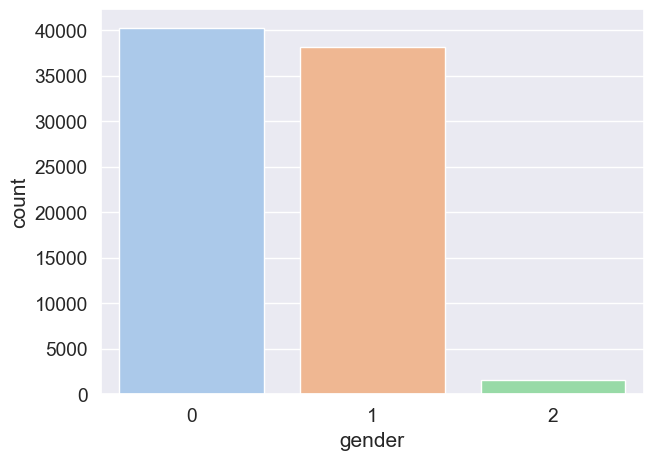

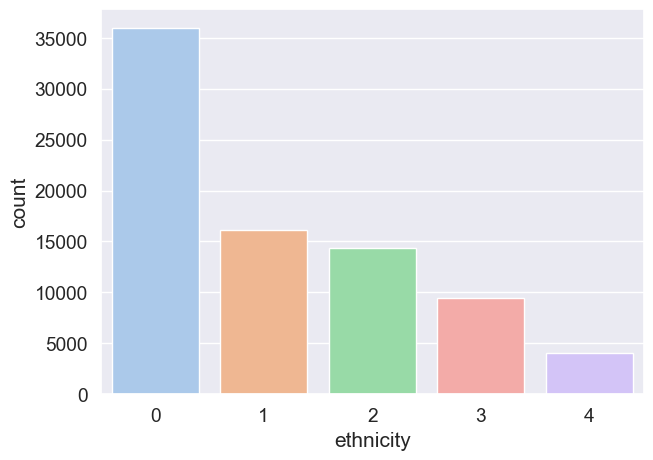

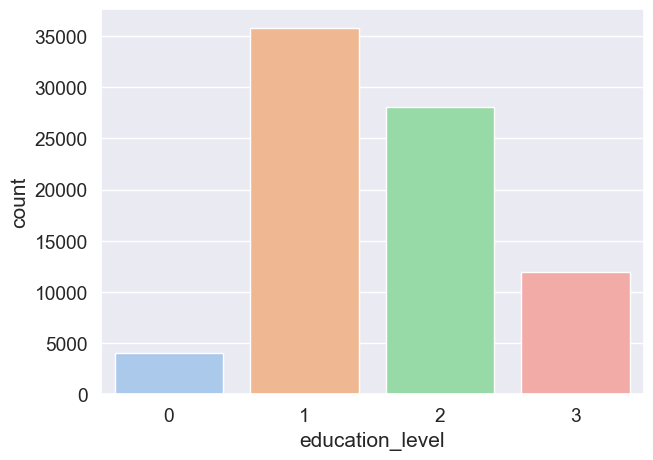

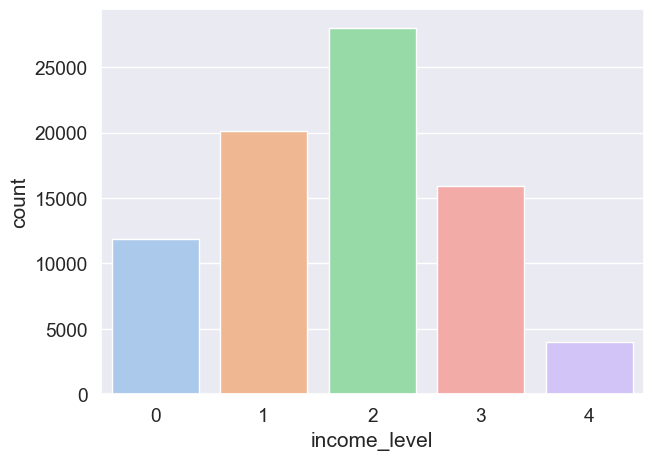

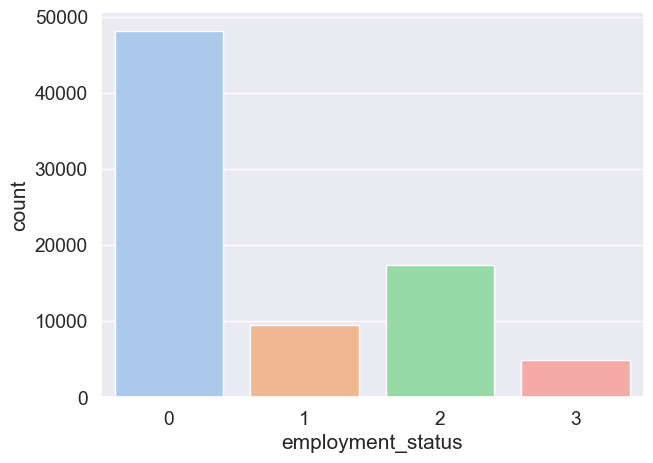

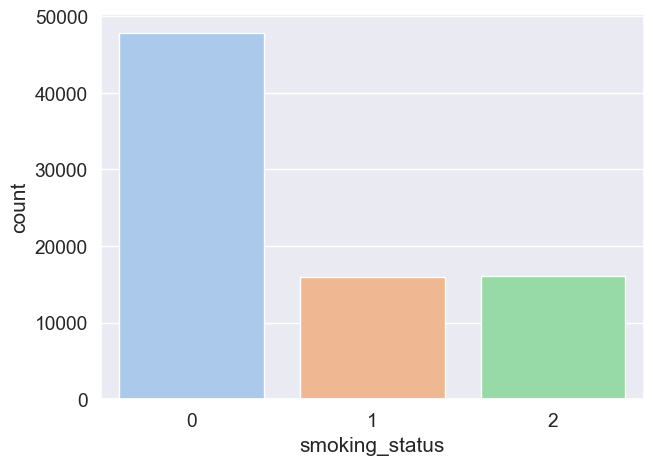

In [ ]:
#Exemplary plots for categorical variables
Col= ['gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status']
for col in Col:
    plt.figure(figsize=(7,5))
    sns.countplot(x=col,data=x_train_full, palette="pastel")
    plt.show()

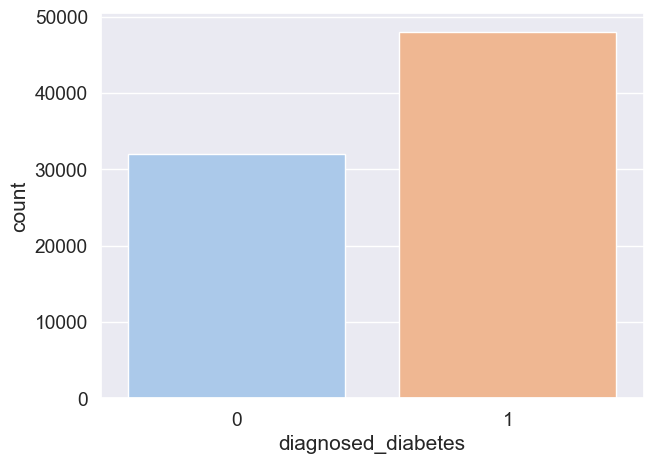

In [108]:
#Distribution of target variable
Col= ['diagnosed_diabetes']
for col in Col:
    plt.figure(figsize=(7,5))
    sns.countplot(x=col,data=y_train_full, palette="pastel")
    plt.show()

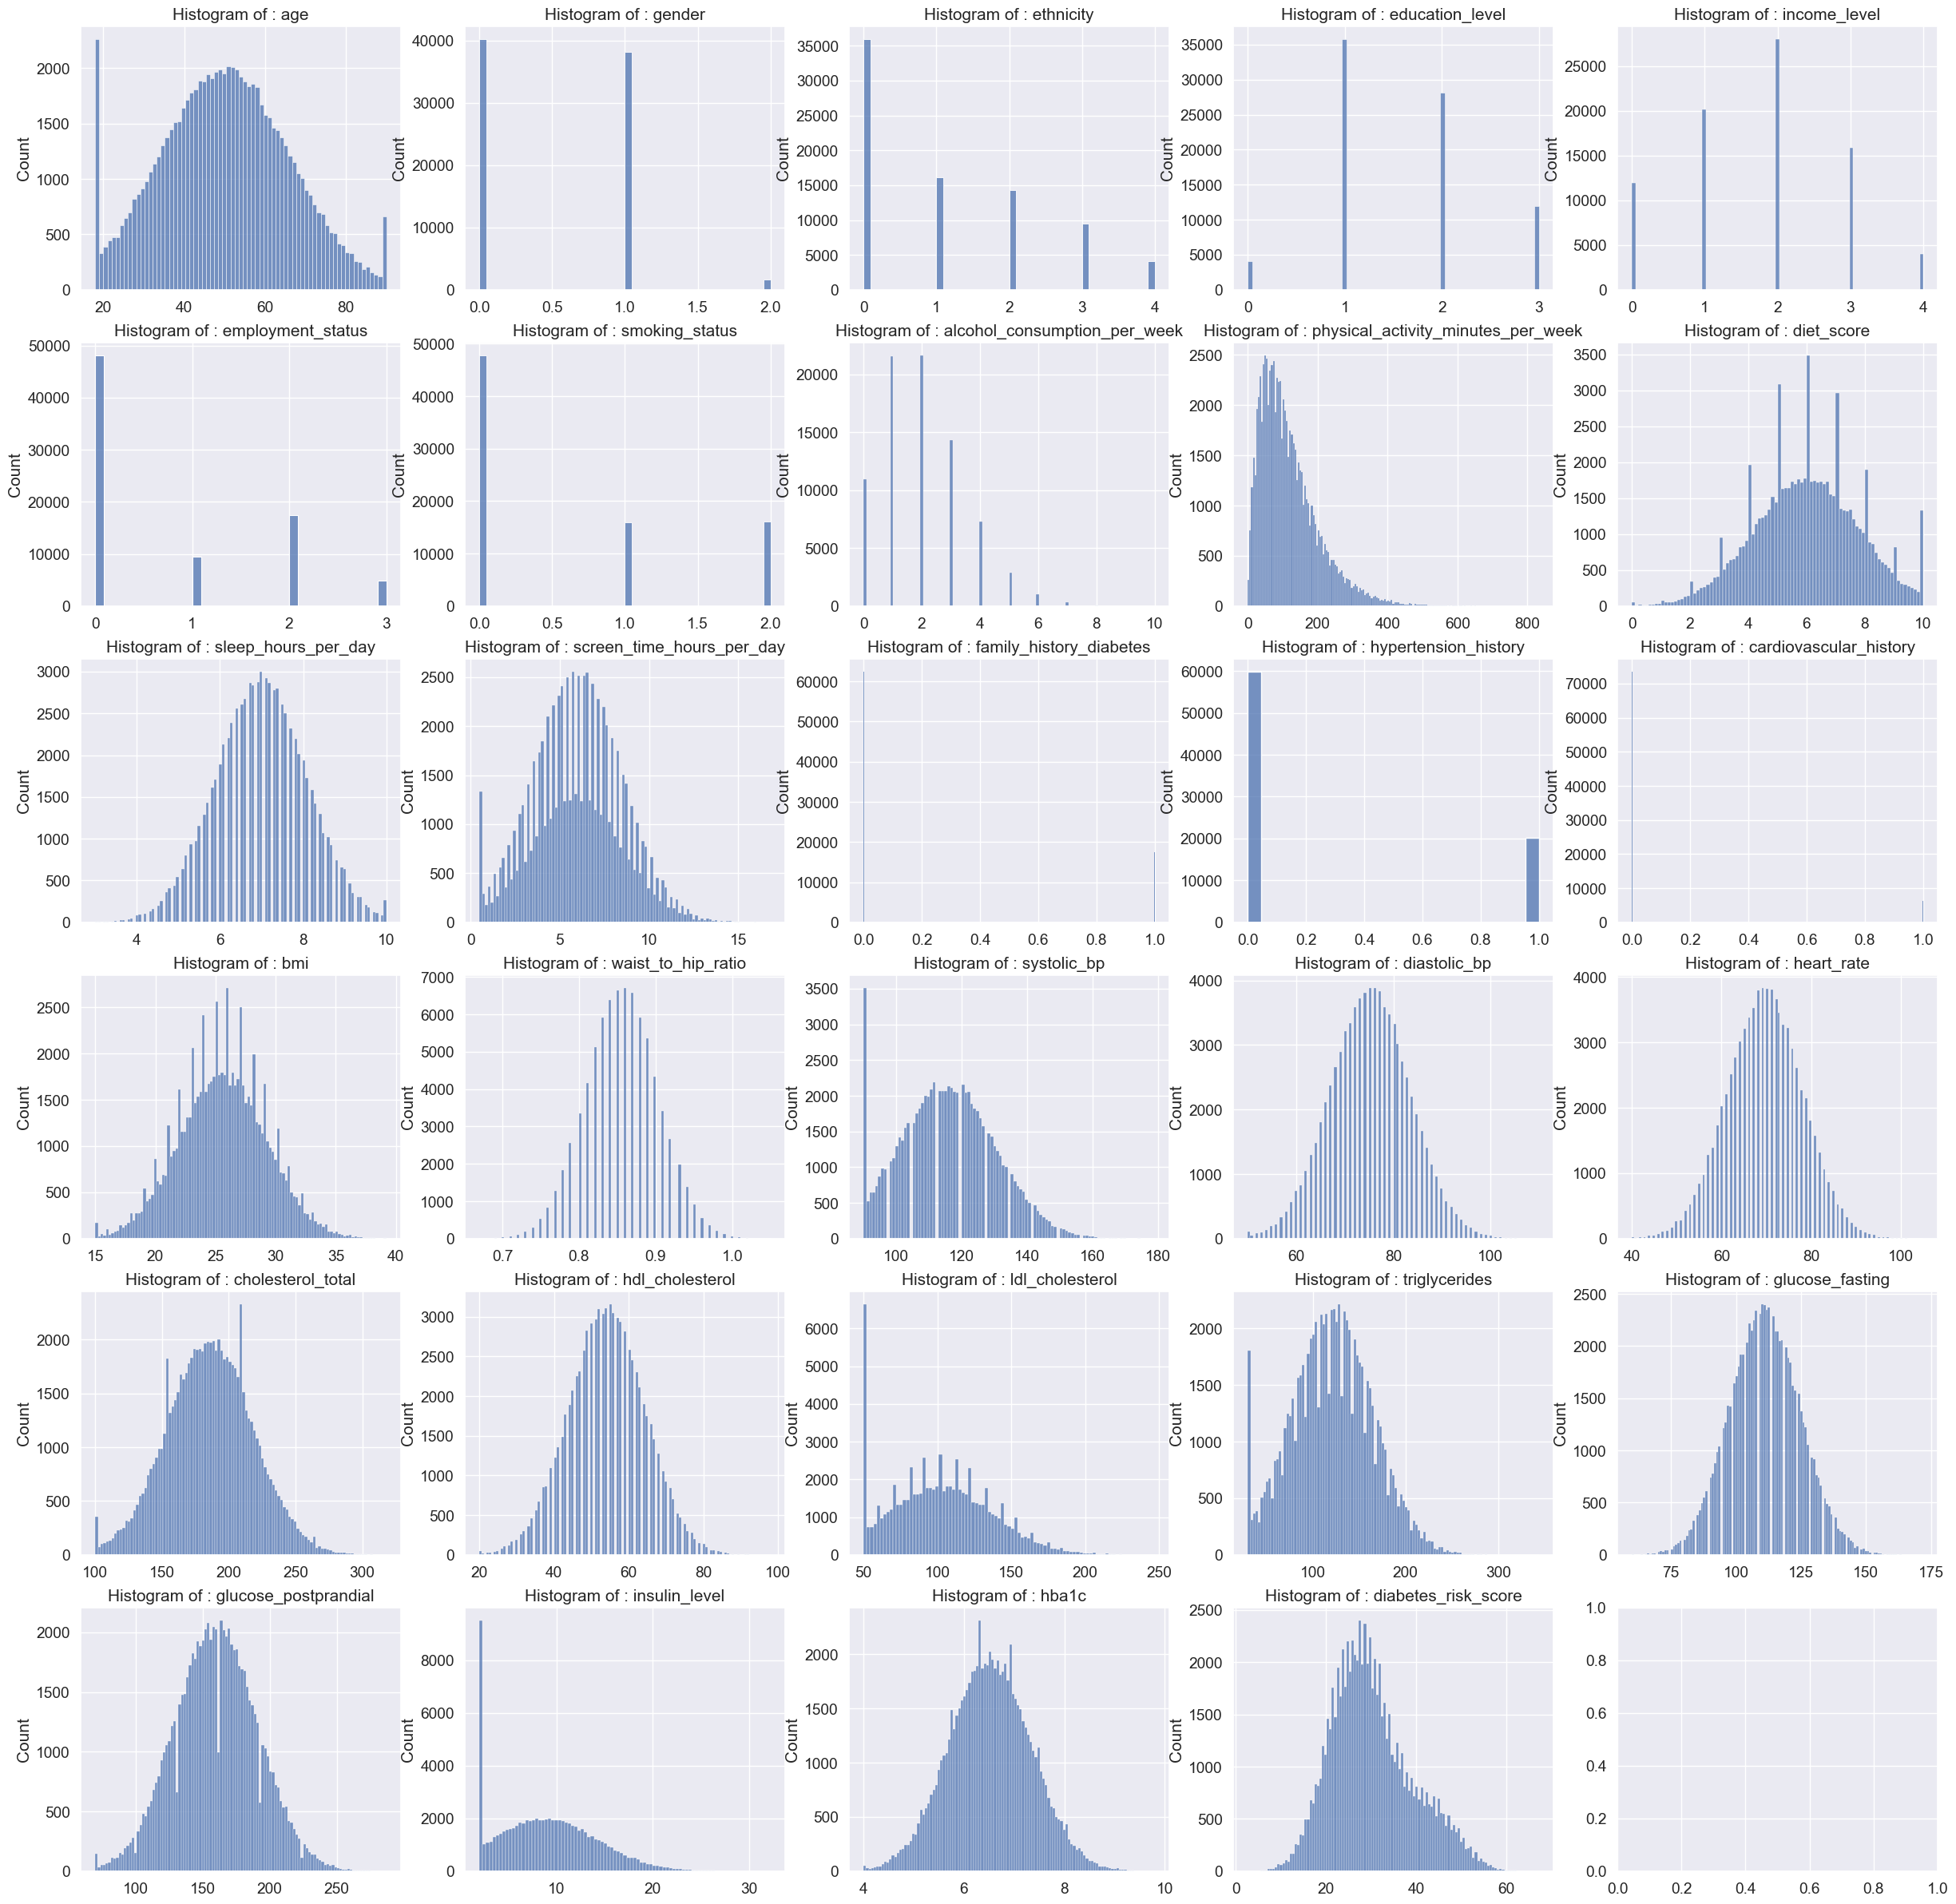

In [109]:
#Histplots of all variables
fig, axes = plt.subplots(ncols=5, nrows=6, figsize=(30, 30))
for i, ax in zip(x_train_full.columns, axes.flat):
    sns.histplot(x=x_train_full[i], ax=ax).set(title=f"Histogram of : {i}", xlabel="")
plt.show()

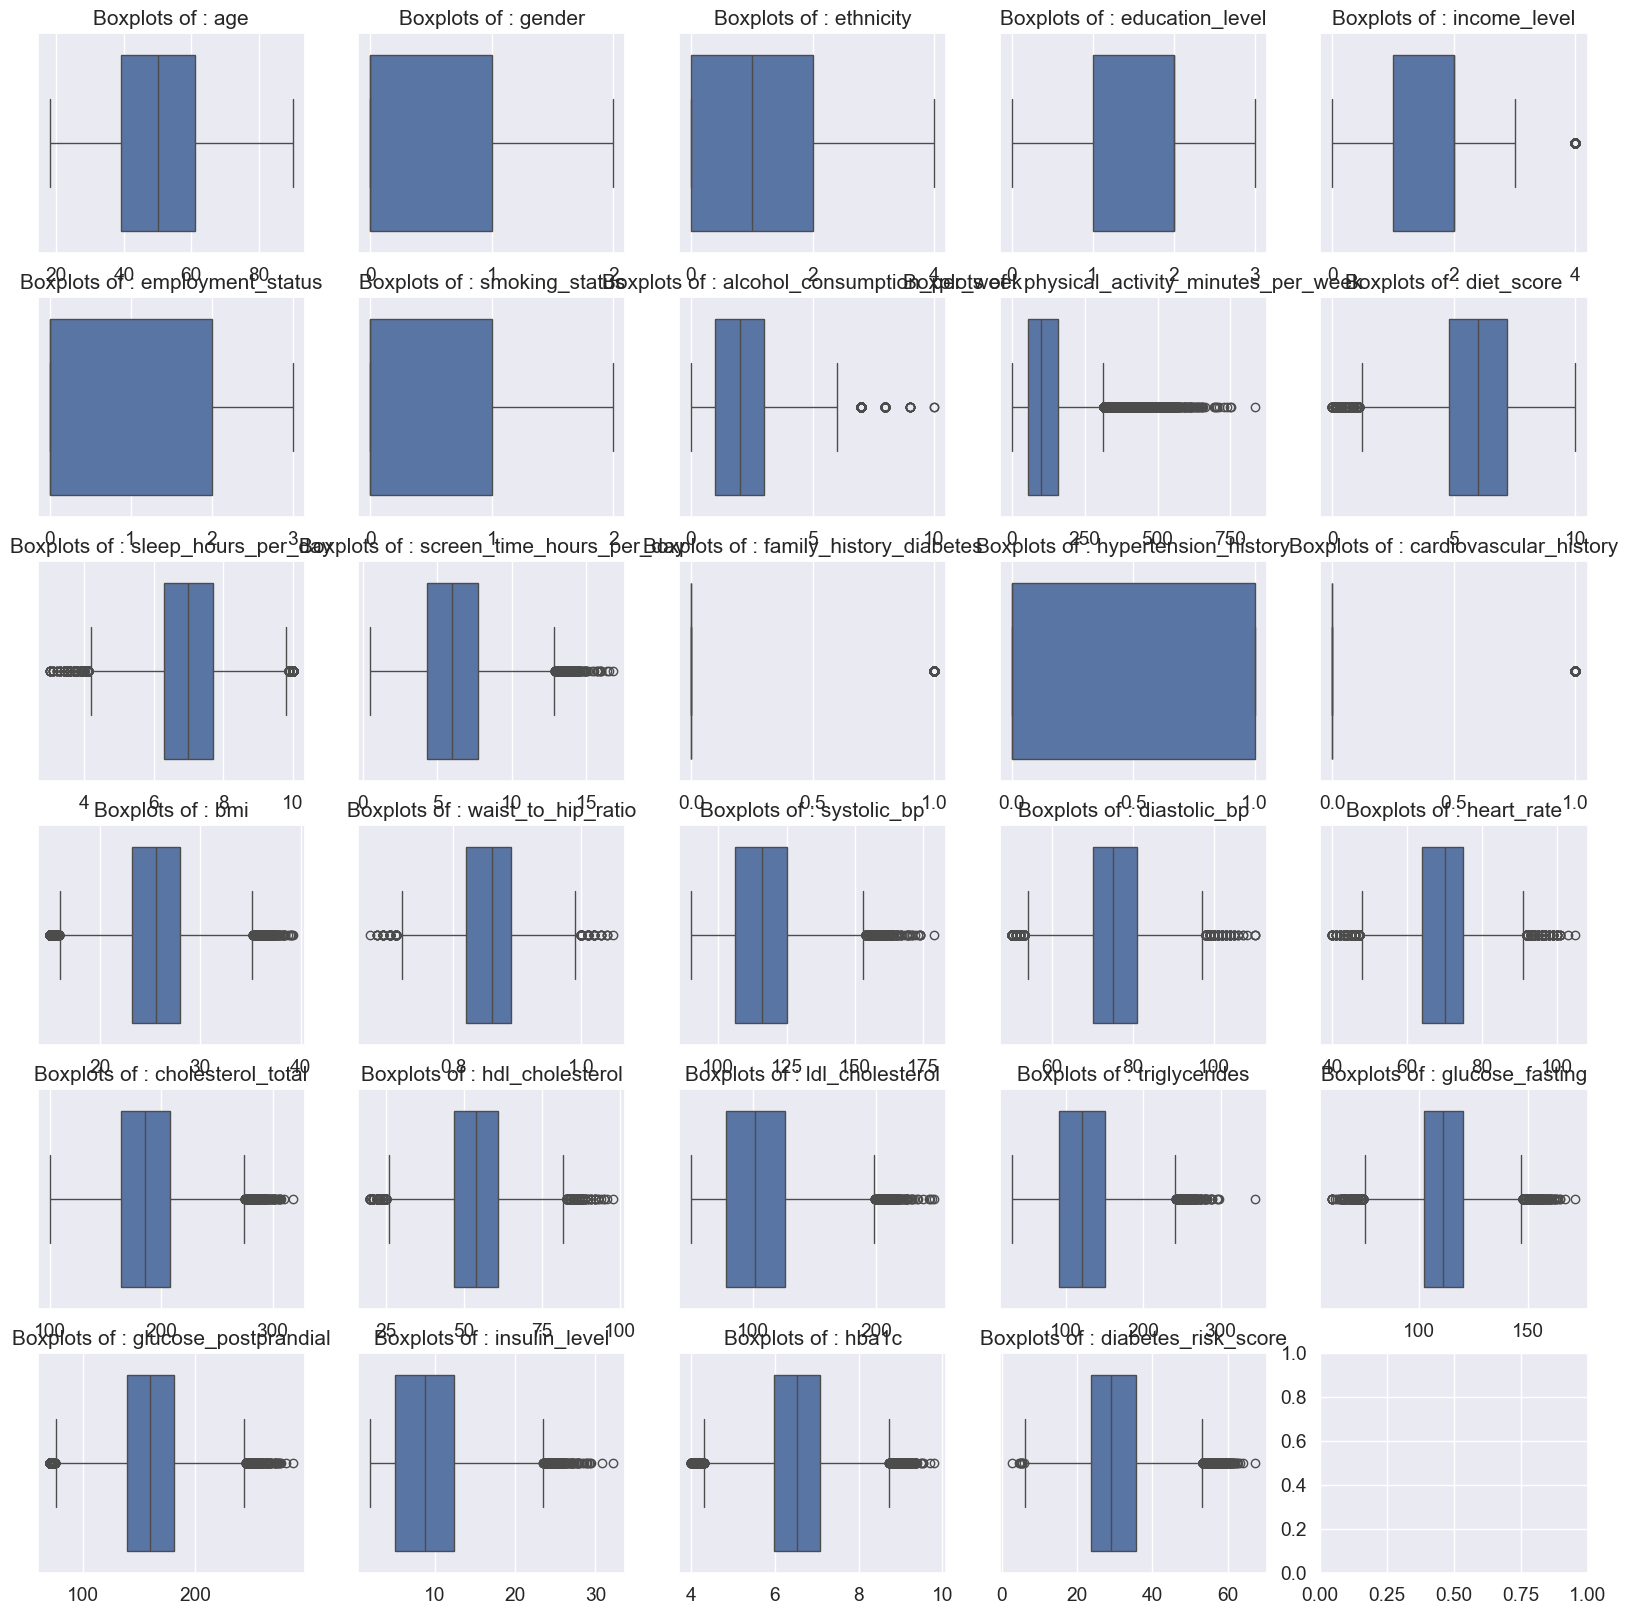

In [110]:
#Boxplots for all regressands
fig, axes = plt.subplots(ncols=5, nrows=6, figsize=(20, 20))
for i, ax in zip(x_train_full.columns, axes.flat):
    sns.boxplot(x=x_train_full[i], ax=ax).set(title=f"Boxplots of : {i}", xlabel="")
plt.show() 

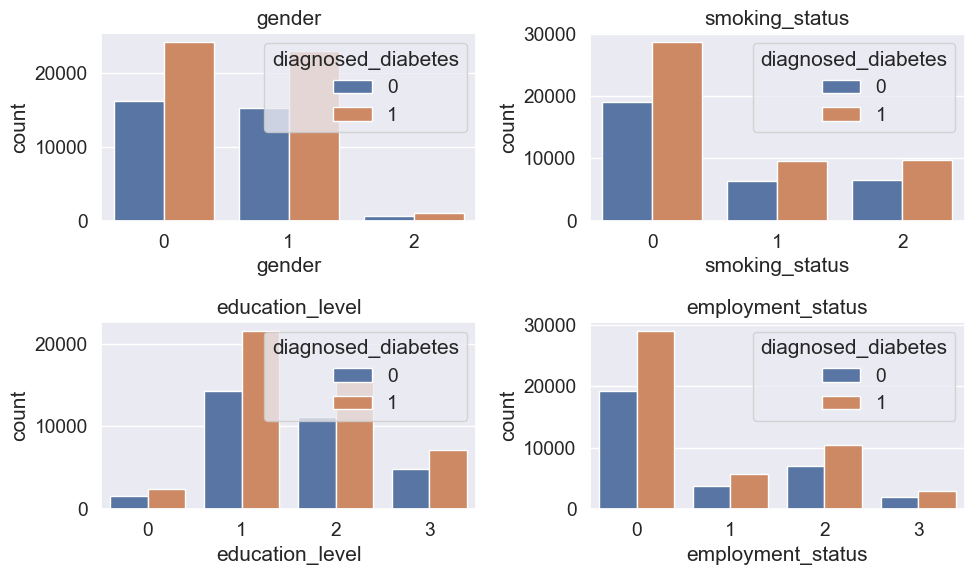

In [111]:
#Certain categorical variables regarding target distinction
my_data= ['gender', 'smoking_status','education_level', 'employment_status']
plt.figure(figsize=(10,6))
for i in range(len(my_data)):
    plt.subplot(2,2,i+1)
    plt.title(my_data[i])
    sns.countplot(x=x_train_full[my_data[i]],hue=y_train_full.diagnosed_diabetes)
plt.tight_layout() 

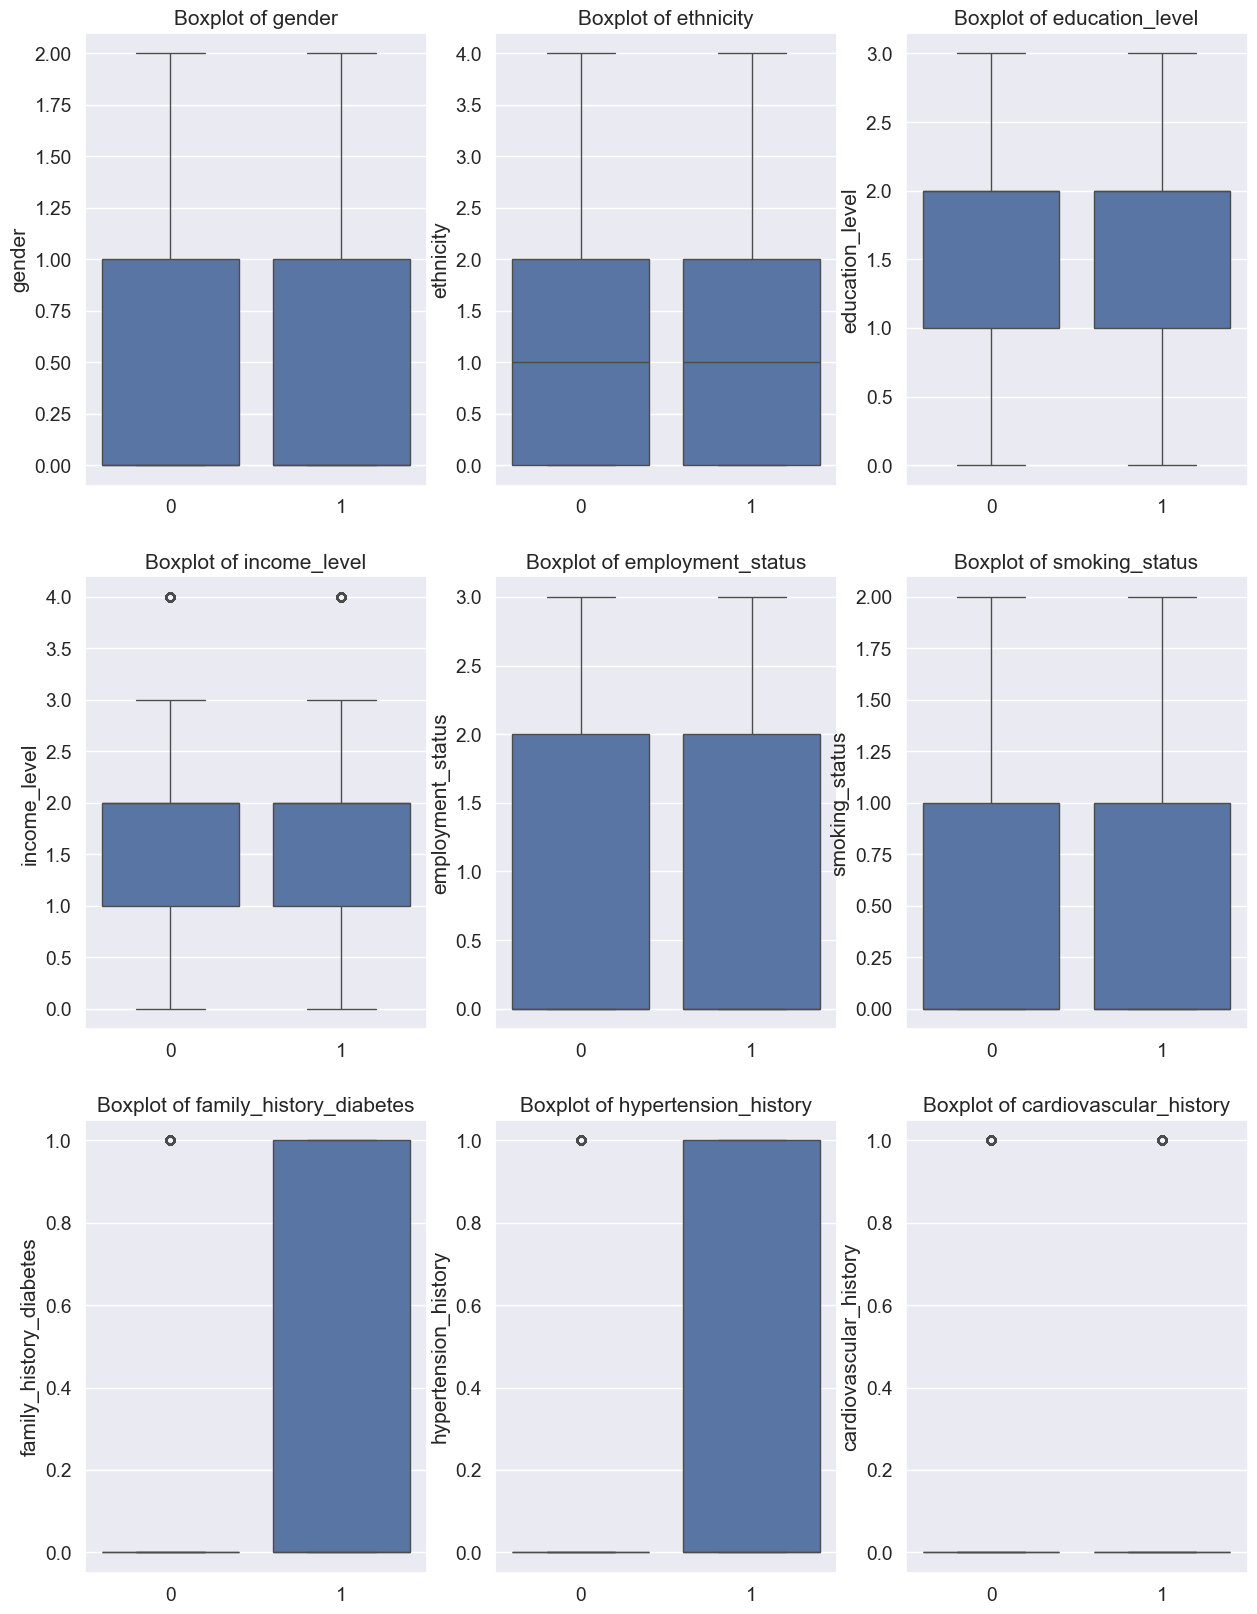

In [112]:
#Boxplots for rest of catecorical variables with division by target
categorical= ['gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15, 20))
for i, ax in zip(categorical, axes.flat):
    sns.boxplot(x=y_train_full.diagnosed_diabetes, y=x_train_full[i], ax=ax).set(title=f"Boxplot of {i}", xlabel="")
plt.show()

<Axes: xlabel='gender', ylabel='age'>

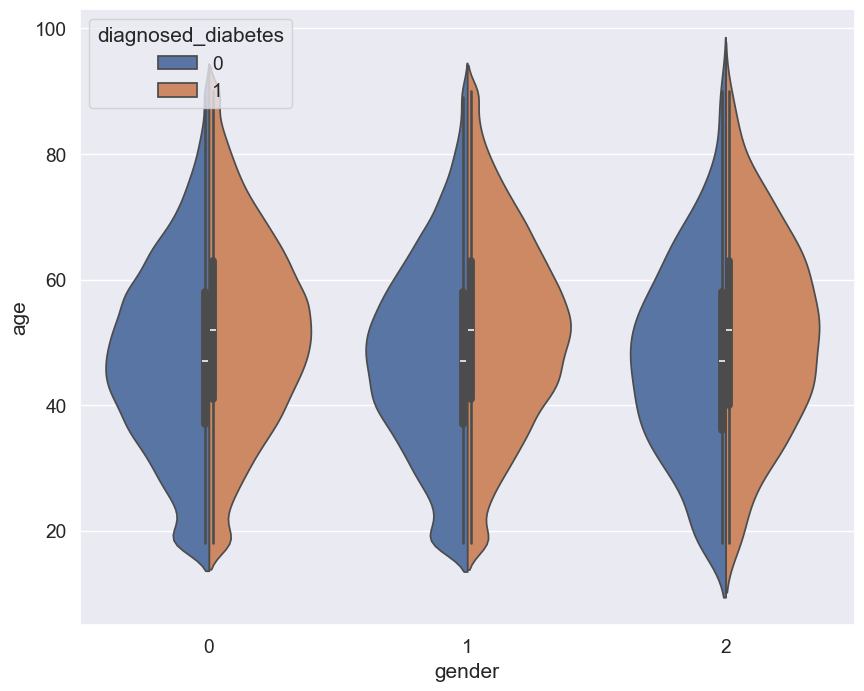

In [113]:
#Violin plot for "Age"
fig = plt.figure(figsize=(10,8))
sns.violinplot(x=x_train_full['gender'], y=x_train_full['age'], hue=y_train_full.diagnosed_diabetes,split=True)

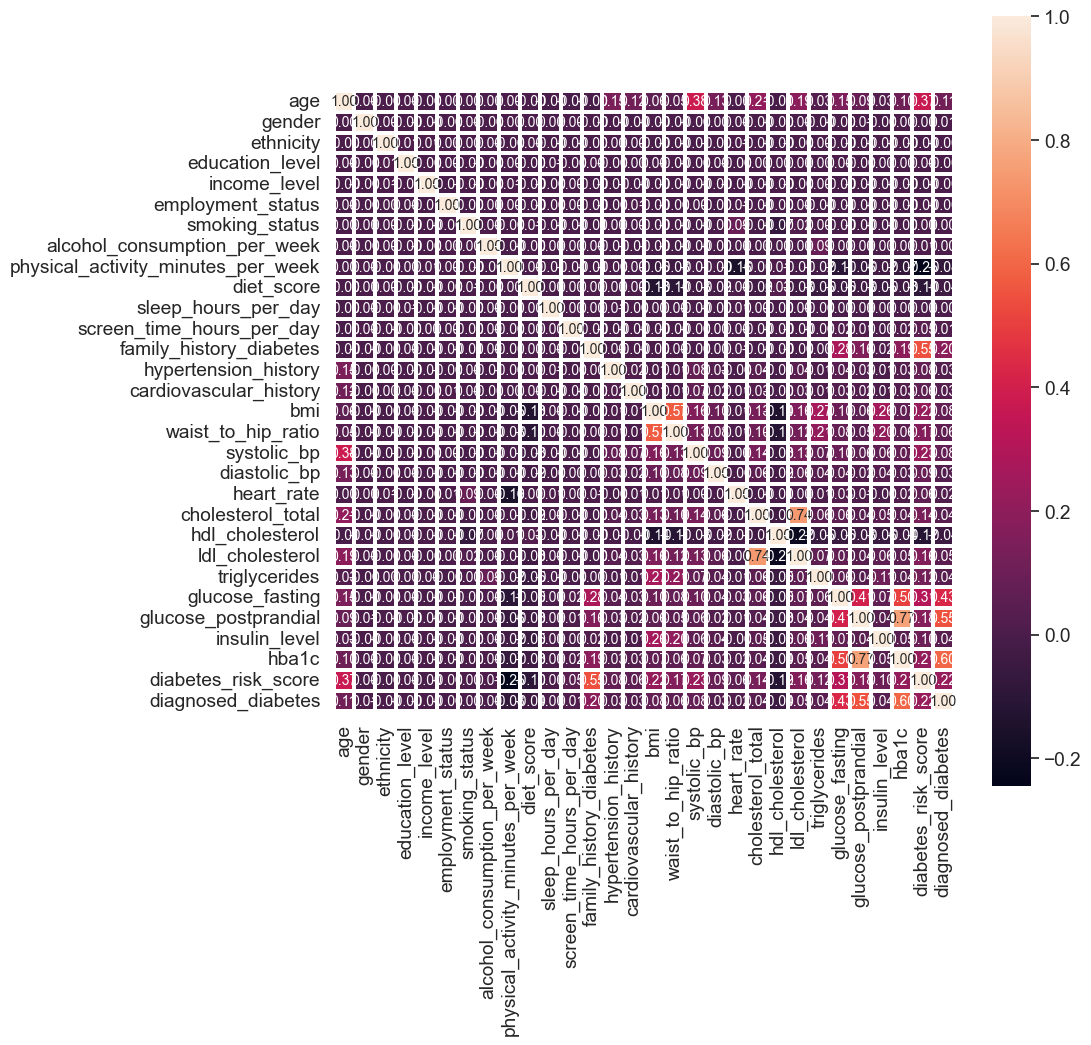

In [114]:
#Heatmap presenting correlation between features

corr = df_train.corr(method="kendall")
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(
    corr, linewidths=1.5, annot=True, square=True, fmt=".2f", annot_kws={"size": 10}
)
plt.show()

<Axes: >

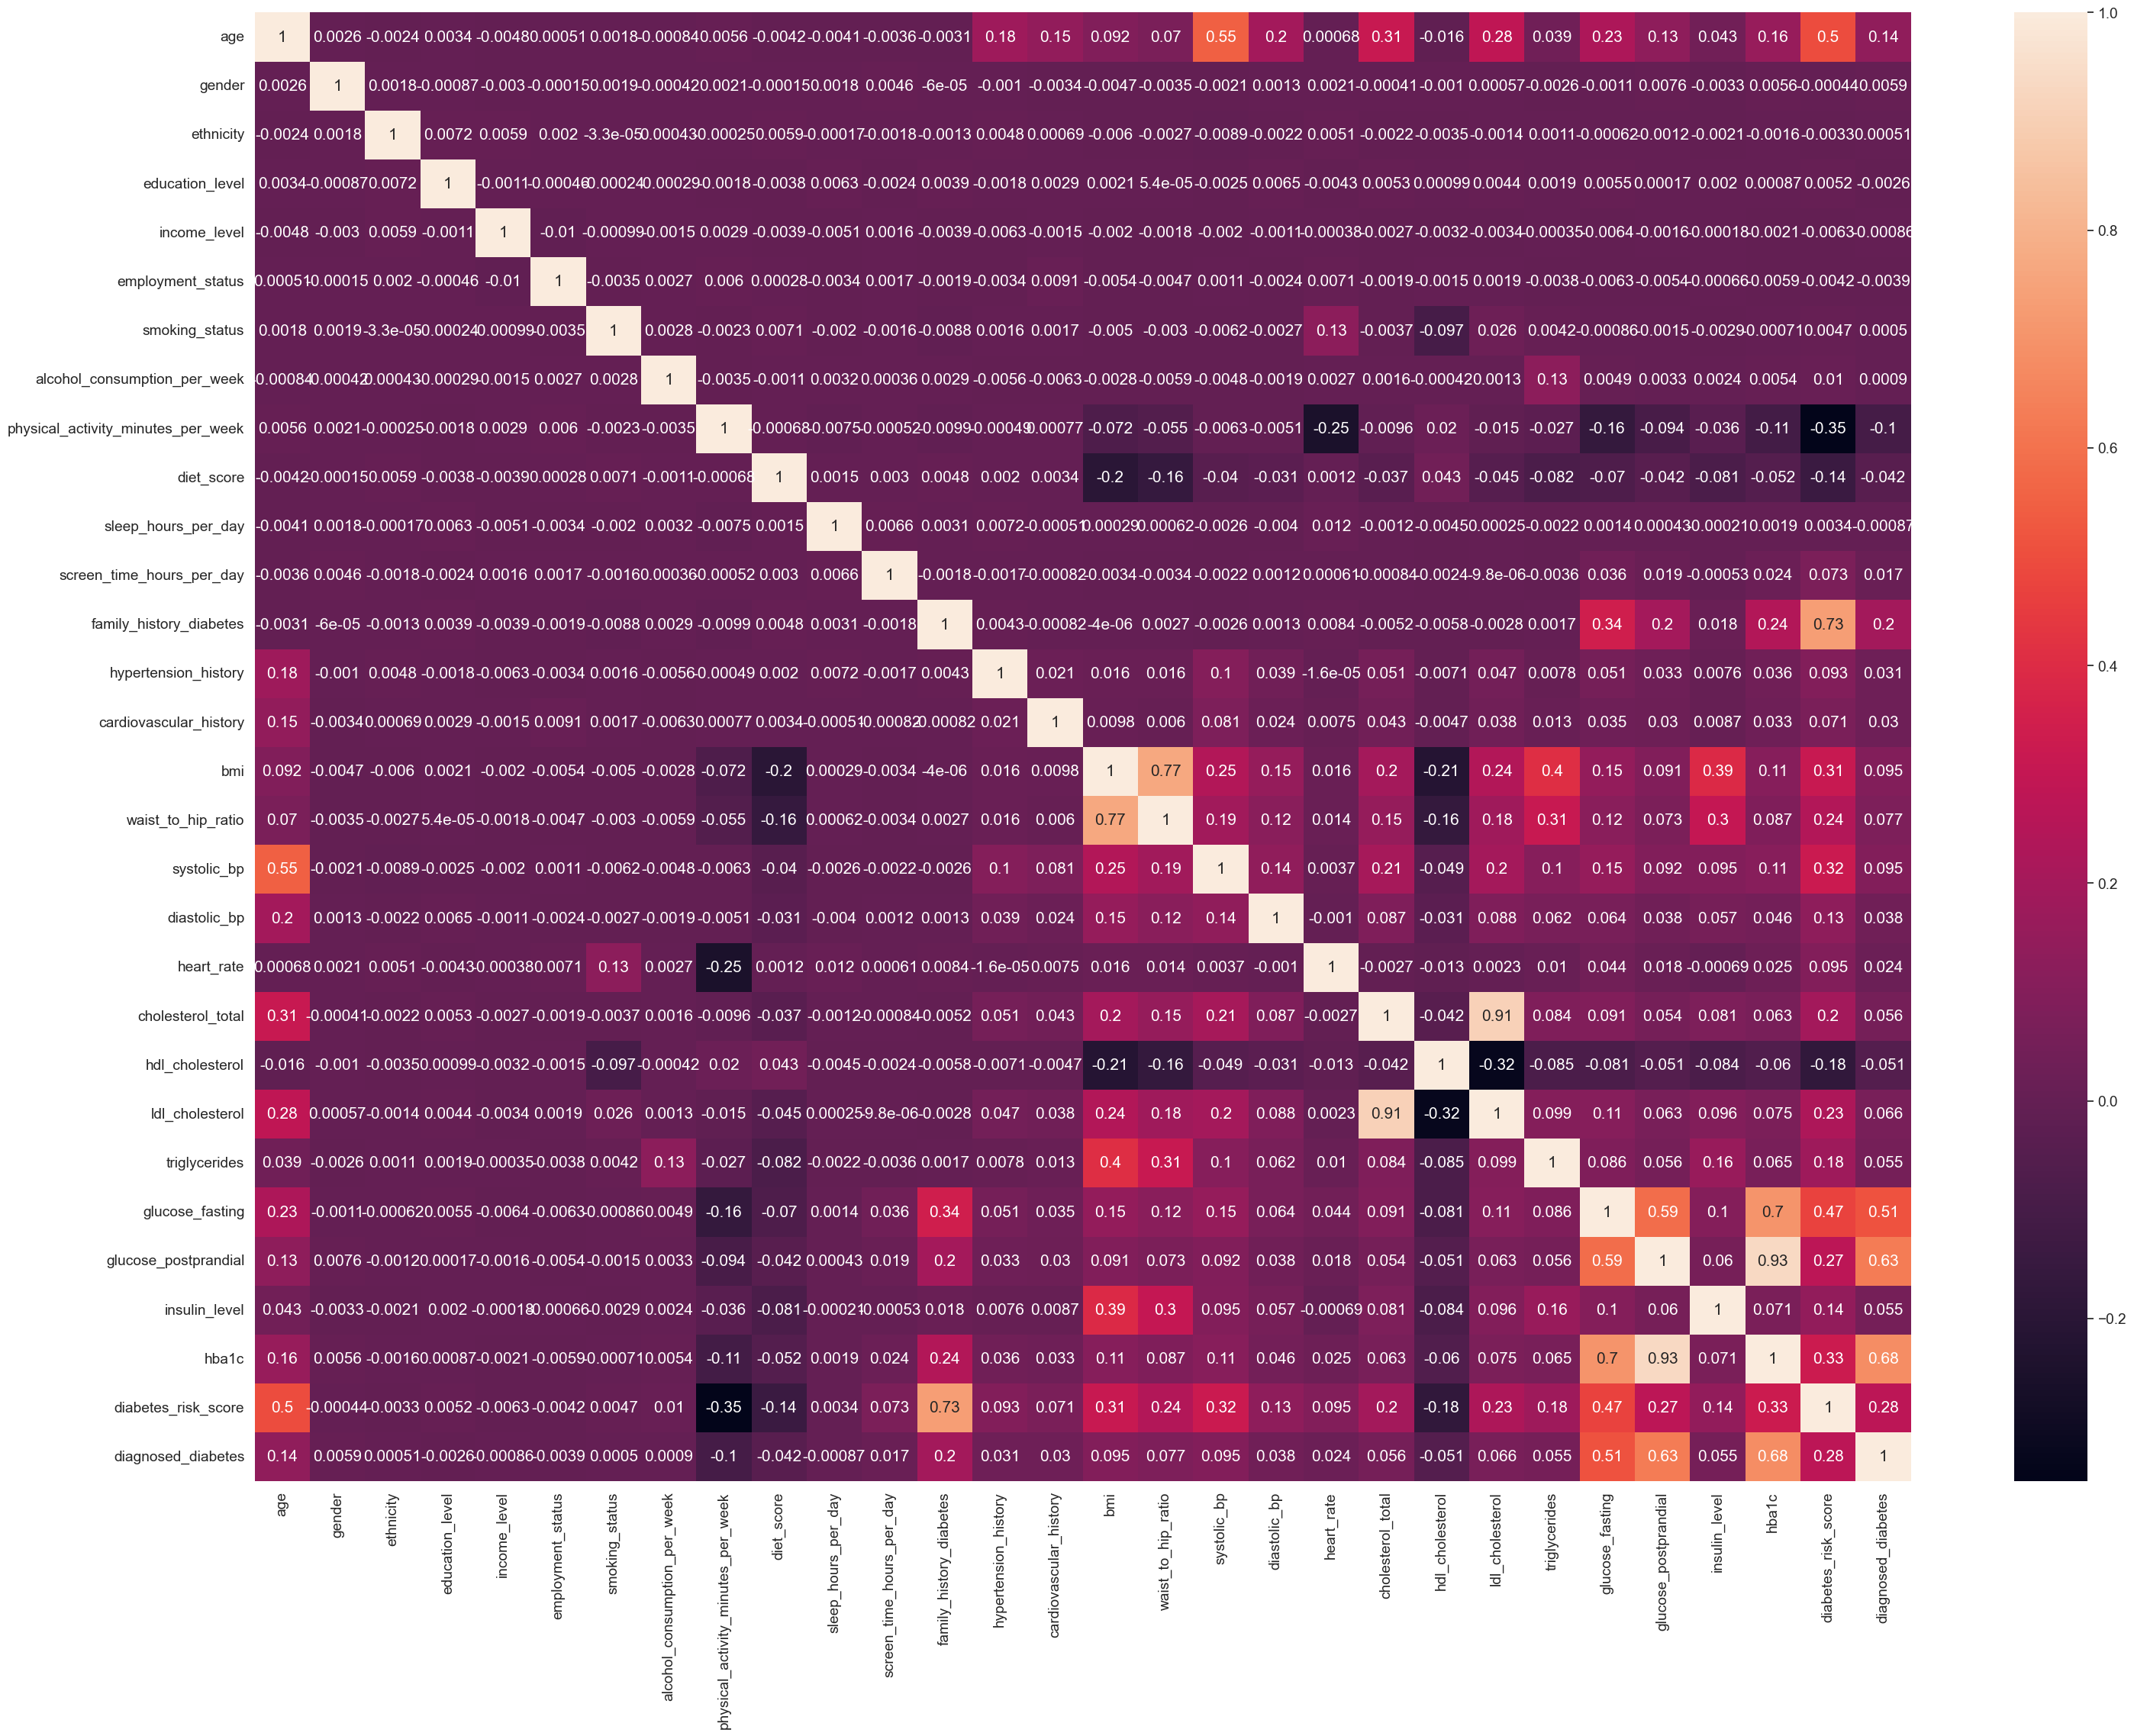

In [115]:
#Alternative way to present it
plt.figure(figsize=(35,25))
sns.heatmap(df_train.corr(), annot=True)

STATISTICAL ANALYSIS

In [116]:
#For instance, let's perform Univariate analysis of "Age" variable
sc.kurtosis(x_train_full.age, axis=0, fisher=True, keepdims=False)

np.float64(-0.3842783824743181)

In [117]:
sc.skew(x_train_full.age, axis=0, keepdims=False)

np.float64(0.08590376214899156)

(16.5, 91.5)

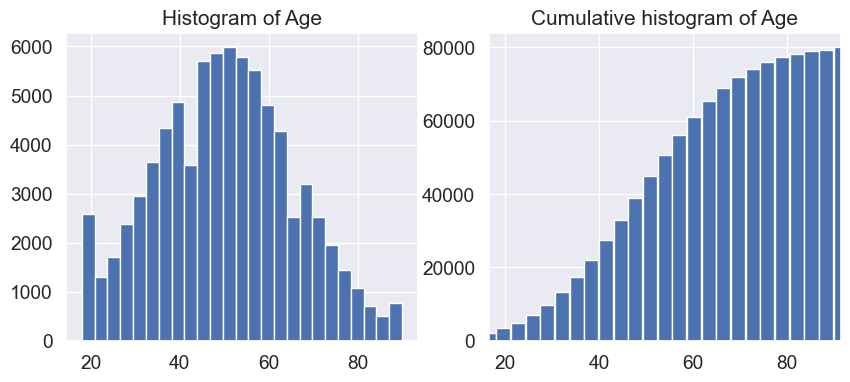

In [118]:
res = sc.cumfreq(x_train_full.age, numbins=25)
fig = plt.figure(figsize=(10, 4))
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size,
                                 res.cumcount.size)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.hist(x_train_full.age, bins=25)
ax1.set_title('Histogram of Age')
ax2.bar(x, res.cumcount, width=res.binsize)
ax2.set_title('Cumulative histogram of Age')
ax2.set_xlim([x.min(), x.max()])

In [119]:
#One-way ANOVA- H0: same mean "Age" between "Satisfaction" groups
sc.f_oneway(y_train_full.diagnosed_diabetes, x_train_full.age, axis=0) #we reject H0: different means within groups

F_onewayResult(statistic=np.float64(805303.7007093519), pvalue=np.float64(0.0))

In [120]:
#Let's see whether "Age" has normal distribution
sc.normaltest(x_train_full.age, axis=0) # no it doesn't

NormaltestResult(statistic=np.float64(865.3339161139216), pvalue=np.float64(1.244880356273036e-188))

In [121]:
#Non-parametrical one-way ANOVA (which is better due to lack of normal distribution assumption)
sc.kruskal(y_train_full.diagnosed_diabetes, x_train_full.age, axis=0) #still we reject H0: different means within groups

KruskalResult(statistic=np.float64(124362.77235029843), pvalue=np.float64(0.0))

In [122]:
#Chi-square test
sc.chisquare(x_train_full.age, axis=0) #we reject H0: data has same frequencies in particular groups

Power_divergenceResult(statistic=np.float64(388609.22585476714), pvalue=np.float64(0.0))

In [123]:
# Performing two-way ANOVA 
model = smf.ols('y_train_full.diagnosed_diabetes ~ age+gender',
            data=x_train_full).fit() 
result = sm.stats.anova_lm(model, type=2) 
  
# Print the result 
print(result)  #H1: there is a difference in mean for each variable regarding "Satisfaction" variable

               df        sum_sq     mean_sq            F    PR(>F)
age           1.0    362.898679  362.898679  1541.904579  0.000000
gender        1.0      0.590892    0.590892     2.510616  0.113086
Residual  79997.0  18827.887316    0.235357          NaN       NaN


FEATURE ENGINEERING

In [99]:
#Na razie pozostawiam bez zmian, tu pomyślimy nad transformacjami i można ewentualnie dataframe downsize z ML1

df_train.to_csv("data/output/data_train.csv", index=True)
df_test.to_csv("data/output/data_test.csv", index=True)

FEATURE RANKING AND SELECTION

In [28]:
x_col = ['age','gender','ethnicity','education_level','income_level','employment_status',
         'smoking_status','alcohol_consumption_per_week','physical_activity_minutes_per_week',
         'diet_score','sleep_hours_per_day','screen_time_hours_per_day','family_history_diabetes',
         'hypertension_history','cardiovascular_history','bmi','waist_to_hip_ratio','systolic_bp',
         'diastolic_bp','heart_rate','cholesterol_total','hdl_cholesterol','ldl_cholesterol',
         'triglycerides','glucose_fasting','glucose_postprandial','insulin_level','hba1c',
         'diabetes_risk_score']
y_col = 'diagnosed_diabetes'

In [29]:
general_ranking = pd.DataFrame(index=x_col)

In [30]:
sel = VarianceThreshold(0.01)
sel_var = sel.fit_transform(df_train[x_col])
col_imp = df_train[x_col][df_train[x_col].columns[sel.get_support(indices=True)]].columns
col_redundant = set(df_train[x_col].columns.tolist()) - set(col_imp)

In [ ]:
col_redundant #potentially statistically insignificant feature

{'waist_to_hip_ratio'}

In [32]:
#Feature ranking basing on mutual information
mi = dict()
for i in x_col:
    mi.update({i: mutual_info_classif(df_train[[i]].values, df_train[y_col].values)[0]}) #mutual_info_classif instead of mutual_info_regression due to classification task

miDF = pd.DataFrame.from_dict(mi, orient="index", columns=["score"])

general_ranking = pd.merge(general_ranking, miDF, left_index=True, right_index=True)

general_ranking.rename(columns={"score": "mi_score"}, inplace=True)

In [33]:
miDF.sort_values(by="score", ascending=False).head(10)

score
hba1c                               0.443568
glucose_postprandial                0.285722
glucose_fasting                     0.162293
diabetes_risk_score                 0.039481
family_history_diabetes             0.026809
age                                 0.008669
physical_activity_minutes_per_week  0.005861
gender                              0.005076
education_level                     0.004133
income_level                        0.003854

In [35]:
#Feature ranking basing on F-score
fscore = dict()
for i in x_col:
    fscore.update({i: f_classif(df_train[[i]].values, df_train[y_col].values)[1]})

fscoreDF = pd.DataFrame.from_dict(fscore, orient="index", columns=["p_value_score"])
fscoreDF["sign"] = np.where(fscoreDF.p_value_score < 0.05, 1, 0)

general_ranking = pd.merge(general_ranking, fscoreDF, left_index=True, right_index=True)
general_ranking.rename(
    columns={"p_value_score": "sign_fscore", "sign": "sign_fscore_0_1"}, inplace=True
)

In [36]:
fscoreDF.sort_values(by="p_value_score", ascending=False).head(10)

p_value_score  sign
smoking_status                 8.865326e-01     0
ethnicity                      8.852822e-01     0
income_level                   8.069431e-01     0
sleep_hours_per_day            8.050055e-01     0
alcohol_consumption_per_week   7.999546e-01     0
education_level                4.606065e-01     0
employment_status              2.658985e-01     0
gender                         9.500217e-02     0
screen_time_hours_per_day      1.199241e-06     1
heart_rate                     1.107980e-11     1

In [ ]:
#Feature ranking basing on Spearman correlation coefficient
corr = list()
for i in x_col:
    corr.append(sc.spearmanr(df_train.loc[:, y_col].values, df_train.loc[:, i].values)[0])

general_ranking = pd.merge(
    general_ranking,
    pd.DataFrame(corr, index=x_col, columns=["corr"]),
    left_index=True,
    right_index=True,
)

In [38]:
general_ranking.sort_values(by="corr", ascending=False).head(10)

mi_score    sign_fscore  sign_fscore_0_1      corr
hba1c                    0.443568   0.000000e+00                1  0.733615
glucose_postprandial     0.285722   0.000000e+00                1  0.668704
glucose_fasting          0.162293   0.000000e+00                1  0.522932
diabetes_risk_score      0.039481   0.000000e+00                1  0.272248
family_history_diabetes  0.026809   0.000000e+00                1  0.196168
age                      0.008669   0.000000e+00                1  0.135372
systolic_bp              0.002781  2.808740e-159                1  0.094124
bmi                      0.002837  1.733819e-159                1  0.093814
waist_to_hip_ratio       0.001785  2.095636e-106                1  0.076019
ldl_cholesterol          0.001752   7.933269e-78                1  0.064473

In [44]:
#Feature ranking basing on Boruta ranking
rf = RandomForestClassifier(n_jobs=-1, max_depth=5)

feat_selector = bp(rf, n_estimators="auto", verbose=0, max_iter=100)
feat_selector.fit(df_train.loc[:, x_col].values, df_train.loc[:, y_col].values.ravel())

BorutaPy(estimator=RandomForestClassifier(max_depth=5, n_estimators=120,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x285F3B13C40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x285F3B13C40)

In [45]:
feat_selector.ranking_

array([ 1, 12,  8,  8, 11, 10, 12,  7,  1,  1,  4,  2,  1,  5,  6,  1,  1,
        1,  1,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [46]:
boruta_DF = pd.DataFrame(index=x_col)
boruta_DF["boruta_rank"] = feat_selector.ranking_

In [47]:
general_ranking = pd.merge(
    general_ranking, boruta_DF, left_index=True, right_index=True, how="left"
)

Text(0.5, 1.0, 'Coefficients in the Elastic Net Model')

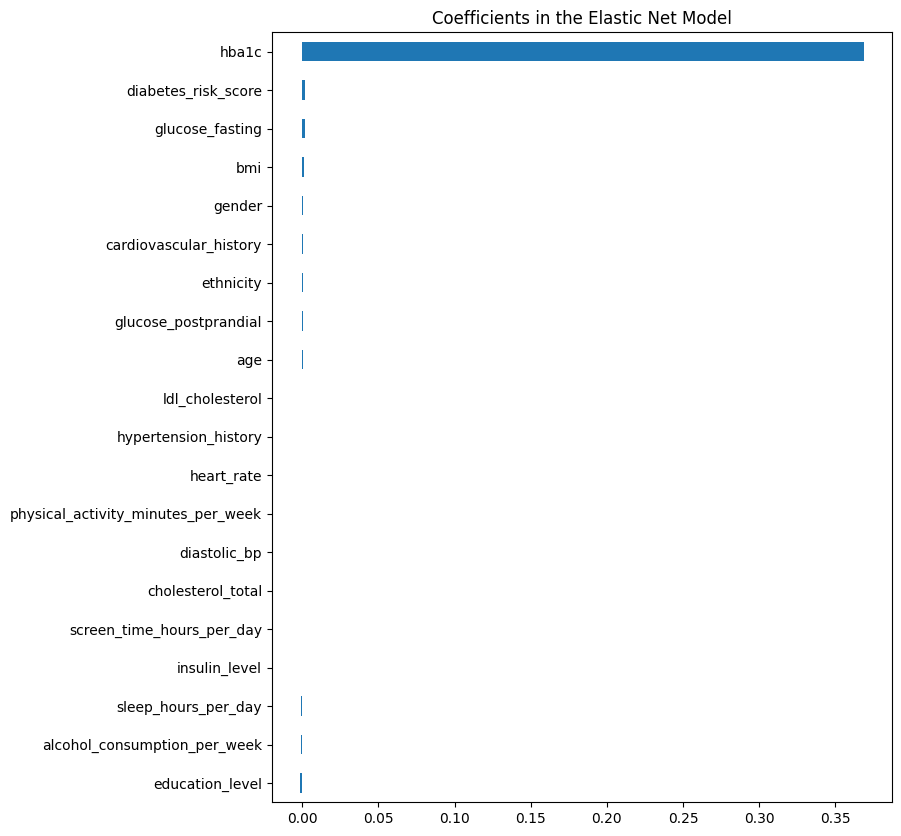

In [ ]:
#We create the Elastic Net model to check the coefficients of the variables

en_res = pd.DataFrame(index=x_col)

def rmse_cv(model, df_train, x_col, y_col):
    rmse = np.sqrt(
        -cross_val_score(
            model,
            df_train.loc[:, x_col],
            df_train.loc[:, y_col],
            scoring="neg_mean_squared_error",
            cv=5,
        )
    )
    return rmse

alphas = [0.0005, 0.001, 0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
l1_ratios = [1, 0.9, 0.8, 0.7, 0.5, 0.4, 0.3]

cv_elastic = [
    rmse_cv(ElasticNet(alpha=alpha, l1_ratio=l1_ratio), df_train, x_col, y_col).mean()
    for (alpha, l1_ratio) in product(alphas, l1_ratios)
]

elastic = ElasticNet(alpha=0.0005, l1_ratio=1)
elastic.fit(df_train.loc[:, x_col], df_train.loc[:, y_col])

coef = pd.Series(elastic.coef_, index=df_train.loc[:, x_col].columns)
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

plt.rcParams["figure.figsize"] = (8.0, 10.0)
imp_coef.plot(kind="barh")
plt.title("Coefficients in the Elastic Net Model")

#Coś jest nie tak- może RMSE tu nie pasuje? Do sprawdzenia później

In [48]:
#Summary of feature ranking
general_ranking.sort_values(["mi_score", "boruta_rank", "corr"], ascending=False)

mi_score    sign_fscore  sign_fscore_0_1  \
hba1c                               0.443568   0.000000e+00                1   
glucose_postprandial                0.285722   0.000000e+00                1   
glucose_fasting                     0.162293   0.000000e+00                1   
diabetes_risk_score                 0.039481   0.000000e+00                1   
family_history_diabetes             0.026809   0.000000e+00                1   
age                                 0.008669   0.000000e+00                1   
physical_activity_minutes_per_week  0.005861  1.630864e-188                1   
gender                              0.005076   9.500217e-02                0   
education_level                     0.004133   4.606065e-01                0   
income_level                        0.003854   8.069431e-01                0   
hypertension_history                0.003481   2.651392e-18                1   
alcohol_consumption_per_week        0.003298   7.999546e-01                0   
smoking_status                      0.003047   8.865326e-01                0   
bmi                                 0.002837  1.733819e-159                1   
systolic_bp                         0.002781  2.808740e-159                1   
triglycerides                       0.001821   1.770180e-54                1   
waist_to_hip_ratio                  0.001785  2.095636e-106                1   
ldl_cholesterol                     0.001752   7.933269e-78                1   
diet_score                          0.001647   4.073836e-33                1   
insulin_level                       0.001520   8.825013e-54                1   
heart_rate                          0.001169   1.107980e-11                1   
diastolic_bp                        0.000836   2.326763e-27                1   
hdl_cholesterol                     0.000483   2.731544e-47                1   
ethnicity                           0.000432   8.852822e-01                0   
screen_time_hours_per_day           0.000199   1.199241e-06                1   
employment_status                   0.000000   2.658985e-01                0   
cardiovascular_history              0.000000   2.890044e-17                1   
sleep_hours_per_day                 0.000000   8.050055e-01                0   
cholesterol_total                   0.000000   1.780108e-56                1   

                                        corr  boruta_rank  
hba1c                               0.733615            1  
glucose_postprandial                0.668704            1  
glucose_fasting                     0.522932            1  
diabetes_risk_score                 0.272248            1  
family_history_diabetes             0.196168            1  
age                                 0.135372            1  
physical_activity_minutes_per_week -0.096677            1  
gender                              0.005279           12  
education_level                    -0.002074            8  
income_level                       -0.001408           11  
hypertension_history                0.030842            5  
alcohol_consumption_per_week        0.001701            7  
smoking_status                      0.000659           12  
bmi                                 0.093814            1  
systolic_bp                         0.094124            1  
triglycerides                       0.054611            1  
waist_to_hip_ratio                  0.076019            1  
ldl_cholesterol                     0.064473            1  
diet_score                         -0.042587            1  
insulin_level                       0.053778            1  
heart_rate                          0.023087            3  
diastolic_bp                        0.037523            1  
hdl_cholesterol                    -0.051403            1  
ethnicity                          -0.000697            8  
screen_time_hours_per_day           0.017503            2  
employment_status                  -0.003825           10  
cardiovascular_

In [49]:
#Saving into external csv file
general_ranking.to_csv("data/output/general_ranking.csv")

ENSEMBLE METHODS MODELING

In [ ]:
#Komentarze i myśli dla tej części

# 1) Dodać modele z rolling window (będziesz musiał zrobić, pominięte w assignmencie)

# 2) Przepuścić kod jeszcze raz, małe zmiany nazw w formułach

# 3) Wartości metryk: dać 6 miejsc po przecinku może, zmiany czasami marginalne

In [9]:
#Data loading

df = pd.read_csv("data/output/data_train.csv", index_col=0)
df_test= pd.read_csv("data/output/data_test.csv", index_col=0)
fr = pd.read_csv("data/output/general_ranking.csv", index_col=0)

In [10]:
df.info() # 'diagnosed_diabetes' is the target variable

<class 'pandas.core.frame.DataFrame'>
Index: 80000 entries, 22302 to 15725
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age                                 80000 non-null  int64  
 1   gender                              80000 non-null  int64  
 2   ethnicity                           80000 non-null  int64  
 3   education_level                     80000 non-null  int64  
 4   income_level                        80000 non-null  int64  
 5   employment_status                   80000 non-null  int64  
 6   smoking_status                      80000 non-null  int64  
 7   alcohol_consumption_per_week        80000 non-null  int64  
 8   physical_activity_minutes_per_week  80000 non-null  int64  
 9   diet_score                          80000 non-null  float64
 10  sleep_hours_per_day                 80000 non-null  float64
 11  screen_time_hours_per_day           80000 

In [12]:
#Feature selection basing on Boruta ranking (top 10 features)
fr.sort_values("boruta_rank", ascending=True, inplace=True)
fr.head(10)

mi_score    sign_fscore  sign_fscore_0_1  \
age                                 0.008669   0.000000e+00                1   
bmi                                 0.002837  1.733819e-159                1   
diet_score                          0.001647   4.073836e-33                1   
physical_activity_minutes_per_week  0.005861  1.630864e-188                1   
family_history_diabetes             0.026809   0.000000e+00                1   
insulin_level                       0.001520   8.825013e-54                1   
glucose_postprandial                0.285722   0.000000e+00                1   
diabetes_risk_score                 0.039481   0.000000e+00                1   
glucose_fasting                     0.162293   0.000000e+00                1   
triglycerides                       0.001821   1.770180e-54                1   

                                        corr  boruta_rank  
age                                 0.135372            1  
bmi                                 0.093814            1  
diet_score                         -0.042587            1  
physical_activity_minutes_per_week -0.096677            1  
family_history_diabetes             0.196168            1  
insulin_level                       0.053778            1  
glucose_postprandial                0.668704            1  
diabetes_risk_score                 0.272248            1  
glucose_fasting                     0.522932            1  
triglycerides                       0.054611            1

In [13]:
br_features = fr[fr.boruta_rank.isin([1, 2, 3])].index.tolist() #Highest 1-3 ranks (19 variables)
print(br_features)

['age', 'bmi', 'diet_score', 'physical_activity_minutes_per_week', 'family_history_diabetes', 'insulin_level', 'glucose_postprandial', 'diabetes_risk_score', 'glucose_fasting', 'triglycerides', 'hdl_cholesterol', 'ldl_cholesterol', 'cholesterol_total', 'diastolic_bp', 'systolic_bp', 'waist_to_hip_ratio', 'hba1c', 'screen_time_hours_per_day', 'heart_rate']


In [14]:
# We will train different models, basing therefor on top 10, 20 and 25 Boruta features
br_features10 = fr.boruta_rank.sort_values(ascending=True).index.tolist()[0:10]
br_features20 = fr.boruta_rank.sort_values(ascending=True).index.tolist()[0:20]
br_features25 = fr.boruta_rank.sort_values(ascending=True).index.tolist()[0:25]

In [105]:
print(br_features10)

['age', 'bmi', 'diet_score', 'physical_activity_minutes_per_week', 'family_history_diabetes', 'insulin_level', 'glucose_postprandial', 'diabetes_risk_score', 'glucose_fasting', 'triglycerides']


## HYPERPARAMETER TUNING

### a) AdaBoost Classifier

In [15]:
# Function for grid search within given hyperparameters matrix, cross-validation and model fitting

# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    make_scorer
)
import numpy as np

#Defining the evaluation metric (our choice: F1-score)
f1_scorer = make_scorer(f1_score, greater_is_better=True)

#Distinction of target variable (mainly for plotting and to have access outside local functions)
X = df.loc[:, br_features10].values
y = df.loc[:, "diagnosed_diabetes"].values.ravel()

X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
)
X_test = df_test.loc[:, br_features10].values
y_test = df_test.loc[:, "diagnosed_diabetes"].values.ravel()

#General fitting + CV function with which we will 'plug in' boosting models
def cv_proc(var, model, param_grid, cv=5):

    grid_CV = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=f1_scorer,  
        cv=cv,
        return_train_score=True,
        n_jobs=-1
    )

    # Data
    X = df.loc[:, var].values
    y = df.loc[:, "diagnosed_diabetes"].values.ravel()
    X_test = df_test.loc[:, var].values
    y_test = df_test.loc[:, "diagnosed_diabetes"].values.ravel()

    # Fit CV
    grid_CV.fit(X, y)

    # Best model
    best_model = grid_CV.best_estimator_
    best_model.fit(X, y)

    # Predictions
    y_pred = best_model.predict(X_test)

    # Metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)

    print("Best params:", grid_CV.best_params_)
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")

    return {
        "grid": grid_CV,
        "best_model": best_model,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "y_pred": y_pred
    }

#Komentarz: można pomyśleć nad F-beta score, jako transformacja F1-score z odpowiednimi wagami

In [16]:
#Hyperparameters grid (na razie dość 'prymitywna')
param_grid_adaboost = {
    'n_estimators': [10, 20, 50],  # Number of weak classifiers
    'learning_rate': [0.1, 0.5, 1.0, 5] # Learning rate
}

In [17]:
results_adaboost=cv_proc(
    var=br_features10,
    model=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3)),
    param_grid=param_grid_adaboost
) 

# Komentarz:
# Czas wyliczenia ~1minuta, jednak po znacznym zawężeniu hyperparameter grid
# Przy wystarczająco dużej może wyliczać nawet 10 minut
# Trzeba będzie zastosować OptunaSearch, szczególnie przy 'pamięciożernych' modelach XGBoost, XGBoostLSS czy LGBM

Best params: {'learning_rate': 0.1, 'n_estimators': 50}
Accuracy:  0.8465
Precision: 0.9012
Recall:    0.8347
F1-score:  0.8667


In [ ]:
#How about adding more features and checking the model performance?
results_adaboost20=cv_proc(
    var=br_features20,
    model=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3)),
    param_grid=param_grid_adaboost
) 
#znaczne polepszenie wyników metryk (przy precision aż zbyt podejrzane), pomniejszenie liczby n_estimators

Best params: {'learning_rate': 0.1, 'n_estimators': 10}
Accuracy:  0.9216
Precision: 1.0000
Recall:    0.8689
F1-score:  0.9299


In [ ]:
#How about adding even more features?
results_adaboost25=cv_proc(
    var=br_features25,
    model=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3)),
    param_grid=param_grid_adaboost
) #no change in metric values, 20 features seems optimal here

Best params: {'learning_rate': 0.1, 'n_estimators': 10}
Accuracy:  0.9216
Precision: 1.0000
Recall:    0.8689
F1-score:  0.9299


In [31]:
#Saving metrics values for further comparison
accuracy_adaboost = results_adaboost["accuracy"]
precision_adaboost = results_adaboost["precision"]
recall_adaboost = results_adaboost["recall"]
f1_adaboost = results_adaboost["f1"]

accuracy_adaboost20 = results_adaboost20["accuracy"]
precision_adaboost20 = results_adaboost20["precision"]
recall_adaboost20 = results_adaboost20["recall"]
f1_adaboost20 = results_adaboost20["f1"]

accuracy_adaboost25 = results_adaboost25["accuracy"]
precision_adaboost25 = results_adaboost25["precision"]
recall_adaboost25 = results_adaboost25["recall"]
f1_adaboost25 = results_adaboost25["f1"]

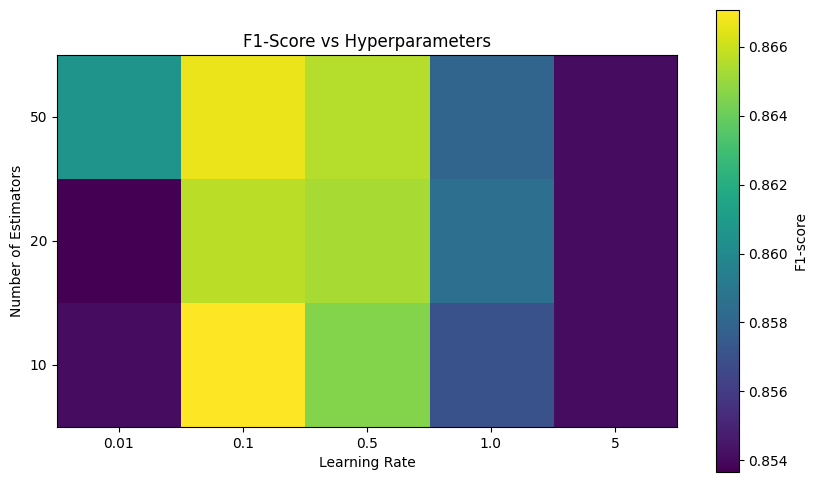

In [22]:
# Visualize the effect of hyperparameters 
from sklearn.metrics import make_scorer
import numpy as np
import matplotlib.pyplot as plt

n_estimators_values = [10, 20, 50]
learning_rate_values = [0.01, 0.1, 0.5, 1.0, 5]

f1_grid = np.zeros((len(n_estimators_values), len(learning_rate_values)))
base_regressor = DecisionTreeClassifier(max_depth=3)

for i, n_estimators in enumerate(n_estimators_values):
    for j, learning_rate in enumerate(learning_rate_values):
        model = AdaBoostClassifier(
            estimator=base_regressor,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=42
        )

        # Fit on training data
        model.fit(X, y)

        # Predict on test data
        y_pred = model.predict(X_test)

        # Computation of F1-Score manually (to match the scorer)
        f1_value = f1_score(y_test, y_pred)
        f1_grid[i, j] = f1_value

#Heatmap
plt.figure(figsize=(10, 6))
plt.imshow(f1_grid, cmap='viridis', interpolation='nearest')
plt.colorbar(label='F1-score')
plt.xlabel('Learning Rate')
plt.ylabel('Number of Estimators')
plt.title('F1-Score vs Hyperparameters')
plt.xticks(np.arange(len(learning_rate_values)), learning_rate_values)
plt.yticks(np.arange(len(n_estimators_values)), n_estimators_values)
plt.gca().invert_yaxis()
plt.show()

In [23]:
# Introducing early-stopping mechanism to developped cv_proc() function
def cv_proc_early_stop(
        var,
        model,
        param_grid,
        cv=5,
        test_size=0.2,
        max_no_improvement_rounds=50,
        max_estimators=500
    ):

    # --------------------
    # 1. Extract features
    # --------------------
    X = df.loc[:, var].values
    y = df.loc[:, "diagnosed_diabetes"].values.ravel()

    # --------------------
    # 2. Train/Validation split
    # --------------------
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    # --------------------
    # 3. GridSearchCV using F1 scoring
    # --------------------
    grid_CV = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=f1_scorer,    
        cv=cv,
        return_train_score=True,
        n_jobs=-1
    )

    grid_CV.fit(X_train, y_train)

    print("Best params:", grid_CV.best_params_)
    print("Best score (CV F1-score):", grid_CV.best_score_)

    best_model = grid_CV.best_estimator_

    # --------------------
    # 4. Early stopping loop
    # --------------------
    best_val_f1 = 0
    no_improvement = 0

    # Metric storage
    train_f1_list = []
    val_f1_list = []

    train_precision = []
    val_precision = []

    train_recall = []
    val_recall = []

    train_accuracy = []
    val_accuracy = []

    for n in range(1, max_estimators + 1):

        best_model.n_estimators = n
        best_model.fit(X_train, y_train)

        # Predictions
        y_train_pred = best_model.predict(X_train)
        y_val_pred   = best_model.predict(X_val)

        # ---- Metrics ----
        train_f1 = f1_score(y_train, y_train_pred)
        val_f1   = f1_score(y_val, y_val_pred)

        train_f1_list.append(train_f1)
        val_f1_list.append(val_f1)

        train_precision.append(precision_score(y_train, y_train_pred))
        val_precision.append(precision_score(y_val, y_val_pred))

        train_recall.append(recall_score(y_train, y_train_pred))
        val_recall.append(recall_score(y_val, y_val_pred))

        train_accuracy.append(accuracy_score(y_train, y_train_pred))
        val_accuracy.append(accuracy_score(y_val, y_val_pred))

        # ---- Early stopping condition ----
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= max_no_improvement_rounds:
            print(f"\nEarly stopping triggered at n_estimators = {n}")
            break

    # --------------------
    # 5. Return results
    # --------------------
    return {
        "grid": grid_CV,
        "best_model": best_model,

        # F1
        "train_f1": train_f1_list,
        "val_f1": val_f1_list,

        # Accuracy
        "train_accuracy": train_accuracy,
        "val_accuracy": val_accuracy,

        # Precision
        "train_precision": train_precision,
        "val_precision": val_precision,

        # Recall
        "train_recall": train_recall,
        "val_recall": val_recall,

        # Data
        "X_train": X_train,
        "X_val": X_val,
        "y_train": y_train,
        "y_val": y_val
    }


In [ ]:
#Applying the early-stopping mechanism to previously best-performing AdaBoost model (with 20 Boruta features)
results_adaboost_early_stop=cv_proc_early_stop(
    var=br_features20,
    model=AdaBoostClassifier(DecisionTreeClassifier(max_depth=3)),
    param_grid= param_grid_adaboost,
    max_no_improvement_rounds=20,
    max_estimators=50
)

#Prevents from overfitting but higher computation time

#Wyniki bez early stopping (widać nieznaczną poprawę):
#Best params: {'learning_rate': 0.1, 'n_estimators': 10}
#Accuracy:  0.9216
#Precision: 1.0000
#Recall:    0.8689
#F1-score:  0.9299

Best params: {'learning_rate': 0.1, 'n_estimators': 10}
Best score (CV F1-score): 0.9300842916277459

Early stopping triggered at n_estimators = 21


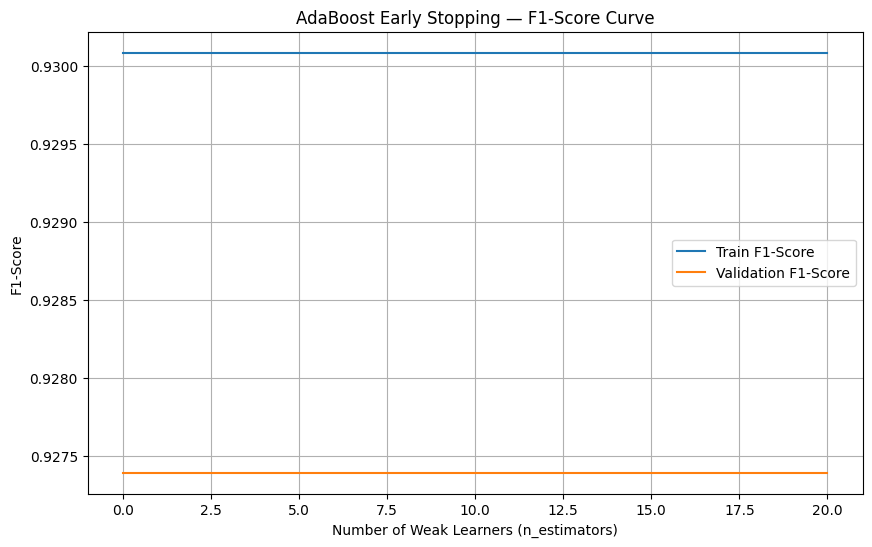

In [ ]:
#Plotting the results of early stopping mechanism by F1-Score
plt.figure(figsize=(10, 6))
plt.plot(results_adaboost_early_stop["train_f1"], label="Train F1-Score")
plt.plot(results_adaboost_early_stop["val_f1"],   label="Validation F1-Score")

plt.xlabel("Number of Weak Learners (n_estimators)")
plt.ylabel("F1-Score")
plt.title("AdaBoost Early Stopping — F1-Score Curve")
plt.legend()
plt.grid()
plt.show()  #przydałoby się więcej 'improvement_rounds'

In [28]:
#Saving metrics into separate variables for further comparison

train_f1_adaboost_early_stop = results_adaboost_early_stop["train_f1"]
val_f1_adaboost_early_stop   = results_adaboost_early_stop["val_f1"]

train_accuracy_adaboost_early_stop  = results_adaboost_early_stop["train_accuracy"]
val_accuracy_adaboost_early_stop    = results_adaboost_early_stop["val_accuracy"]

train_recall_adaboost_early_stop  = results_adaboost_early_stop["train_recall"]
val_recall_adaboost_early_stop     = results_adaboost_early_stop["val_recall"]

train_precision_adaboost_early_stop = results_adaboost_early_stop["train_precision"]
val_precision_adaboost_early_stop   = results_adaboost_early_stop["val_precision"]

### b) GBM

In [29]:
# Hyperparameter grid for GBM
param_grid_gbm= {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_features': [0.25, 0.5, 1.0]}

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model_gbm = GradientBoostingClassifier(random_state=42)

results_gbm = cv_proc(
    var=br_features10,
    model=model_gbm,
    param_grid=param_grid_gbm,
    cv=5
) #gorsze wartosci niż przy AdaBoost + dłuższe wyliczanie (zmniejszyść ilość 'cv'?)

Best params: {'learning_rate': 0.01, 'max_features': 0.5, 'n_estimators': 100}
Accuracy:  0.8452
Precision: 0.8890
Recall:    0.8468
F1-score:  0.8674


In [ ]:
# How about adding more features and checking the model performance?
results_gbm20 = cv_proc(
    var=br_features20,
    model=model_gbm,
    param_grid=param_grid_gbm,
    cv=5
) #better F1-score value, change of 'n_estimators' to 50

Best params: {'learning_rate': 0.01, 'max_features': 0.5, 'n_estimators': 50}
Accuracy:  0.9216
Precision: 1.0000
Recall:    0.8689
F1-score:  0.9299


In [ ]:
# How about adding even more features?
results_gbm25 = cv_proc(
    var=br_features25,
    model=model_gbm,
    param_grid=param_grid_gbm,
    cv=5
) 
#podobnie jak przy AdaBoost: dłuższy czas wyliczania ale metryki bez zmian
#ale tu z kolei: 'powrót' do n_estimators=100


Best params: {'learning_rate': 0.01, 'max_features': 0.5, 'n_estimators': 100}
Accuracy:  0.9216
Precision: 1.0000
Recall:    0.8689
F1-score:  0.9299


In [34]:
#Saving metrics values for further comparison
accuracy_gbm= results_gbm["accuracy"]
precision_gbm = results_gbm["precision"]
recall_gbm = results_gbm["recall"]
f1_gbm = results_gbm["f1"]

accuracy_gbm20= results_gbm20["accuracy"]
precision_gbm20 = results_gbm20["precision"]
recall_gbm20 = results_gbm20["recall"]
f1_gbm20 = results_gbm20["f1"]

accuracy_gbm25= results_gbm25["accuracy"]
precision_gbm25 = results_gbm25["precision"]
recall_gbm25 = results_gbm25["recall"]
f1_gbm25 = results_gbm25["f1"]

In [36]:
# Impact of Different Hyperparameters
# Hyperparameters to test
n_estimators_values = [50, 100]
learning_rate_values = [0.01, 0.1, 0.2]
subsample_values = [0.6, 0.8]
max_features_values = [0.25, 0.5, 1.0]

# Lists to store results
results = []

for n_estimators in n_estimators_values:
    for learning_rate in learning_rate_values:
        for subsample in subsample_values:
            for max_features in max_features_values:
                # Initialize the GradientBoostingClassifier with current hyperparameters
                gbm = GradientBoostingClassifier(
                    n_estimators=n_estimators,
                    learning_rate=learning_rate,
                    subsample=subsample,
                    max_features=max_features,
                    random_state=42
                )
                gbm.fit(X_train, y_train)

                # Make predictions on the test set
                y_pred = gbm.predict(X_test)

                # Calculate the F1-score
                f1 = f1_score(y_test, y_pred)

                results.append((n_estimators, learning_rate, subsample, max_features, f1))

# Create a DataFrame for parallel coordinate plots
df1 = pd.DataFrame(results, columns=['n_estimators', 'learning_rate', 'subsample', 'max_features', 'F1_score'])

import plotly.express as px
# Create a parallel coordinates plot with Plotly
fig = px.parallel_coordinates(df1, color="F1_score", color_continuous_scale=px.colors.colorbrewer.RdBu) 
fig.update_layout(
    title="Impact of Different Hyperparameters on F1-Score",
    xaxis_title="Hyperparameters",
    yaxis_title="F1-Score",
)
fig.show()

In [ ]:
#Applying early-stop procedure
results_gbm_early_stop=cv_proc_early_stop(
    var=br_features20,
    model=model_gbm,
    param_grid= param_grid_gbm,
    max_no_improvement_rounds=20,
    max_estimators=50
)

#AdaBoost with early stopping output:
#Best params: {'learning_rate': 0.1, 'n_estimators': 10}
#Best score (CV F1-score): 0.9300842916277459

#Early stopping triggered at n_estimators = 21

Best params: {'learning_rate': 0.1, 'max_features': 1.0, 'n_estimators': 50}
Best score (CV F1-score): 0.9300992439484894

Early stopping triggered at n_estimators = 23


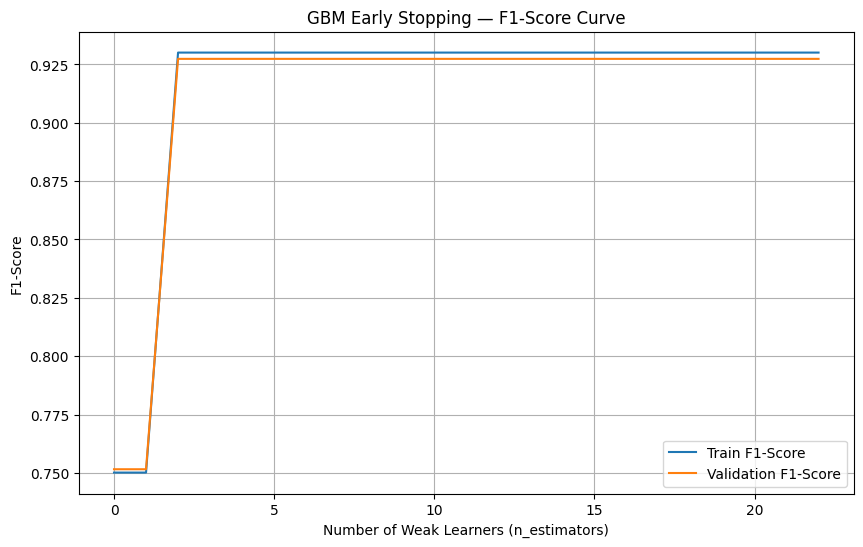

In [ ]:
#Plotting the results of early stopping mechanism by F1-Score
plt.figure(figsize=(10, 6))
plt.plot(results_gbm_early_stop["train_f1"], label="Train F1-Score")
plt.plot(results_gbm_early_stop["val_f1"],   label="Validation F1-Score")

plt.xlabel("Number of Weak Learners (n_estimators)")
plt.ylabel("F1-Score")
plt.title("GBM Early Stopping — F1-Score Curve")
plt.legend()
plt.grid()
plt.show()  #Tu już wykres wygląda 'sensowniej'

In [52]:
#Saving metrics into separate variables for further comparison

train_f1_gbm_early_stop = results_gbm_early_stop["train_f1"]
val_f1_gbm_early_stop   = results_gbm_early_stop["val_f1"]

train_accuracy_gbm_early_stop  = results_gbm_early_stop["train_accuracy"]
val_accuracy_gbm_early_stop    = results_gbm_early_stop["val_accuracy"]

train_recall_gbm_early_stop  = results_gbm_early_stop["train_recall"]
val_recall_gbm_early_stop     = results_gbm_early_stop["val_recall"]

train_precision_gbm_early_stop = results_gbm_early_stop["train_precision"]
val_precision_gbm_early_stop   = results_gbm_early_stop["val_precision"]

### c) GBM Histogram

In [42]:
#Hyperparameters grid for Histogram-based GBM
param_grid_gbm_hist= {
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5],
    "max_leaf_nodes": [15, 30],
    "min_samples_leaf": [20, 50]
}

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

model_gbm_hist = HistGradientBoostingClassifier(random_state=42)

results_gbm_hist = cv_proc(
    var=br_features,
    model=model_gbm_hist,
    param_grid=param_grid_gbm_hist
) #Tu wylicza całkiem szybko, nawet przy 'manualnym' GridSearchCV!

Best params: {'learning_rate': 0.2, 'max_depth': 3, 'max_leaf_nodes': 15, 'min_samples_leaf': 20}
Accuracy:  0.9216
Precision: 1.0000
Recall:    0.8689
F1-score:  0.9299


In [ ]:
#How about adding more features and checking the model performance?
results_gbm_hist20 = cv_proc(
    var=br_features20,
    model=model_gbm_hist,
    param_grid=param_grid_gbm_hist
) #zmaiany w hyperparameters, brak zmiany w wartości metryk (czy to jest jakiś treshold? Może da się lepiej)

Best params: {'learning_rate': 0.2, 'max_depth': 5, 'max_leaf_nodes': 30, 'min_samples_leaf': 50}
Accuracy:  0.9216
Precision: 1.0000
Recall:    0.8689
F1-score:  0.9299


In [ ]:
#How about adding even more features?
results_gbm_hist25 = cv_proc(
    var=br_features25,
    model=model_gbm_hist,
    param_grid=param_grid_gbm_hist
) #again brak zmian

Best params: {'learning_rate': 0.01, 'max_depth': 5, 'max_leaf_nodes': 15, 'min_samples_leaf': 20}
Accuracy:  0.9216
Precision: 1.0000
Recall:    0.8689
F1-score:  0.9299


In [46]:
#Saving metrics values for further comparison
accuracy_gbm_hist= results_gbm_hist["accuracy"]
precision_gbm_hist = results_gbm_hist["precision"]
recall_gbm_hist = results_gbm_hist["recall"]
f1_gbm_hist = results_gbm_hist["f1"]

accuracy_gbm_hist20= results_gbm_hist20["accuracy"]
precision_gbm_hist20 = results_gbm_hist20["precision"]
recall_gbm_hist20 = results_gbm_hist20["recall"]
f1_gbm_hist20 = results_gbm_hist20["f1"]

accuracy_gbm_hist25= results_gbm_hist25["accuracy"]
precision_gbm_hist25 = results_gbm_hist25["precision"]
recall_gbm_hist25 = results_gbm_hist25["recall"]
f1_gbm_hist25 = results_gbm_hist25["f1"]

In [47]:
# Impact of Different Hyperparameters
# Hyperparameters for Histogram GBM
max_iter_values = [50, 100]
learning_rate_values = [0.01, 0.1, 0.2]
max_depth_values = [3, 5]
max_leaf_nodes_values = [15, 30]

results = []

for max_iter in max_iter_values:
    for learning_rate in learning_rate_values:
        for max_depth in max_depth_values:
            for max_leaf_nodes in max_leaf_nodes_values:
                
                gbm_hist = HistGradientBoostingClassifier(
                    max_iter=max_iter,
                    learning_rate=learning_rate,
                    max_depth=max_depth,
                    max_leaf_nodes=max_leaf_nodes,
                    random_state=42
                )

                gbm_hist.fit(X_train, y_train)
                y_pred = gbm_hist.predict(X_test)

                # Calculate the F1-score
                f1 = f1_score(y_test, y_pred)

                results.append((max_iter, learning_rate, max_depth, max_leaf_nodes, f1))

df1 = pd.DataFrame(results, columns=[
    'max_iter', 'learning_rate', 'max_depth', 'max_leaf_nodes', 'F1_score'
])


import plotly.express as px
# Create a parallel coordinates plot with Plotly
fig = px.parallel_coordinates(df1, color="F1_score", color_continuous_scale=px.colors.colorbrewer.RdBu) 
fig.update_layout(
    title="Impact of Different Hyperparameters on F1-Score",
    xaxis_title="Hyperparameters",
    yaxis_title="F1-Score",
)
fig.show()

In [49]:
#Applying early-stop procedure (to 'baseline' model with 10 Boruta features)
results_gbm_hist_early_stop=cv_proc_early_stop(
    var=br_features,
    model=model_gbm_hist,
    param_grid= param_grid_gbm_hist,
    max_no_improvement_rounds=50,
    max_estimators=500
)

Best params: {'learning_rate': 0.2, 'max_depth': 5, 'max_leaf_nodes': 15, 'min_samples_leaf': 20}
Best score (CV F1-score): 0.9300862922681035

Early stopping triggered at n_estimators = 51


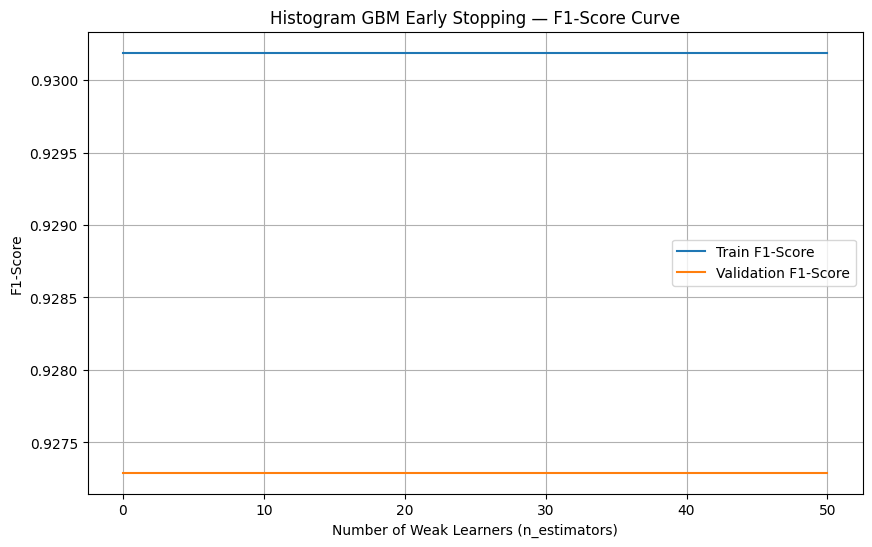

In [ ]:
#Plotting the results of early stopping mechanism by F1-Score
plt.figure(figsize=(10, 6))
plt.plot(results_gbm_hist_early_stop["train_f1"], label="Train F1-Score")
plt.plot(results_gbm_hist_early_stop["val_f1"],   label="Validation F1-Score")

plt.xlabel("Number of Weak Learners (n_estimators)")
plt.ylabel("F1-Score")
plt.title("Histogram GBM Early Stopping — F1-Score Curve")
plt.legend()
plt.grid()
plt.show() #Hmmm

In [53]:
#Saving metrics into separate variables for further comparison

train_f1_gbm_hist_early_stop = results_gbm_hist_early_stop["train_f1"]
val_f1_gbm_hist_early_stop   = results_gbm_hist_early_stop["val_f1"]

train_accuracy_gbm_hist_early_stop  = results_gbm_hist_early_stop["train_accuracy"]
val_accuracy_gbm_hist_early_stop    = results_gbm_hist_early_stop["val_accuracy"]

train_recall_gbm_hist_early_stop  = results_gbm_hist_early_stop["train_recall"]
val_recall_gbm_hist_early_stop     = results_gbm_hist_early_stop["val_recall"]

train_precision_gbm_hist_early_stop = results_gbm_hist_early_stop["train_precision"]
val_precision_gbm_hist_early_stop   = results_gbm_hist_early_stop["val_precision"]

### d) XGBoost

In [54]:
# Hyperparameters grid for XGBoost
param_grid_xgb= {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [2, 5],
    "subsample": [0.5, 0.7],
    "colsample_bytree": [0.5, 0.8, 1.0]
}

In [ ]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(
    random_state=42,
    tree_method="hist",
    eval_metric="logloss",  #differentiable function required here
    scoring="f1"            
)

results_xgb = cv_proc(
    var=br_features,
    model=model_xgb,
    param_grid=param_grid_xgb,
    cv=5
)

#Całkiem szybkie wyliczenie jak na ilość kombinacji w gridzie

Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}
Accuracy:  0.9216
Precision: 1.0000
Recall:    0.8689
F1-score:  0.9299


In [60]:
#How about adding more features and checking the model performance?
results_xgb20 = cv_proc(
    var=br_features20,
    model=model_xgb,
    param_grid=param_grid_xgb,
    cv=5
)

Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.5}
Accuracy:  0.9216
Precision: 1.0000
Recall:    0.8689
F1-score:  0.9299


In [ ]:
#How about adding even more features?
results_xgb25 = cv_proc(
    var=br_features25,
    model=model_xgb,
    param_grid=param_grid_xgb,
    cv=5
) #actual (minor) drop in metrics values

Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}
Accuracy:  0.9216
Precision: 0.9999
Recall:    0.8689
F1-score:  0.9298


In [66]:
#Saving metrics values for further comparison
accuracy_xgb= results_xgb["accuracy"]
precision_xgb = results_xgb["precision"]
recall_xgb = results_xgb["recall"]
f1_xgb = results_xgb["f1"]

accuracy_xgb20= results_xgb20["accuracy"]
precision_xgb20 = results_xgb20["precision"]
recall_xgb20 = results_xgb20["recall"]
f1_xgb20= results_xgb20["f1"]

accuracy_xgb25= results_xgb25["accuracy"]
precision_xgb25 = results_xgb25["precision"]
recall_xgb25= results_xgb25["recall"]
f1_xgb25 = results_xgb25["f1"]

[0]	train-logloss:0.62410	train-f1:0.75013	val-logloss:0.62407	val-f1:0.75156
[1]	train-logloss:0.58422	train-f1:0.75013	val-logloss:0.58491	val-f1:0.75156
[2]	train-logloss:0.55115	train-f1:0.85160	val-logloss:0.55240	val-f1:0.84801
[3]	train-logloss:0.52322	train-f1:0.85603	val-logloss:0.52504	val-f1:0.85264
[4]	train-logloss:0.49958	train-f1:0.86192	val-logloss:0.50192	val-f1:0.85648
[5]	train-logloss:0.47954	train-f1:0.86171	val-logloss:0.48220	val-f1:0.85623
[6]	train-logloss:0.46216	train-f1:0.86171	val-logloss:0.46535	val-f1:0.85623
[7]	train-logloss:0.44735	train-f1:0.86734	val-logloss:0.45082	val-f1:0.86259
[8]	train-logloss:0.43448	train-f1:0.86702	val-logloss:0.43830	val-f1:0.86229
[9]	train-logloss:0.42325	train-f1:0.86723	val-logloss:0.42742	val-f1:0.86214
[10]	train-logloss:0.41347	train-f1:0.86723	val-logloss:0.41799	val-f1:0.86214
[11]	train-logloss:0.40502	train-f1:0.86724	val-logloss:0.40977	val-f1:0.86249
[12]	train-logloss:0.39757	train-f1:0.86724	val-logloss:0.4024

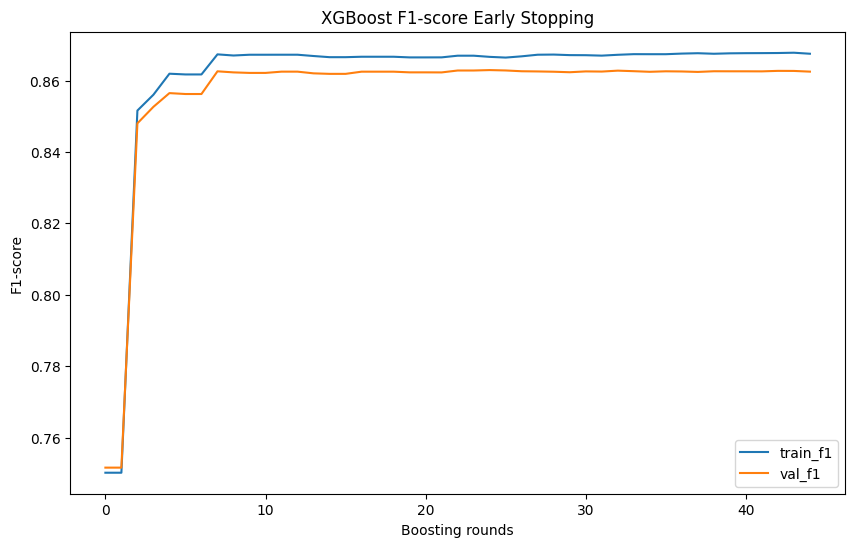

In [64]:
#Implementing early stop in order to prevent from overfitting
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Custom F1 evaluation metric for XGBoost implementation (as F1-score is not differentiable and built-in by default)
def f1_eval(preds, dtrain):
    labels = dtrain.get_label()
    preds_binary = (preds >= 0.5).astype(int)
    f1 = f1_score(labels, preds_binary)
    return 'f1', f1

# Convert data into xgb.DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)

# Define XGBoost parameters for Classification
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1,
    'eval_metric': 'logloss',  
    'seed': 42
}

evals = [(dtrain, 'train'), (dval, 'val')]

evals_result = {}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    custom_metric=f1_eval,               
    maximize=True,                 
    early_stopping_rounds=20,
    evals_result=evals_result,
    verbose_eval=True
)

dtest = xgb.DMatrix(X_test)

y_prob = model.predict(dtest)
y_pred = (y_prob >= 0.5).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))

#Plotting learning curves for F1-score
pd.DataFrame({
    'train_f1': evals_result['train']['f1'],
    'val_f1': evals_result['val']['f1']
}).plot(figsize=(10,6))

plt.xlabel("Boosting rounds")
plt.ylabel("F1-score")
plt.title("XGBoost F1-score Early Stopping")
plt.show()

#Działa, wykres spoko, no ale F1-score o wiele niższy


In [ ]:
# Perform cross-validation using xgb.cv
cv_results = xgb.cv(params, dtrain, num_round, nfold=5, metrics='rmse', seed=42, early_stopping_rounds=10,)
display(cv_results)

# Visualize cross-validation RMSE results
plt.figure(figsize=(10, 6))
plt.plot(cv_results.index, cv_results['train-rmse-mean'], label='Train RMSE')
plt.plot(cv_results.index, cv_results['test-rmse-mean'], label='Test RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.legend()
plt.title('Cross-Validation RMSE')
plt.show()


In [67]:
#Applying manually developped early-stop procedure (to 'baseline' model with 10 Boruta features)
results_xgb_early_stop=cv_proc_early_stop(
    var=br_features,
    model=model_xgb,
    param_grid= param_grid_xgb,
    max_no_improvement_rounds=50,
    max_estimators=500
) # Hmm

Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}
Best score (CV F1-score): 0.9301011801303009

Early stopping triggered at n_estimators = 55


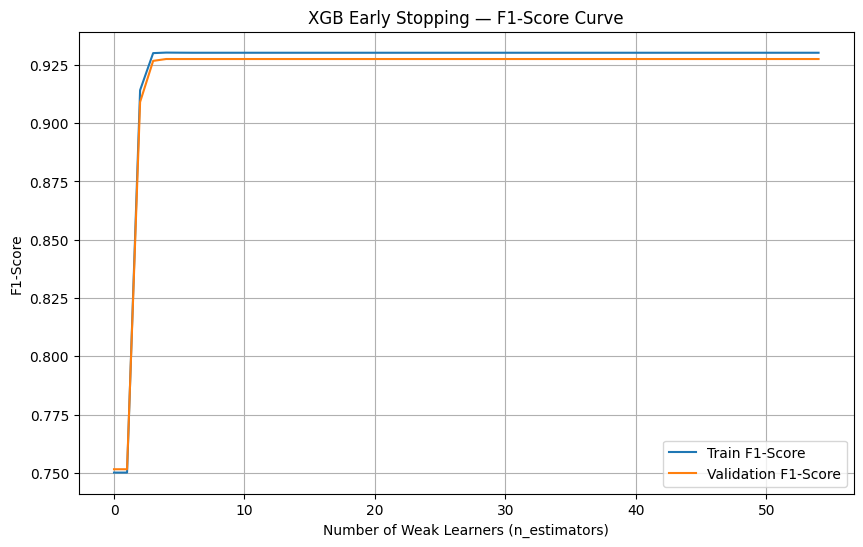

In [ ]:
#Plotting the results of early stopping mechanism by F1-Score
plt.figure(figsize=(10, 6))
plt.plot(results_xgb_early_stop["train_f1"], label="Train F1-Score")
plt.plot(results_xgb_early_stop["val_f1"],   label="Validation F1-Score")

plt.xlabel("Number of Weak Learners (n_estimators)")
plt.ylabel("F1-Score")
plt.title("XGB Early Stopping — F1-Score Curve")
plt.legend()
plt.grid()
plt.show() 

#Przynajmniej trend zmiany taki sam? To chyba przez zwiększoną liczbę 'boosting rounds' i przepuszczeń modelu
#Na tym chyba powinniśmy zatem bazować, zamiast wcześniejszego built-in API

In [ ]:
#Saving metrics into separate variables for further comparison

train_f1_xgb_early_stop= results_xgb_early_stop["train_f1"]
val_f1_xgb_early_stop   = results_xgb_early_stop["val_f1"]

train_accuracy_xgb_early_stop  = results_xgb_early_stop["train_accuracy"]
val_accuracy_xgb_early_stop   = results_xgb_early_stop["val_accuracy"]

train_recall_xgb_early_stop  = results_xgb_early_stop["train_recall"]
val_recall_xgb_early_stop    = results_xgb_early_stop["val_recall"]

train_precision_xgb_early_stop = results_xgb_early_stop["train_precision"]
val_precision_xgb_early_stop   = results_xgb_early_stop["val_precision"]

### e) LightGBM

In [72]:
#Hyperparameters grid for LightGBM
param_grid_lightgbm = {
    "boosting_type": ["gbdt"], #zastanowić się nad dart- gbdt jest domyślny i najszybszy
    "objective": ["binary"],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [50,100],
    "colsample_bytree": [0.7, 0.9]
}

In [ ]:
#Using customized function
#from lightgbm import LGBMClassifier
#
#results_lightgbm = cv_proc(
#    var=br_features,
#    model=LGBMClassifier(random_state=42, device_type="gpu", n_jobs=-1), 
#    param_grid=params_grid_lightgbm,
#    cv=5
#    )
#results_lightgbm 

#computationally intensive procedure- in this case, GridSearchCV() technique is rather ineffective

In [ ]:
#Using LightGBM API and computation-speeding enhancements, with Optuna Grind Search approach
import optuna
import numpy as np
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score


# ---------------------------------------------------
# 1) SPEED-UP: Convert data to float32 (GPU optimal)
# ---------------------------------------------------
X_train_np = X_train.astype("float32")
X_test_np  = X_test.astype("float32")
y_train_np = y_train.astype("float32")
y_test_np  = y_test.astype("float32")

# ---------------------------------------------------
# 2) Optuna objective function 
# ---------------------------------------------------

def objective(trial):

    params = {
        "boosting_type": "gbdt",
        "objective": "binary",
        "metric": "binary_logloss",
        "random_state": 42,

        # GPU
        "device_type": "gpu",
        "gpu_platform_id": 0,
        "gpu_device_id": 0,

        # Hyperparameters
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 15, 60),
        "max_depth": trial.suggest_int("max_depth", -1, 10),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.8, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.8, 1.0),
        "bagging_freq": 1,
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 60),
        "max_bin": 127
    }

    train_data = lgb.Dataset(X_train_np, y_train_np)
    valid_data = lgb.Dataset(X_test_np, y_test_np)

    model = lgb.train(
        params,
        train_data,
        num_boost_round=500,
        valid_sets=[valid_data],
        callbacks=[lgb.log_evaluation(0)]
    )

    # --- Probability prediction ---
    y_prob = model.predict(X_test_np)

    # --- Binary decision (default threshold = 0.5) ---
    y_pred = (y_prob >= 0.5).astype(int)

    # --- OPTUNA TARGET: F1-score ---
    f1 = f1_score(y_test_np, y_pred)

    return f1

# ---------------------------------------------------
# 3) Run Optuna Search (with progress bar output)
# ---------------------------------------------------

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\nBest F1-score:", study.best_value)
print("Best params:", study.best_params)

# ---------------------------------------------------
# 4) Train final model using best params 
# ---------------------------------------------------

best_params = {
    **study.best_params,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "device_type": "gpu",
    "gpu_platform_id": 0,
    "gpu_device_id": 0,
}

final_model = lgb.train(
    best_params,
    lgb.Dataset(X_train_np, y_train_np),
    num_boost_round=500
)

# ---------------------------------------------------
# 5) Final Evaluation
# ---------------------------------------------------

y_prob = final_model.predict(X_test_np)
y_pred = (y_prob >= 0.5).astype(int)

f1   = f1_score(y_test_np, y_pred)
acc  = accuracy_score(y_test_np, y_pred)
prec = precision_score(y_test_np, y_pred)
rec  = recall_score(y_test_np, y_pred)

print("\nFinal model evaluation:")
print(f"F1-score:  {f1:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")

# Nadal długi czas wyliczania, ostateczny wynik:

#Final model evaluation:
#F1-score:  0.8674
#Accuracy:  0.8470
#Precision: 0.8999
#Recall:    0.8372

# Czysto pragmatycznie pod projekt: model raczej do pominięcia- sporo kombinowania, dużo wyjaśniania, niskie wartości metryk

[I 2026-01-08 15:09:47,464] A new study created in memory with name: no-name-50031995-c15d-41a9-a70f-9ba585c8d12a


  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 38411, number of negative: 25589
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 10
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: gfx1035, Vendor: Advanced Micro Devices, Inc.
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 9 dense feature groups (0.73 MB) transferred to GPU in 0.002510 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600172 -> initscore=0.406181
[LightGBM] [Info] Start training from score 0.406181
[I 2026-01-08 15:09:57,643] Trial 0 finished with value: 0.8672435535069791 and parameters: {'learning_rate': 0.011134304127104486, 'num_leaves': 37, 'max_depth': 7, 'feature_fraction': 0.9081134495152082, 'bagging_f

Starting training...
[10]	train's binary_logloss: 0.506759	train's auc: 0.906966	test's binary_logloss: 0.508065	test's auc: 0.907959
[20]	train's binary_logloss: 0.431157	train's auc: 0.910227	test's binary_logloss: 0.433027	test's auc: 0.91064
[30]	train's binary_logloss: 0.391772	train's auc: 0.912392	test's binary_logloss: 0.394317	test's auc: 0.912001
[40]	train's binary_logloss: 0.369096	train's auc: 0.916484	test's binary_logloss: 0.372109	test's auc: 0.915325
[50]	train's binary_logloss: 0.356348	train's auc: 0.917323	test's binary_logloss: 0.359584	test's auc: 0.916226
[60]	train's binary_logloss: 0.348796	train's auc: 0.918091	test's binary_logloss: 0.352086	test's auc: 0.916824
[70]	train's binary_logloss: 0.344359	train's auc: 0.918452	test's binary_logloss: 0.347663	test's auc: 0.917176
[80]	train's binary_logloss: 0.341569	train's auc: 0.918786	test's binary_logloss: 0.344969	test's auc: 0.917413
[90]	train's binary_logloss: 0.33987	train's auc: 0.919008	test's binary_log

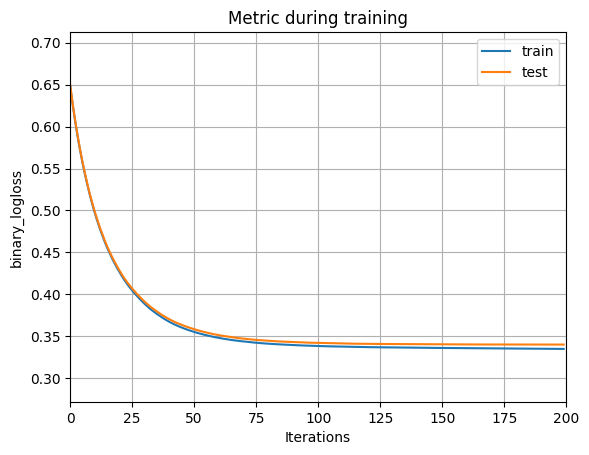

Plotting AUC during training...


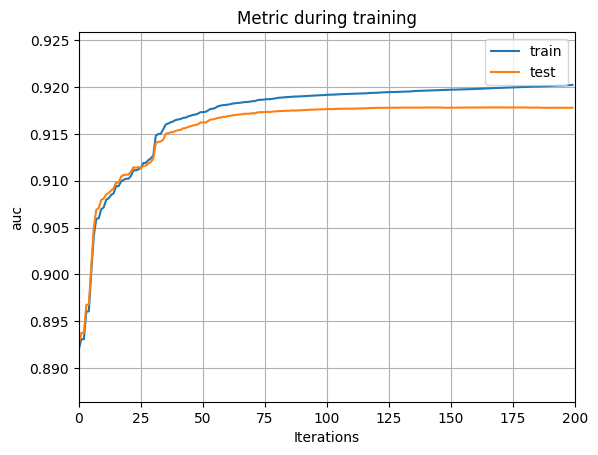

Final classification metrics:
F1-score:  0.8651
Accuracy:  0.8456
Precision: 0.9054
Recall:    0.8283
Plotting feature importances...


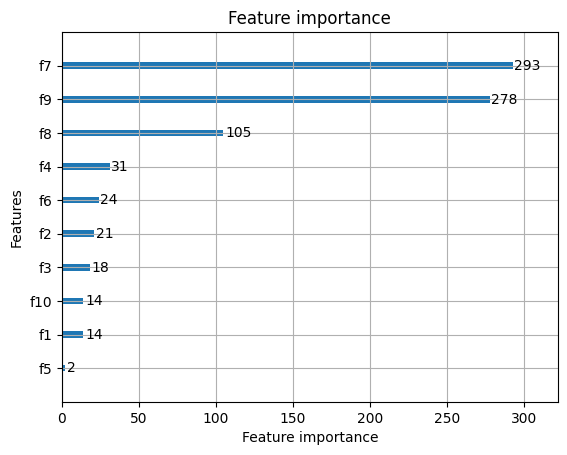

Plotting split value histogram...


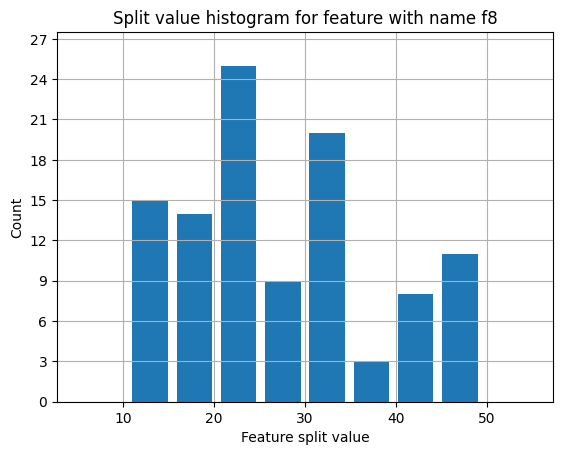

In [77]:
#Cross-validation for LightGBM model

# create dataset for lightgbm
lgb_train = lgb.Dataset(
    X_train,
    y_train,
    feature_name=[f'f{i + 1}' for i in range(X_train.shape[-1])],
    categorical_feature=[21]
)

lgb_test = lgb.Dataset(
    X_test,
    y_test,
    feature_name=[f'f{i + 1}' for i in range(X_test.shape[-1])],
    categorical_feature=[21],
    reference=lgb_train
)

# specify your configurations as a dict
params = {
    "objective": "binary",
    "metric": ["binary_logloss", "auc"],
    "num_leaves": 5,
    "learning_rate": 0.05,
    "verbose": -1
}

# training the model
evals_result = {}

print("Starting training...")

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=200,
    valid_sets=[lgb_train, lgb_test],
    valid_names=["train", "test"],
    callbacks=[
        lgb.log_evaluation(10),
        lgb.record_evaluation(evals_result)
    ]
)

# plotting metrics
print("Plotting log-loss during training...")
lgb.plot_metric(evals_result, metric="binary_logloss")
plt.show()

print("Plotting AUC during training...")
lgb.plot_metric(evals_result, metric="auc")
plt.show()

# final prediction and evaluation
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# Predict probabilities
y_prob = gbm.predict(X_test)

# Convert to class labels
y_pred = (y_prob >= 0.5).astype(int)

print("Final classification metrics:")
print(f"F1-score:  {f1_score(y_test, y_pred):.4f}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")

# feature importance plots
print("Plotting feature importances...")
lgb.plot_importance(gbm, max_num_features=10)
plt.show()

print("Plotting split value histogram...")
lgb.plot_split_value_histogram(gbm, feature="f8", bins="auto")
plt.show()


### f) CatBoost

In [80]:
# Hyperparameters for CatBoost (na razie bez L1/L2 regularization)
param_grid_catboost= {
        "learning_rate": [0.01, 0.1, 0.2],
        "depth": [4, 8],
        "iterations": [100, 200] }

In [81]:
# Implementation of CatBoost by created function
from catboost import CatBoostClassifier

model_cat = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="F1",
    verbose=0,         
    random_seed=42
)

results_cat = cv_proc(
    var = br_features,
    model = model_cat,
    param_grid = param_grid_catboost,
    cv = 5
)

Best params: {'depth': 8, 'iterations': 200, 'learning_rate': 0.01}
Accuracy:  0.9216
Precision: 1.0000
Recall:    0.8689
F1-score:  0.9299


In [82]:
#How about adding more features and checking the model performance?
results_cat20 = cv_proc(
    var = br_features20,
    model = model_cat,
    param_grid = param_grid_catboost,
    cv = 5
)

Best params: {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}
Accuracy:  0.9216
Precision: 1.0000
Recall:    0.8689
F1-score:  0.9299


In [83]:
#How about adding even more features?
results_cat25 = cv_proc(
    var = br_features25,
    model = model_cat,
    param_grid = param_grid_catboost,
    cv = 5
)

Best params: {'depth': 8, 'iterations': 100, 'learning_rate': 0.1}
Accuracy:  0.9216
Precision: 1.0000
Recall:    0.8689
F1-score:  0.9299


In [84]:
#Saving metrics values for further comparison
accuracy_cat= results_cat=["accuracy"]
precision_xgb = results_cat=["precision"]
recall_cat = results_cat=["recall"]
f1_cat = results_cat=["f1"]

accuracy_cat20= results_cat20["accuracy"]
precision_cat20 = results_cat20["precision"]
recall_cat20 = results_cat20["recall"]
f1_cat20= results_cat20["f1"]

accuracy_cat25= results_cat25["accuracy"]
precision_cat25 = results_cat25["precision"]
recall_cat25= results_cat25["recall"]
f1_cat25 = results_cat25["f1"]

In [85]:
#Applying early-stop procedure (to 'baseline' model with 10 Boruta features)
results_cat_early_stop=cv_proc_early_stop(
    var=br_features,
    model=model_cat,
    param_grid= param_grid_catboost,
    max_no_improvement_rounds=50,
    max_estimators=500
)

Best params: {'depth': 4, 'iterations': 100, 'learning_rate': 0.01}
Best score (CV F1-score): 0.9300842916277459

Early stopping triggered at n_estimators = 51


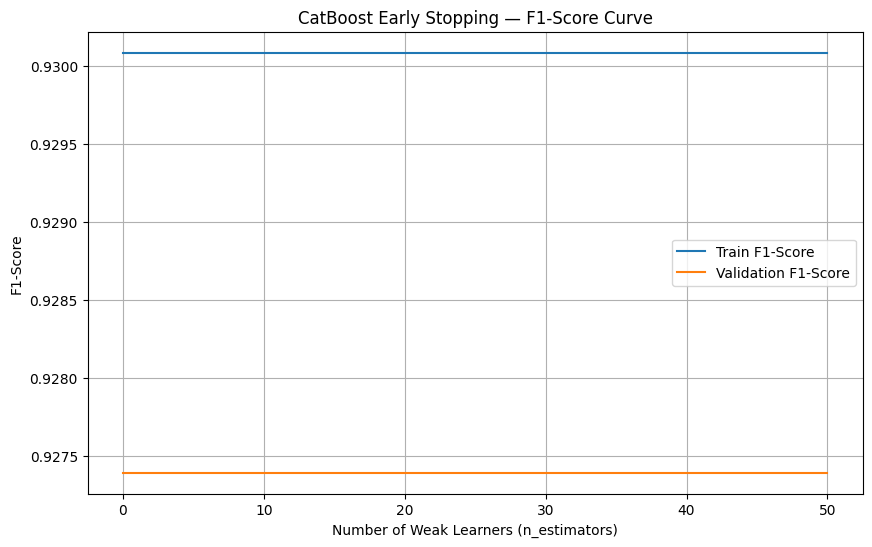

In [86]:
#Plotting the results of early stopping mechanism by F1-Score
plt.figure(figsize=(10, 6))
plt.plot(results_cat_early_stop["train_f1"], label="Train F1-Score")
plt.plot(results_cat_early_stop["val_f1"],   label="Validation F1-Score")

plt.xlabel("Number of Weak Learners (n_estimators)")
plt.ylabel("F1-Score")
plt.title("CatBoost Early Stopping — F1-Score Curve")
plt.legend()
plt.grid()
plt.show() 

In [87]:
#Saving metrics into separate variables for further comparison

train_f1_cat_early_stop= results_cat_early_stop["train_f1"]
val_f1_cat_early_stop   = results_cat_early_stop["val_f1"]

train_accuracy_cat_early_stop  = results_cat_early_stop["train_accuracy"]
val_accuracy_cat_early_stop   = results_cat_early_stop["val_accuracy"]

train_recall_cat_early_stop  = results_cat_early_stop["train_recall"]
val_recall_cat_early_stop    = results_cat_early_stop["val_recall"]

train_precision_cat_early_stop = results_cat_early_stop["train_precision"]
val_precision_cat_early_stop   = results_cat_early_stop["val_precision"]

### g) XGBoostLSS (DOKOŃCZYĆ)

In [93]:
#Using NGBoost API
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli
from ngboost.scores import LogScore
from sklearn.metrics import f1_score, make_scorer

import warnings
warnings.filterwarnings("ignore")

# -------------------------
# 1. Create NGBoost model
# -------------------------
ngb = NGBClassifier(
    Dist=Bernoulli,         #  classification-adapted distribution
    Score=LogScore,         
    learning_rate=0.05,      # 'default' start
    n_estimators=300,        
    minibatch_frac=1.0,      
    col_sample=0.8,          
    verbose=False,
    random_state=42,
)

# -------------------------
# 2. Reduced + efficient hyperparameters search
# -------------------------
param_grid_xgboostlss = {
    "n_estimators": [100, 200],     
    "learning_rate": [0.01, 0.1, 0.2],
    "minibatch_frac": [1.0, 0.8, 0.6],   # subsampling accelerates training
    "col_sample": [0.7, 0.5],       # speeds up each tree
}


# -------------------------
# 3. Using previously defined function
# -------------------------
results_xgboostlss=cv_proc(
    var=br_features,
    model=ngb_wrapped,
    param_grid=param_grid_xgboostlss
) 


TypeError: NGBClassifier.__init__() got an unexpected keyword argument 'validation_fraction'

In [ ]:
#How about adding more features and checking the model performance?
results_xgboostlss20=cv_proc(
    var=br_features20,
    model=ngb,
    param_grid=param_grid_xgboostlss
) 

In [ ]:
#How about adding even more features?
results_xgboostlss25=cv_proc(
    var=br_features25,
    model=ngb,
    param_grid=param_grid_xgboostlss
) 

In [ ]:
#Applying early-stop procedure with cv_proc_early_stop() function, to baseline model
results_xgboostlss_early_stop=cv_proc_early_stop(
    var=br_features,
    model=ngb,
    param_grid= param_grid_xgboostlss,
    max_no_improvement_rounds=50,
    max_estimators=500
)

In [ ]:
#Plotting the results of early stopping mechanism by F1-Score
plt.figure(figsize=(10, 6))
plt.plot(results_xgboostlss_early_stop["train_f1"], label="Train F1-Score")
plt.plot(results_xgboostlss_early_stop["val_f1"],   label="Validation F1-Score")

plt.xlabel("Number of Weak Learners (n_estimators)")
plt.ylabel("F1-Score")
plt.title("XGBoost LSS Early Stopping — F1-Score Curve")
plt.legend()
plt.grid()
plt.show() 

In [ ]:
#Saving metrics into separate variables for further comparison

train_f1_xgboostlss_early_stop= results_xgboostlss_early_stop["train_f1"]
val_f1_xgboostlss_early_stop   = results_xgboostlss_early_stop["val_f1"]

train_accuracy_xgboostlss_early_stop  = results_xgboostlss_early_stop["train_accuracy"]
val_accuracy_xgboostlss_early_stop   = results_xgboostlss_early_stop["val_accuracy"]

train_recall_xgboostlss_early_stop  = results_xgboostlss_early_stop["train_recall"]
val_recall_xgboostlss_early_stop    = results_xgboostlss_early_stop["val_recall"]

train_precision_xgboostlss_early_stop = results_xgboostlss_early_stop["train_precision"]
val_precision_xgboostlss_early_stop   = results_xgboostlss_early_stop["val_precision"]

In [ ]:
#Na koniec: dodać odpowiednie porównanie opracowanych modeli

NEURAL NETWORK MODELING

In [2]:
#Quick data preprocessing
df=pd.read_csv("data/input/diabetes_dataset.csv")

df = df.drop(columns='diabetes_stage')
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0, 'Other': 2})
df['ethnicity'] = df['ethnicity'].map({'White' : 0, 'Hispanic' : 1, 'Black' : 2, 'Asian' : 3, 'Other' : 4})
df['education_level'] = df['education_level'].map({'No formal' : 0, 'Highschool' : 1, 'Graduate' : 2, 'Postgraduate' : 3})
df['income_level'] = df['income_level'].map({'Low' : 0, 'Lower-Middle' :1, 'Middle' : 2, 'Upper-Middle' : 3, 'High': 4})
df['employment_status'] = df['employment_status'].map({'Employed' : 0, 'Unemployed' : 1, 'Retired': 2, 'Student':3})
df['smoking_status'] = df['smoking_status'].map({'Never' : 0, 'Former' : 1, 'Current' : 2})
df = df[df['gender'] != 2] #Removing

# Define train and target 
target = df[['diagnosed_diabetes']]
train = df.drop('diagnosed_diabetes', axis = 1)

# Feature Scaling
scaler = StandardScaler()
train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)

#Division of dataset
x_train_full, x_test = train_test_split(train, test_size=0.2, random_state=123)
y_train_full, y_test = train_test_split(target, test_size=0.2, random_state=123)

x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2)

[Simple Neural Network](#Simple_Neural_Network)

Let's try the simpliest neural network architecture with only one hidden layer.

In [ ]:
# Define the neural network
def create_model(input_dim):
    model = Sequential([
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    return model

# Compile the model
def compile_model(model):
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the model
def train_model(model, x_train, y_train, x_val, y_val, epochs=50, batch_size=32):
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1)
    return history

# Evaluate the model
def evaluate_model(model, x_test, y_test):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
    y_pred = (model.predict(x_test) > 0.5).astype("int32")
    print(classification_report(y_test, y_pred))

input_dim = x_train.shape[1]
model = create_model(input_dim)
compile_model(model)
history = train_model(model, x_train, y_train, x_val, y_val, epochs=50, batch_size=32)
evaluation = evaluate_model(model, x_test, y_test)
evaluation

Epoch 1/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 2s 637us/step - accuracy: 0.8228 - loss: 0.3952 - val_accuracy: 0.8817 - val_loss: 0.2910
Epoch 2/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 1s 538us/step - accuracy: 0.8852 - loss: 0.2864 - val_accuracy: 0.9027 - val_loss: 0.2522
Epoch 3/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step - accuracy: 0.9006 - loss: 0.2533 - val_accuracy: 0.9077 - val_loss: 0.2350
Epoch 4/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step - accuracy: 0.9054 - loss: 0.2403 - val_accuracy: 0.9113 - val_loss: 0.2295
Epoch 5/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step - accuracy: 0.9088 - loss: 0.2335 - val_accuracy: 0.9142 - val_loss: 0.2246
Epoch 6/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.9106 - loss: 0.2299 - val_accuracy: 0.9148 - val_loss: 0.2229
Epoch 7/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 1s 537us/step - accuracy: 0.9114 - loss: 0.2276 - val_accuracy: 0.9150 - val_loss: 0.2217
Epoch 8/50
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step - accuracy: 0.9124 -

The result is quite good, but let's explore more complex architectures in the next sections.

In [18]:
# Define different model architectures
def create_model_1(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_model_2(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_model_3(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Compile and train the model
def compile_and_train(model, x_train, y_train, x_val, y_val, epochs=50, batch_size=32):
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0)
    return history

# Evaluate the model
def evaluate_model(model, x_test, y_test):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    y_pred = (model.predict(x_test) > 0.5).astype("int32")
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")
    report = classification_report(y_test, y_pred, output_dict=True)
    return accuracy, report['accuracy'], report['macro avg']['f1-score']

# Example usage
input_dim = x_train.shape[1]

# Train and evaluate Model 1
model_1 = create_model_1(input_dim)
compile_and_train(model_1, x_train, y_train, x_val, y_val)
accuracy_1, precision_1, f1_1 = evaluate_model(model_1, x_test, y_test)

# Train and evaluate Model 2
model_2 = create_model_2(input_dim)
compile_and_train(model_2, x_train, y_train, x_val, y_val)
accuracy_2, precision_2, f1_2 = evaluate_model(model_2, x_test, y_test)

# Train and evaluate Model 3
model_3 = create_model_3(input_dim)
compile_and_train(model_3, x_train, y_train, x_val, y_val)
accuracy_3, precision_3, f1_3 = evaluate_model(model_3, x_test, y_test)

# Compare results
print("Model 1 - Accuracy:", accuracy_1, "F1-Score:", f1_1)
print("Model 2 - Accuracy:", accuracy_2, "F1-Score:", f1_2)
print("Model 3 - Accuracy:", accuracy_3, "F1-Score:", f1_3)

613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step
Test Loss: 0.2206, Test Accuracy: 0.9163
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
Test Loss: 0.5451, Test Accuracy: 0.8826
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
Test Loss: 0.2352, Test Accuracy: 0.9126
Model 1 - Accuracy: 0.9162669777870178 F1-Score: 0.915159609827019
Model 2 - Accuracy: 0.882641077041626 F1-Score: 0.8792420491875788
Model 3 - Accuracy: 0.9126441478729248 F1-Score: 0.9113320818895763


We can see that the simpler the model, the better the results on this dataset. In next cell we'll try different activations_functions to see if we can improve the results.

In [19]:
# Define the activation functions to test
activation_functions = ['relu', 'sigmoid', 'tanh', 'elu', 'selu']

# Function to create a model with a given activation function
def create_model_1(input_dim, activation):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation=activation),
        Dropout(0.3),
        Dense(32, activation=activation),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    return model

def create_model_2(input_dim, activation):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation=activation),
        Dense(64, activation=activation),
        Dense(32, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_model_3(input_dim, activation):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(32, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    return model


# Compile and train the model
def compile_and_train(model, x_train, y_train, x_val, y_val, epochs=20, batch_size=32):
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0)
    return history

# Evaluate the model
def evaluate_model(model, x_test, y_test):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    y_pred = (model.predict(x_test) > 0.5).astype("int32")
    report = classification_report(y_test, y_pred, output_dict=True)
    return accuracy, report['accuracy'], report['macro avg']['f1-score']

# Example usage
input_dim = x_train.shape[1]
results_1 = {}
results_2 = {}
results_3 = {}

for activation in activation_functions:
    print(f"Testing activation function: {activation}")
    model = create_model_1(input_dim, activation)
    compile_and_train(model, x_train, y_train, x_val, y_val)
    accuracy, precision, f1_score = evaluate_model(model, x_test, y_test)
    results_1[activation] = {'accuracy': accuracy, 'f1_score': f1_score}

for activation in activation_functions:
    print(f"Testing activation function: {activation}")
    model = create_model_2(input_dim, activation)
    compile_and_train(model, x_train, y_train, x_val, y_val)
    accuracy, precision, f1_score = evaluate_model(model, x_test, y_test)
    results_2[activation] = {'accuracy': accuracy, 'f1_score': f1_score}

for activation in activation_functions:
    print(f"Testing activation function: {activation}")
    model = create_model_3(input_dim, activation)
    compile_and_train(model, x_train, y_train, x_val, y_val)
    accuracy, precision, f1_score = evaluate_model(model, x_test, y_test)
    results_3[activation] = {'accuracy': accuracy, 'f1_score': f1_score}

# Display results
print('Model 1 - Simple model with dropout layers')
for activation, metrics in results_1.items():
    print(f"Activation: {activation}, Accuracy: {metrics['accuracy']:.4f}, F1-Score: {metrics['f1_score']:.4f}")

print('Model 2 - Deeper model with more neurons')
for activation, metrics in results_2.items():
    print(f"Activation: {activation}, Accuracy: {metrics['accuracy']:.4f}, F1-Score: {metrics['f1_score']:.4f}")

print('Model 3 - Smaller model with fewer neurons')
for activation, metrics in results_3.items():
    print(f"Activation: {activation}, Accuracy: {metrics['accuracy']:.4f}, F1-Score: {metrics['f1_score']:.4f}")

Testing activation function: relu
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
Testing activation function: sigmoid
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step
Testing activation function: tanh
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
Testing activation function: elu
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
Testing activation function: selu
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
Testing activation function: relu
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
Testing activation function: sigmoid
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
Testing activation function: tanh
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
Testing activation function: elu
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
Testing activation function: selu
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
Testing activation function: relu
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step
Testing activation function: sigmoid
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step
Testing activation function: tanh
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 253

Let's visualize it on the heatmap.

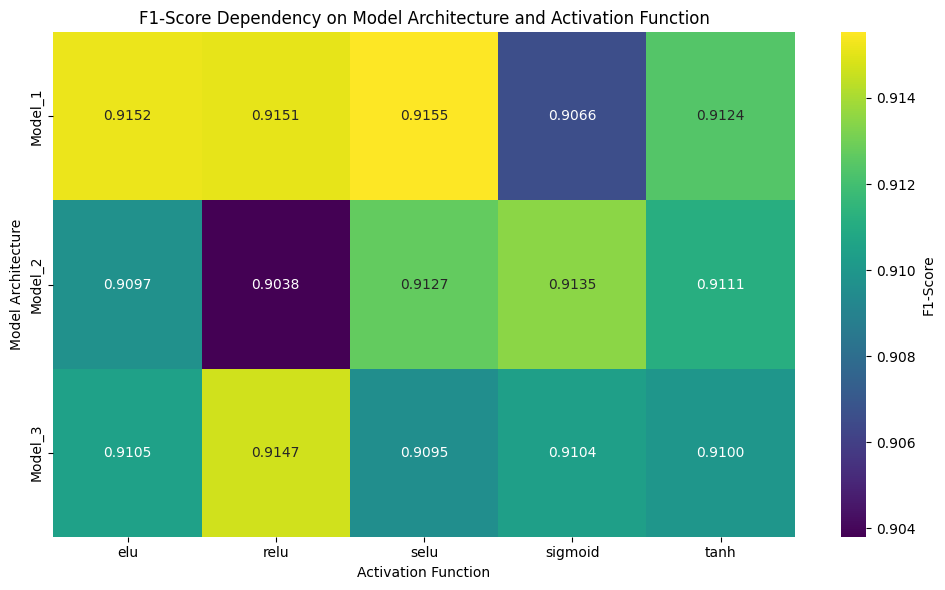

In [20]:
results_SequentialNN_1 = results_1
results_SequentialNN_2 = results_2
results_SequentialNN_3 = results_3

# Save all neural network results to a pickle file
nn_results = {
    'Sequential_Model_1': results_SequentialNN_1,
    'Sequential_Model_2': results_SequentialNN_2,
    'Sequential_Model_3': results_SequentialNN_3
}

# Create a comprehensive comparison DataFrame for all models
model_comparison = pd.DataFrame({
    'Model': ['Sequential_1_relu', 'Sequential_1_sigmoid', 'Sequential_1_tanh', 'Sequential_1_elu', 'Sequential_1_selu',
              'Sequential_2_relu', 'Sequential_2_sigmoid', 'Sequential_2_tanh', 'Sequential_2_elu', 'Sequential_2_selu',
              'Sequential_3_relu', 'Sequential_3_sigmoid', 'Sequential_3_tanh', 'Sequential_3_elu', 'Sequential_3_selu'],
    'Activation': ['relu', 'sigmoid', 'tanh', 'elu', 'selu'] * 3,
    'Architecture': ['Model_1'] * 5 + ['Model_2'] * 5 + ['Model_3'] * 5,
    'F1_Score': [results_SequentialNN_1.get('relu', {}).get('f1_score', 0),
                 results_SequentialNN_1.get('sigmoid', {}).get('f1_score', 0),
                 results_SequentialNN_1.get('tanh', {}).get('f1_score', 0),
                 results_SequentialNN_1.get('elu', {}).get('f1_score', 0),
                 results_SequentialNN_1.get('selu', {}).get('f1_score', 0),
                 results_SequentialNN_2.get('relu', {}).get('f1_score', 0),
                 results_SequentialNN_2.get('sigmoid', {}).get('f1_score', 0),
                 results_SequentialNN_2.get('tanh', {}).get('f1_score', 0),
                 results_SequentialNN_2.get('elu', {}).get('f1_score', 0),
                 results_SequentialNN_2.get('selu', {}).get('f1_score', 0),
                 results_SequentialNN_3.get('relu', {}).get('f1_score', 0),
                 results_SequentialNN_3.get('sigmoid', {}).get('f1_score', 0),
                 results_SequentialNN_3.get('tanh', {}).get('f1_score', 0),
                 results_SequentialNN_3.get('elu', {}).get('f1_score', 0),
                 results_SequentialNN_3.get('selu', {}).get('f1_score', 0)]
})

# Create pivot table for heatmap
heatmap_data = model_comparison.pivot(index='Architecture', columns='Activation', values='F1_Score')

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.4f', 
            cbar_kws={'label': 'F1-Score'})
plt.title('F1-Score Dependency on Model Architecture and Activation Function')
plt.xlabel('Activation Function')
plt.ylabel('Model Architecture')
plt.tight_layout()
plt.show()

We can see that there is no significant difference between activation functions on this dataset. The best results are obtained with 'relu' and 'elu' functions, but the difference is minimal.

Now let's assume that 'relu' is the best activation function and let's try to improve the model by adding more layers and neurons. Additionally let's add dropout layers to prevent overfitting. 

We will compare the results of the models with different batch sizes.

In [21]:
# Define the activation functions to test
activation_functions = ['relu']

batch_sizes = [8, 16, 32, 64]

# Function to create a model with a given activation function
def create_model_1(input_dim, activation):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation=activation),
        Dropout(0.3),
        Dense(32, activation=activation),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    return model

def create_model_2(input_dim, activation):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation=activation),
        Dense(64, activation=activation),
        Dense(32, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_model_3(input_dim, activation):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(32, activation=activation),
        Dense(16, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    return model


# Compile and train the model
def compile_and_train(model, x_train, y_train, x_val, y_val, epochs=20, batch_size=32):
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0)
    return history

# Evaluate the model
def evaluate_model(model, x_test, y_test):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    y_pred = (model.predict(x_test) > 0.5).astype("int32")
    report = classification_report(y_test, y_pred, output_dict=True)
    return accuracy, report['accuracy'], report['macro avg']['f1-score'], report['macro avg']['recall']

# Example usage
input_dim = x_train.shape[1]
results_1 = {}
results_2 = {}
results_3 = {}

for batch_size in batch_sizes:
    print(f"Testing batch size: {batch_size}")
    model = create_model_1(input_dim, activation)
    compile_and_train(model, x_train, y_train, x_val, y_val, batch_size=batch_size)
    accuracy, precision, f1_score, recall = evaluate_model(model, x_test, y_test)
    results_1[batch_size] = {'accuracy': accuracy, 'f1_score': f1_score, 'recall' : recall}

for batch_size in batch_sizes:
    print(f"Testing batch size: {batch_size}")
    model = create_model_2(input_dim, activation)
    compile_and_train(model, x_train, y_train, x_val, y_val, batch_size=batch_size)
    accuracy, precision, f1_score, recall = evaluate_model(model, x_test, y_test)
    results_2[batch_size] = {'accuracy': accuracy, 'f1_score': f1_score, 'recall' : recall}

for batch_size in batch_sizes:
    print(f"Testing batch size: {batch_size}")
    model = create_model_3(input_dim, activation)
    compile_and_train(model, x_train, y_train, x_val, y_val, batch_size=batch_size)
    accuracy, precision, f1_score, recall = evaluate_model(model, x_test, y_test)
    results_3[batch_size] = {'accuracy': accuracy, 'f1_score': f1_score, 'recall' : recall}


Testing batch size: 8
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
Testing batch size: 16
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
Testing batch size: 32
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
Testing batch size: 64
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
Testing batch size: 8
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
Testing batch size: 16
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step
Testing batch size: 32
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
Testing batch size: 64
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step
Testing batch size: 8
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
Testing batch size: 16
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
Testing batch size: 32
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
Testing batch size: 64
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


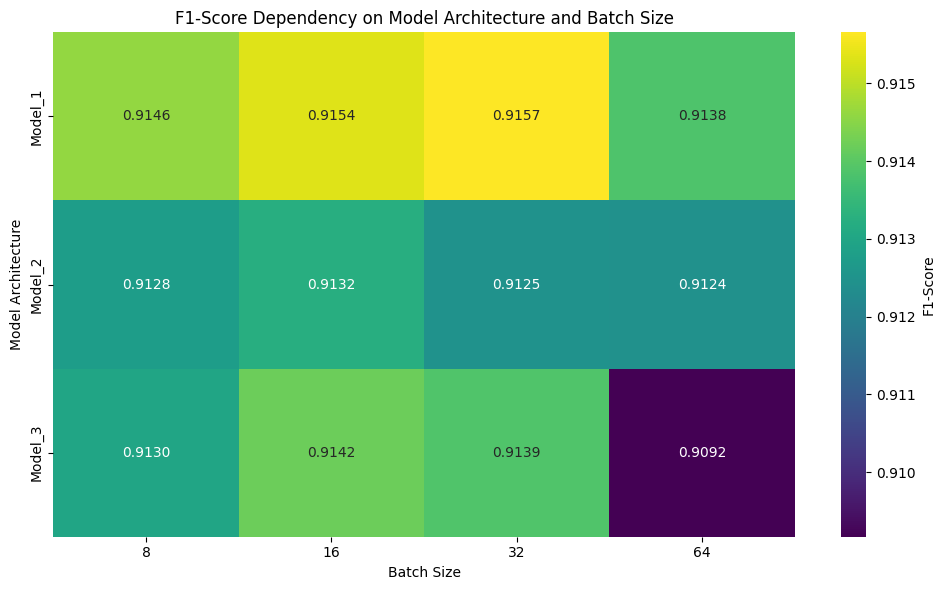

In [22]:
results_SequentialNN_batch_1 = results_1
results_SequentialNN_batch_2 = results_2
results_SequentialNN_batch_3 = results_3

# Save all neural network results to a pickle file
nn_results_batch = {
    'Sequential_Model_1': results_SequentialNN_batch_1,
    'Sequential_Model_2': results_SequentialNN_batch_2,
    'Sequential_Model_3': results_SequentialNN_batch_3
}

model_comparison = pd.DataFrame({
    'Model': ['Sequential_1_8', 'Sequential_1_16', 'Sequential_1_32', 'Sequential_1_64',
              'Sequential_2_8', 'Sequential_2_16', 'Sequential_2_32', 'Sequential_2_64',
              'Sequential_3_8', 'Sequential_3_16', 'Sequential_3_32', 'Sequential_3_64'],
    'Batch Size': [8, 16, 32, 64] * 3,
    'Architecture': ['Model_1'] * 4 + ['Model_2'] * 4 + ['Model_3'] * 4,
    'F1_Score': [results_SequentialNN_batch_1.get(8, {}).get('f1_score', 0),
                 results_SequentialNN_batch_1.get(16, {}).get('f1_score', 0),
                 results_SequentialNN_batch_1.get(32, {}).get('f1_score', 0),
                 results_SequentialNN_batch_1.get(64, {}).get('f1_score', 0),
                 results_SequentialNN_batch_2.get(8, {}).get('f1_score', 0),
                 results_SequentialNN_batch_2.get(16, {}).get('f1_score', 0),
                 results_SequentialNN_batch_2.get(32, {}).get('f1_score', 0),
                 results_SequentialNN_batch_2.get(64, {}).get('f1_score', 0),
                 results_SequentialNN_batch_3.get(8, {}).get('f1_score', 0),
                 results_SequentialNN_batch_3.get(16, {}).get('f1_score', 0),
                 results_SequentialNN_batch_3.get(32, {}).get('f1_score', 0),
                 results_SequentialNN_batch_3.get(64, {}).get('f1_score', 0)]
})

# Create pivot table for heatmap
heatmap_data = model_comparison.pivot(index='Architecture', columns='Batch Size', values='F1_Score')

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.4f', 
            cbar_kws={'label': 'F1-Score'})
plt.title('F1-Score Dependency on Model Architecture and Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Model Architecture')
plt.tight_layout()
plt.show()

We can see that adding more layers and neurons does not improve the results significantly. The best results are still obtained with the simpler architecture.

Let's try different loss functions to see if we can improve the results. We'll consider 'binary_crossentropy', 'hinge', and 'squared_hinge' loss functions. Additionally, we'll analyze the impact of different optimizers: 'Adam' and 'SGD'.

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define the learning rates and loss functions to test
learning_rate = 0.001
optimizers = [Adam, SGD]
loss_functions = ['binary_crossentropy', 'hinge']

# Function to create a simple model
def create_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(32, activation='elu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Compile and train the model
def compile_and_train(model, x_train, y_train, x_val, y_val, learning_rate, loss, optimizer, epochs=20, batch_size=8):
    optimizer_set = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=optimizer_set,
                  loss=loss,
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0)
    return history

# Evaluate the model
def evaluate_model(model, x_test, y_test):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    y_pred = (model.predict(x_test) > 0.5).astype("int32")
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    return accuracy, report['accuracy'], report['macro avg']['f1-score'], report['macro avg']['recall']


In [ ]:

input_dim = x_train.shape[1]
results = {}

# Test different combinations of learning rates and loss functions
for optimizer in optimizers:
    for loss in loss_functions:
        config_name = f"optimizer={optimizer},loss={loss}"
        print(f"Testing configuration: {config_name}")
        model = create_model(input_dim)
        compile_and_train(model, x_train, y_train, x_val, y_val, learning_rate, loss, optimizer)
        accuracy, precision, f1_score = evaluate_model(model, x_test, y_test)
        results[config_name] = {'accuracy': accuracy, 'f1_score': f1_score}


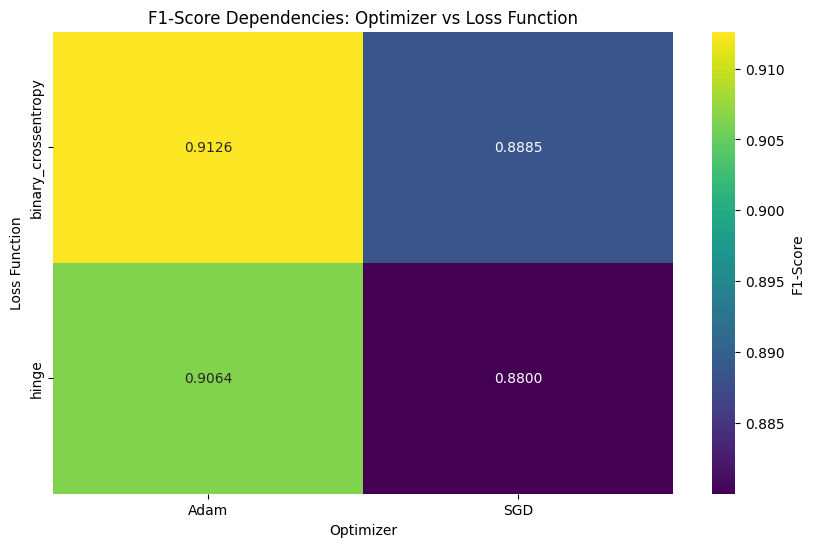

In [30]:
results_LR_Loss = results 

# Create a comprehensive comparison DataFrame for learning rate and loss function results
# Extract optimizer name and loss function from configuration keys
model_comparison_lr_loss = pd.DataFrame({
    'Configuration': list(results_LR_Loss.keys()),
    'Optimizer': ['Adam' if 'Adam' in config else 'SGD' for config in results_LR_Loss.keys()],
    'Loss_Function': [config.split('loss=')[1] for config in results_LR_Loss.keys()],
    'F1_Score': [metrics['f1_score'] for metrics in results_LR_Loss.values()]
})  
# Create pivot table for heatmap
heatmap_matrix = model_comparison_lr_loss.pivot(index='Loss_Function', columns='Optimizer', values='F1_Score')

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_matrix, annot=True, cmap='viridis', fmt='.4f', 
            cbar_kws={'label': 'F1-Score'})
plt.title('F1-Score Dependencies: Learning Rate vs Loss Function')
plt.title('F1-Score Dependencies: Optimizer vs Loss Function')
plt.xlabel('Optimizer')
plt.ylabel('Loss Function')
plt.show()

We can see that the best results are obtained with 'binary_crossentropy' loss function and 'Adam' optimizer. The other combinations do not improve the results significantly. Hence, let's stick with this configuration for further analysis.

Early Stopping
Now we will implement early stopping to prevent overfitting. We will monitor the validation loss and stop training if it does not improve for a certain number of epochs.

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

# Define the activation functions to test
activation_functions = ['relu', 'sigmoid']

# Function to create a model with a given activation function
def create_model_1(input_dim, activation):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation=activation),
        Dropout(0.3),
        Dense(32, activation=activation),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    return model

def create_model_2(input_dim, activation):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation=activation),
        Dense(64, activation=activation),
        Dense(32, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_model_3(input_dim, activation):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(32, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    return model

# Enhanced compile and train function with EarlyStopping
def compile_and_train_with_early_stopping(model, x_train, y_train, x_val, y_val, epochs=50, batch_size=32):
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Define EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',           # Monitor validation loss
        patience=3,                   # Stop if no improvement for 3 consecutive epochs
        restore_best_weights=True,    # Restore the best weights when stopping
        verbose=1,                    # Print message when stopping
        mode='min',                   # Stop when monitored quantity stops decreasing
        min_delta=0.001               # Minimum change to qualify as improvement
    )
    
    # Train model with callbacks
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping],
                        verbose=0)
    
    return history, early_stopping.stopped_epoch

# Enhanced evaluate function
def evaluate_model_enhanced(model, x_test, y_test):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    y_pred = (model.predict(x_test, verbose=0) > 0.5).astype("int32")
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    return {
        'accuracy': accuracy, 
        'f1_score': report['macro avg']['f1-score'],
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall']
    }

# Function to plot training history with early stopping indicator
def plot_model_history(history, model_name, activation, stopped_epoch):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot F1 Score (since that's what we're monitoring)
    ax1.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    if stopped_epoch > 0:
        ax1.axvline(x=stopped_epoch, color='red', linestyle='--', 
                   label=f'Early Stop (Epoch {stopped_epoch})')
    ax1.set_title(f'{model_name} - {activation} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', marker='o')
    ax2.plot(history.history['val_loss'], label='Validation Loss', marker='s')
    if stopped_epoch > 0:
        ax2.axvline(x=stopped_epoch, color='red', linestyle='--',
                   label=f'Early Stop (Epoch {stopped_epoch})')
    ax2.set_title(f'{model_name} - {activation} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()

# Training function for each model architecture
def train_model_architecture(model_creator, model_name, input_dim):
    
    results = {}
    training_info = {}
    
    for activation in activation_functions:
        print(f"\n Testing {model_name} with activation: {activation}")
        
        # Create and train model
        model = model_creator(input_dim, activation)
        history, stopped_epoch = compile_and_train_with_early_stopping(
            model, x_train, y_train, x_val, y_val, epochs=50
        )
        
        # Evaluate model
        metrics = evaluate_model_enhanced(model, x_test, y_test)
        
        # Store results
        results[activation] = metrics
        training_info[activation] = {
            'history': history,
            'stopped_epoch': stopped_epoch,
            'total_epochs': len(history.history['loss']),
            'early_stopped': stopped_epoch > 0
        }
        
        # Print results
        print(f"   Accuracy: {metrics['accuracy']:.4f}")
        print(f"   F1-Score: {metrics['f1_score']:.4f}")
        print(f"   Recall: {metrics['recall']:.4f}")
        print(f"   Epochs trained: {len(history.history['loss'])}")
        if stopped_epoch > 0:
            print(f"Early stopped at epoch: {stopped_epoch}")
        else:
            print(f"Completed all epochs")
    
    return results, training_info


In [36]:

# Main execution
input_dim = x_train.shape[1]

# Train all model architectures
print("TRAINING NEURAL NETWORK MODELS WITH EARLY STOPPING")
print("=" * 80)

# Model 1: Simple model with dropout layers
results_1, training_info_1 = train_model_architecture(
    create_model_1, "Model 1 (Simple with Dropout)", input_dim
)

# Model 2: Deeper model with more neurons
results_2, training_info_2 = train_model_architecture(
    create_model_2, "Model 2 (Deeper)", input_dim
)

# Model 3: Smaller model with fewer neurons
results_3, training_info_3 = train_model_architecture(
    create_model_3, "Model 3 (Smaller)", input_dim
)

TRAINING NEURAL NETWORK MODELS WITH EARLY STOPPING

 Testing Model 1 (Simple with Dropout) with activation: relu
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 8.
   Accuracy: 0.9143
   F1-Score: 0.9132
   Recall: 0.9271
   Epochs trained: 11
Early stopped at epoch: 10

 Testing Model 1 (Simple with Dropout) with activation: sigmoid
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 11.
   Accuracy: 0.9060
   F1-Score: 0.9048
   Recall: 0.9196
   Epochs trained: 14
Early stopped at epoch: 13

 Testing Model 2 (Deeper) with activation: relu
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 5.
   Accuracy: 0.9095
   F1-Score: 0.9080
   Recall: 0.9199
   Epochs trained: 8
Early stopped at epoch: 7

 Testing Model 2 (Deeper) with activation: sigmoid
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 11.
   Accuracy: 0.9137
   F1-Score: 0.9125
   Recall: 0.9263
   Epoc

In [37]:
# Comprehensive results display
print("COMPREHENSIVE RESULTS WITH EARLY STOPPING")

models_data = [
    ("Model 1 (Simple with Dropout)", results_1, training_info_1),
    ("Model 2 (Deeper)", results_2, training_info_2),
    ("Model 3 (Smaller)", results_3, training_info_3)
]

best_overall = {'model': None, 'activation': None, 'f1_score': 0, 'recall': 0}

for model_name, results, training_info in models_data:
    print(f"\n {model_name}")
    print("-" * 50)
    
    for activation, metrics in results.items():
        info = training_info[activation]
        print(f"   {activation}:")
        print(f"     Accuracy: {metrics['accuracy']:.4f}")
        print(f"     F1-Score: {metrics['f1_score']:.4f}")
        print(f"     Precision: {metrics['precision']:.4f}")
        print(f"     Recall: {metrics['recall']:.4f}")
        print(f"     Epochs: {info['total_epochs']} {'(Early Stopped)' if info['early_stopped'] else '(Full Training)'}")
        
        # Track best overall performance
        if metrics['f1_score'] > best_overall['f1_score']:
            best_overall = {
                'model': model_name,
                'activation': activation,
                'f1_score': metrics['f1_score'],
                'accuracy': metrics['accuracy'],
                'recall': metrics['recall']
            }


COMPREHENSIVE RESULTS WITH EARLY STOPPING

 Model 1 (Simple with Dropout)
--------------------------------------------------
   relu:
     Accuracy: 0.9143
     F1-Score: 0.9132
     Precision: 0.9114
     Recall: 0.9271
     Epochs: 11 (Early Stopped)
   sigmoid:
     Accuracy: 0.9060
     F1-Score: 0.9048
     Precision: 0.9039
     Recall: 0.9196
     Epochs: 14 (Early Stopped)

 Model 2 (Deeper)
--------------------------------------------------
   relu:
     Accuracy: 0.9095
     F1-Score: 0.9080
     Precision: 0.9053
     Recall: 0.9199
     Epochs: 8 (Early Stopped)
   sigmoid:
     Accuracy: 0.9137
     F1-Score: 0.9125
     Precision: 0.9107
     Recall: 0.9263
     Epochs: 14 (Early Stopped)

 Model 3 (Smaller)
--------------------------------------------------
   relu:
     Accuracy: 0.9145
     F1-Score: 0.9132
     Precision: 0.9110
     Recall: 0.9264
     Epochs: 16 (Early Stopped)
   sigmoid:
     Accuracy: 0.9107
     F1-Score: 0.9093
     Precision: 0.9066
     Recal


 BEST OVERALL MODEL:
   Model: Model 3 (Smaller)
   Activation: relu
   F1-Score: 0.9132
   Accuracy: 0.9145
   Recall: 0.9264

 EARLY STOPPING STATISTICS:
   Total models trained: 6
   Models early stopped: 6/6 (100.0%)
   Average epochs per model: 14.2

 Training History for Best Model:


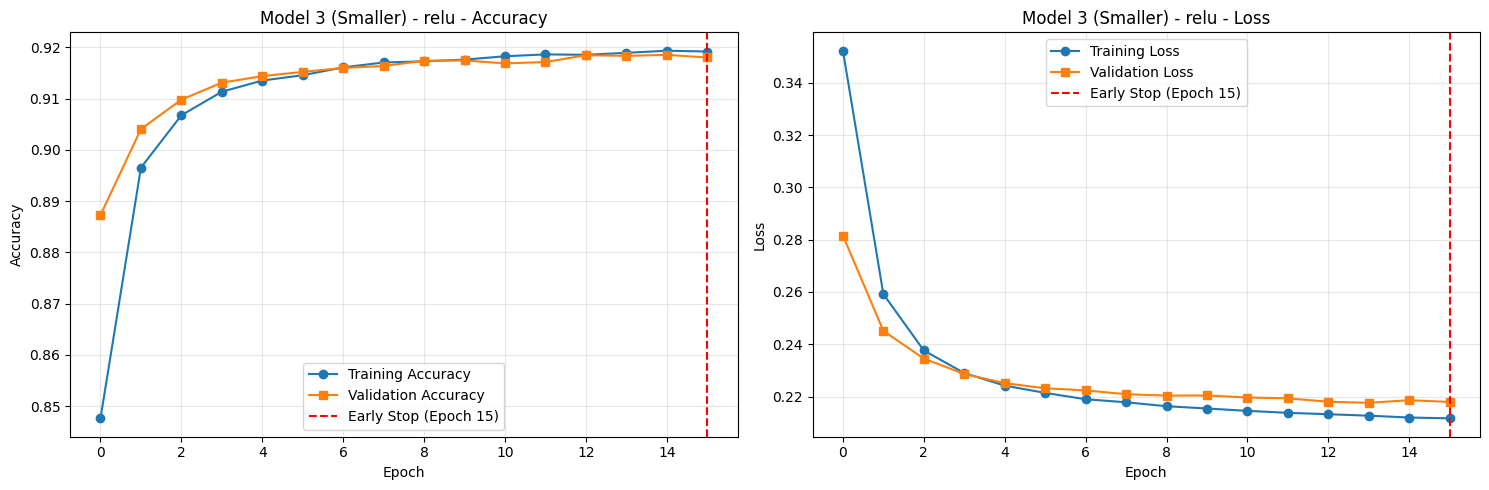

In [42]:

# Display best overall model
print(f"\n BEST OVERALL MODEL:")
print(f"   Model: {best_overall['model']}")
print(f"   Activation: {best_overall['activation']}")
print(f"   F1-Score: {best_overall['f1_score']:.4f}")
print(f"   Accuracy: {best_overall['accuracy']:.4f}")
print(f"   Recall: {best_overall['recall']:.4f}")

# Early stopping statistics
print(f"\n EARLY STOPPING STATISTICS:")
total_models = len(activation_functions) * 3
early_stopped_count = 0
total_epochs = 0

for _, _, training_info in models_data:
    for activation, info in training_info.items():
        if info['early_stopped']:
            early_stopped_count += 1
        total_epochs += info['total_epochs']

avg_epochs = total_epochs / total_models
print(f"   Total models trained: {total_models}")
print(f"   Models early stopped: {early_stopped_count}/{total_models} ({early_stopped_count/total_models*100:.1f}%)")
print(f"   Average epochs per model: {avg_epochs:.1f}")

# Plot training history for best model
best_model_data = None
best_training_info = None
for model_name, results, training_info in models_data:
    if model_name == best_overall['model']:
        best_model_data = results
        best_training_info = training_info
        break
    
if best_model_data and best_training_info:
    best_activation = best_overall['activation']
    best_history = best_training_info[best_activation]['history']
    best_stopped_epoch = best_training_info[best_activation]['stopped_epoch']
    
    print(f"\n Training History for Best Model:")
    plot_model_history(best_history, best_overall['model'], best_activation, best_stopped_epoch)


In [50]:
# Save the results using pickle
with open('data/output/NN_models/neural_network_results_early_stopping.pkl', 'wb') as f:
    pickle.dump({
        'models_data': models_data,
        'best_overall': best_overall,
        'early_stopping_stats': {
            'total_models': total_models,
            'early_stopped_count': early_stopped_count,
            'average_epochs': total_epochs / total_models
        }
    }, f)

[Feature Ranking for Neural Network](#NN_Feature_Ranking)
Now, let's use feature importance from ensemble methods to rank features and select the most important ones for training the neural network. We'll use the features selected by MIutual Information and Boruta Ranking.

In [44]:
feature_ranking = pd.read_csv("data/output/general_ranking.csv")

In [49]:
# Get top features based on mutual information score
top_features_mi = feature_ranking.nlargest(10, 'mi_score')['Unnamed: 0'].tolist()
print("Top 10 features based on MI score:")
print(top_features_mi)

# Prepare data with selected features
X_mi = df[top_features_mi].values
y_mi = df['diagnosed_diabetes'].values

scale_mi = StandardScaler()
X_mi = scale_mi.fit_transform(X_mi)

# Split the data
X_train_mi, X_test_mi, y_train_mi, y_test_mi = train_test_split(
    X_mi, y_mi, test_size=0.2, random_state=42
)
X_train_mi, X_val_mi, y_train_mi, y_val_mi = train_test_split(
    X_train_mi, y_train_mi, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train_mi.shape}")
print(f"Validation set shape: {X_val_mi.shape}")
print(f"Test set shape: {X_test_mi.shape}")

# Define Sequential NN models for MI-selected features
def create_mi_model_1(input_dim, activation='relu'):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation=activation),
        Dropout(0.3),
        Dense(32, activation=activation),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_mi_model_2(input_dim, activation='relu'):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation=activation),
        Dense(64, activation=activation),
        Dense(32, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_mi_model_3(input_dim, activation='relu'):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(32, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    return model

def compile_and_train(model, x_train, y_train, x_val, y_val, learning_rate=0.001, epochs=20, batch_size=8):
    optimizer_set = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer_set,
                  loss=['binary_crossentropy'],
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0)
    return history
# Train models with MI-selected features
input_dim_mi = X_train_mi.shape[1]
activation_functions = ['relu', 'sigmoid', 'tanh', 'elu', 'selu']

results_mi_1 = {}
results_mi_2 = {}
results_mi_3 = {}

print("\nTraining Sequential NN models with MI-selected features:")

# Model 1 with MI features
print("\nModel 1 (Simple with Dropout) - MI Features:")
for activation in activation_functions:
    print(f"Testing activation function: {activation}")
    model = create_mi_model_1(input_dim_mi, activation)
    compile_and_train(model, X_train_mi, y_train_mi, X_val_mi, y_val_mi)
    accuracy, precision, f1_score, recall= evaluate_model(model, X_test_mi, y_test_mi)
    results_mi_1[activation] = {'accuracy': accuracy, 'f1_score': f1_score, 'recall': recall}

# Model 2 with MI features
print("\nModel 2 (Deeper) - MI Features:")
for activation in activation_functions:
    print(f"Testing activation function: {activation}")
    model = create_mi_model_2(input_dim_mi, activation)
    compile_and_train(model, X_train_mi, y_train_mi, X_val_mi, y_val_mi)
    accuracy, precision, f1_score, recall = evaluate_model(model, X_test_mi, y_test_mi)
    results_mi_2[activation] = {'accuracy': accuracy, 'f1_score': f1_score, 'recall': recall}

# Model 3 with MI features
print("\nModel 3 (Smaller) - MI Features:")
for activation in activation_functions:
    print(f"Testing activation function: {activation}")
    model = create_mi_model_3(input_dim_mi, activation)
    compile_and_train(model, X_train_mi, y_train_mi, X_val_mi, y_val_mi)
    accuracy, precision, f1_score, recall = evaluate_model(model, X_test_mi, y_test_mi)
    results_mi_3[activation] = {'accuracy': accuracy, 'f1_score': f1_score, 'recall': recall}


Top 10 features based on MI score:
['hba1c', 'glucose_postprandial', 'glucose_fasting', 'diabetes_risk_score', 'family_history_diabetes', 'age', 'physical_activity_minutes_per_week', 'waist_to_hip_ratio', 'systolic_bp', 'bmi']
Training set shape: (62711, 10)
Validation set shape: (15678, 10)
Test set shape: (19598, 10)

Training Sequential NN models with MI-selected features:

Model 1 (Simple with Dropout) - MI Features:
Testing activation function: relu
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
Testing activation function: sigmoid
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
Testing activation function: tanh
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
Testing activation function: elu
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
Testing activation function: selu
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step

Model 2 (Deeper) - MI Features:
Testing activation function: relu
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step
Testing activation function: sigmoid
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/ste

In [51]:
# Display results for MI-based models
print("RESULTS FOR MODELS TRAINED WITH MI-SELECTED FEATURES")

print('\nModel 1 (Simple with dropout) - MI Features:')
for activation, metrics in results_mi_1.items():
    print(f"Activation: {activation}, Accuracy: {metrics['accuracy']:.4f}, F1-Score: {metrics['f1_score']:.4f}, Recall: {metrics['recall']:.4f}")

print('\nModel 2 (Deeper) - MI Features:')
for activation, metrics in results_mi_2.items():
    print(f"Activation: {activation}, Accuracy: {metrics['accuracy']:.4f}, F1-Score: {metrics['f1_score']:.4f}, Recall: {metrics['recall']:.4f}")

print('\nModel 3 (Smaller) - MI Features:')
for activation, metrics in results_mi_3.items():
    print(f"Activation: {activation}, Accuracy: {metrics['accuracy']:.4f}, F1-Score: {metrics['f1_score']:.4f}, Recall: {metrics['recall']:.4f}")

# Find best performing model with MI features
best_mi_model = {'model': None, 'activation': None, 'f1_score': 0, 'accuracy': 0, 'recall': 0}

for model_name, results in [('Model_1_MI', results_mi_1), ('Model_2_MI', results_mi_2), ('Model_3_MI', results_mi_3)]:
    for activation, metrics in results.items():
        if metrics['f1_score'] > best_mi_model['f1_score']:
            best_mi_model = {
                'model': model_name,
                'activation': activation,
                'f1_score': metrics['f1_score'],
                'accuracy': metrics['accuracy'],
                'recall': metrics['recall']
            }

print(f"\nBest MI-based model:")
print(f"Model: {best_mi_model['model']}")
print(f"Activation: {best_mi_model['activation']}")
print(f"F1-Score: {best_mi_model['f1_score']:.4f}")
print(f"Accuracy: {best_mi_model['accuracy']:.4f}")
print(f"Recall: {best_mi_model['recall']:.4f}")

# Save MI-based results
results_MI_NN = {
    'Sequential_MI_Model_1': results_mi_1,
    'Sequential_MI_Model_2': results_mi_2,
    'Sequential_MI_Model_3': results_mi_3,
    'best_model': best_mi_model,
    'selected_features': top_features_mi
}

with open('data/output/NN_models/neural_network_results_mi_features.pkl', 'wb') as f:
    pickle.dump(results_MI_NN, f)

print("\nMI-based neural network results saved to neural_network_mi_results.pkl")

RESULTS FOR MODELS TRAINED WITH MI-SELECTED FEATURES

Model 1 (Simple with dropout) - MI Features:
Activation: relu, Accuracy: 0.9189, F1-Score: 0.9180, Recall: 0.9318
Activation: sigmoid, Accuracy: 0.9152, F1-Score: 0.9143, Recall: 0.9283
Activation: tanh, Accuracy: 0.9173, F1-Score: 0.9163, Recall: 0.9295
Activation: elu, Accuracy: 0.9185, F1-Score: 0.9176, Recall: 0.9313
Activation: selu, Accuracy: 0.9190, F1-Score: 0.9180, Recall: 0.9317

Model 2 (Deeper) - MI Features:
Activation: relu, Accuracy: 0.9166, F1-Score: 0.9156, Recall: 0.9294
Activation: sigmoid, Accuracy: 0.9177, F1-Score: 0.9167, Recall: 0.9301
Activation: tanh, Accuracy: 0.9169, F1-Score: 0.9158, Recall: 0.9289
Activation: elu, Accuracy: 0.9174, F1-Score: 0.9164, Recall: 0.9300
Activation: selu, Accuracy: 0.9161, F1-Score: 0.9152, Recall: 0.9291

Model 3 (Smaller) - MI Features:
Activation: relu, Accuracy: 0.9184, F1-Score: 0.9173, Recall: 0.9306
Activation: sigmoid, Accuracy: 0.9156, F1-Score: 0.9145, Recall: 0.9271

The MI-based features seem to not improve the results significantly compared to using all features. However, let's save the results for future reference.

In [52]:
# Get top features based on mutual information score
top_features_boruta = feature_ranking.nsmallest(15, 'boruta_rank')['Unnamed: 0'].tolist()
print("Top 10 features based on Boruta score:")
print(top_features_boruta)

# Prepare data with selected features
X_boruta = df[top_features_boruta].values
y_boruta = df['diagnosed_diabetes'].values

scale_boruta = StandardScaler()
X_boruta = scale_boruta.fit_transform(X_boruta)

# Split the data
X_train_boruta, X_test_boruta, y_train_boruta, y_test_boruta = train_test_split(
    X_boruta, y_boruta, test_size=0.2, random_state=42
)
X_train_boruta, X_val_boruta, y_train_boruta, y_val_boruta = train_test_split(
    X_train_boruta, y_train_boruta, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train_boruta.shape}")
print(f"Validation set shape: {X_val_boruta.shape}")
print(f"Test set shape: {X_test_boruta.shape}")

# Define Sequential NN models for MI-selected features
def create_boruta_model_1(input_dim, activation='relu'):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation=activation),
        Dropout(0.3),
        Dense(32, activation=activation),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_boruta_model_2(input_dim, activation='relu'):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation=activation),
        Dense(64, activation=activation),
        Dense(32, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_boruta_model_3(input_dim, activation='relu'):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(32, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    return model


Top 10 features based on Boruta score:
['age', 'physical_activity_minutes_per_week', 'diet_score', 'family_history_diabetes', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'glucose_fasting', 'glucose_postprandial', 'insulin_level']
Training set shape: (62711, 15)
Validation set shape: (15678, 15)
Test set shape: (19598, 15)


In [53]:

# Train models with MI-selected features
input_dim_boruta = X_train_boruta.shape[1]
activation_functions = ['relu', 'sigmoid', 'tanh', 'elu', 'selu']

results_boruta_1 = {}
results_boruta_2 = {}
results_boruta_3 = {}

print("\nTraining Sequential NN models with Boruta-selected features:")
print("=" * 60)

# Model 1 with MI features
print("\nModel 1 (Simple with Dropout) - Boruta Features:")
for activation in activation_functions:
    print(f"Testing activation function: {activation}")
    model = create_boruta_model_1(input_dim_boruta, activation)
    compile_and_train(model, X_train_boruta, y_train_boruta, X_val_boruta, y_val_boruta)
    accuracy, precision, f1_score, recall = evaluate_model(model, X_test_boruta, y_test_boruta)
    results_boruta_1[activation] = {'accuracy': accuracy, 'f1_score': f1_score, 'recall': recall}

# Model 2 with MI features
print("\nModel 2 (Deeper) - MI Features:")
for activation in activation_functions:
    print(f"Testing activation function: {activation}")
    model = create_boruta_model_2(input_dim_boruta, activation)
    compile_and_train(model, X_train_boruta, y_train_boruta, X_val_boruta, y_val_boruta)
    accuracy, precision, f1_score, recall = evaluate_model(model, X_test_boruta, y_test_boruta)
    results_boruta_2[activation] = {'accuracy': accuracy, 'f1_score': f1_score, 'recall': recall}

# Model 3 with MI features
print("\nModel 3 (Smaller) - MI Features:")
for activation in activation_functions:
    print(f"Testing activation function: {activation}")
    model = create_boruta_model_3(input_dim_boruta, activation)
    compile_and_train(model, X_train_boruta, y_train_boruta, X_val_boruta, y_val_boruta)
    accuracy, precision, f1_score, recall = evaluate_model(model, X_test_boruta, y_test_boruta)
    results_boruta_3[activation] = {'accuracy': accuracy, 'f1_score': f1_score, 'recall': recall}

# Display results for MI-based models
print("RESULTS FOR MODELS TRAINED WITH MI-SELECTED FEATURES")

print('\nModel 1 (Simple with dropout) - MI Features:')
for activation, metrics in results_boruta_1.items():
    print(f"Activation: {activation}, Accuracy: {metrics['accuracy']:.4f}, F1-Score: {metrics['f1_score']:.4f}, Recall: {metrics['recall']:.4f}")

print('\nModel 2 (Deeper) - MI Features:')
for activation, metrics in results_boruta_2.items():
    print(f"Activation: {activation}, Accuracy: {metrics['accuracy']:.4f}, F1-Score: {metrics['f1_score']:.4f}, Recall: {metrics['recall']:.4f}")

print('\nModel 3 (Smaller) - MI Features:')
for activation, metrics in results_boruta_3.items():
    print(f"Activation: {activation}, Accuracy: {metrics['accuracy']:.4f}, F1-Score: {metrics['f1_score']:.4f}, Recall: {metrics['recall']:.4f}")

# Find best performing model with Boruta features
best_boruta_model = {'model': None, 'activation': None, 'f1_score': 0, 'accuracy': 0}

for model_name, results in [('Model_1_Boruta', results_boruta_1), ('Model_2_Boruta', results_boruta_2), ('Model_3_Boruta', results_boruta_3)]:
    for activation, metrics in results.items():
        if metrics['f1_score'] > best_boruta_model['f1_score']:
            best_boruta_model = {
                'model': model_name,
                'activation': activation,
                'f1_score': metrics['f1_score'],
                'accuracy': metrics['accuracy'],
                'recall': metrics['recall']
            }

print(f"\nBest Boruta based model:")
print(f"Model: {best_boruta_model['model']}")
print(f"Activation: {best_boruta_model['activation']}")
print(f"F1-Score: {best_boruta_model['f1_score']:.4f}")
print(f"Accuracy: {best_boruta_model['accuracy']:.4f}")
print(f"Recall: {best_boruta_model['recall']:.4f}")

# Save MI-based results
results_boruta_NN = {
    'Sequential_boruta_Model_1': results_boruta_1,
    'Sequential_boruta_Model_2': results_boruta_2,
    'Sequential_boruta_Model_3': results_boruta_3,
    'best_model': best_boruta_model,
    'selected_features': top_features_boruta}

with open('data/output/NN_models/neural_network_results_boruta_features.pkl', 'wb') as f:
    pickle.dump(results_boruta_NN, f)

print("\nBoruta-based neural network results saved to neural_network_boruta_results.pkl")


Training Sequential NN models with Boruta-selected features:

Model 1 (Simple with Dropout) - Boruta Features:
Testing activation function: relu
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
Testing activation function: sigmoid
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
Testing activation function: tanh
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
Testing activation function: elu
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
Testing activation function: selu
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step

Model 2 (Deeper) - MI Features:
Testing activation function: relu
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
Testing activation function: sigmoid
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Testing activation function: tanh
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
Testing activation function: elu
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
Testing activation function: selu
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step

Model 3 (Smaller) - MI Features:
Testing activation function: relu
613/613 ━━━━━━━

Boruta Features don't seem to improve the results, so we will focus on MI-selected features.

### [Various Optimization Techniques for Neural Networks](#Various_Optimization_Techniques_for_Neural_Networks)

Let's try different optimization techniques to see if we can improve the results of our neural network models. We will experiment with learning rate schedules, cross-validation, and batch normalization.

[Batch Normalization](#Batch_Normalization)
Batch Normalization is a technique that normalizes the inputs to each layer during training, making neural networks faster and more stable.
It works by normalizing the activations of the previous layer at each batch, maintaining the mean activation close to 0 and the activation standard deviation close to 1.
**Benefits:**

- Faster, more stable training
- Allows higher learning rates
- Reduces overfitting
- Prevents vanishing/exploding gradients


In [19]:
from tensorflow.keras.layers import BatchNormalization

def create_improved_model(input_dim, activation='relu'):
    model = Sequential([
        Dense(32, activation=activation),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
model = create_improved_model(input_dim)
compile_and_train(model, x_train, y_train, x_val, y_val)
accuracy, precision, f1_score, recall = evaluate_model(model, x_test, y_test)
print(f"Improved Model - Accuracy: {accuracy:.4f}, F1-Score: {f1_score:.4f}, Recall: {recall:.4f}")
results_1[activation] = {'accuracy': accuracy, 'f1_score': f1_score, 'recall' : recall}

613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
Improved Model - Accuracy: 0.9017, F1-Score: 0.8998, Recall: 0.9097


[Class Weights Adjustment](#Class_Weights_Adjustment)
In this section, we will explore the impact of adjusting class weights on the performance of our neural network models. This technique is particularly useful when dealing with imbalanced datasets, as it helps the model to pay more attention to the minority class.

In [4]:
from sklearn.utils.class_weight import compute_class_weight

y_train_array = y_train.values.ravel()
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_array), y=y_train_array)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(1.2499701016543752), 1: np.float64(0.8333466220166906)}


In [14]:
def compile_and_train_class(model, x_train, y_train, x_val, y_val, epochs=20, batch_size=16):
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    class_weight=class_weight_dict,
                    verbose=0)
    return history

# Evaluate the model
def evaluate_model(model, x_test, y_test):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    y_pred = (model.predict(x_test) > 0.5).astype("int32")
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f"Loss: {loss}, Accuracy: {accuracy}")
    return accuracy, report['accuracy'], report['macro avg']['f1-score'], report['macro avg']['recall']

In [15]:
input_dim = x_train.shape[1]
results_class_weighted = {}

model = create_model_3(input_dim, activation='relu')
compile_and_train_class(model, x_train, y_train, x_val, y_val)
accuracy, precision, f1_score, recall = evaluate_model(model, x_test, y_test)
results_class_weighted = {'accuracy': accuracy, 'f1_score': f1_score, 'recall' : recall}
print(f"Accuracy: {accuracy:.4f}, F1-Score: {f1_score:.4f}, Recall: {recall:.4f}")


613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
Loss: 0.22892236709594727, Accuracy: 0.9163179993629456
Accuracy: 0.9163, F1-Score: 0.9152, Recall: 0.9287


[Learning Rate Schedules](#Learning_Rate_Schedules)
Learning rate schedules adjust the learning rate during training to improve convergence and performance. We will experiment with Cosine Decay and Step Decay schedules.


In [9]:
def evaluate_model(model, x_test, y_test):
    loss1, loss2, loss3, accuracy = model.evaluate(x_test, y_test, verbose=0)
    y_pred = (model.predict(x_test) > 0.5).astype("int32")
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    return accuracy, report['accuracy'], report['macro avg']['f1-score'], report['macro avg']['recall']

def compile_and_train_improved(model, x_train, y_train, x_val, y_val, 
                                epochs=100, batch_size=32):
    
    # Cosine decay with warmup
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=0.001,
        decay_steps=epochs * (len(x_train) // batch_size),
        alpha=0.0001
    )
    
    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy',
        metrics=['recall', tf.keras.metrics.Precision(), 
                 tf.keras.metrics.AUC(name='auc')]
    )
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_array), y=y_train_array)
    
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        class_weight=dict(enumerate(class_weights)),
                        callbacks=callbacks,
                        verbose=1)
    return history

In [7]:
results_lr_scheduling = {}
input_dim = x_train.shape[1]

model = create_model_3(input_dim, activation='relu')
compile_and_train_improved(model, x_train, y_train, x_val, y_val)

Epoch 1/100
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 2s 740us/step - auc: 0.9255 - loss: 0.3280 - precision: 0.9321 - recall: 0.8371 - val_auc: 0.9360 - val_loss: 0.2783 - val_precision: 0.9689 - val_recall: 0.8468
Epoch 2/100
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step - auc: 0.9405 - loss: 0.2459 - precision: 0.9775 - recall: 0.8565 - val_auc: 0.9419 - val_loss: 0.2547 - val_precision: 0.9883 - val_recall: 0.8503
Epoch 3/100
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 1s 582us/step - auc: 0.9431 - loss: 0.2280 - precision: 0.9857 - recall: 0.8617 - val_auc: 0.9429 - val_loss: 0.2435 - val_precision: 0.9897 - val_recall: 0.8571
Epoch 4/100
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step - auc: 0.9448 - loss: 0.2198 - precision: 0.9903 - recall: 0.8630 - val_auc: 0.9431 - val_loss: 0.2354 - val_precision: 0.9879 - val_recall: 0.8611
Epoch 5/100
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step - auc: 0.9460 - loss: 0.2150 - precision: 0.9923 - recall: 0.8642 - val_auc: 0.9448 - val_loss: 0.2327 - val_precision: 0.9

In [16]:
accuracy, precision, f1_score, recall  = evaluate_model(model, x_test, y_test)
results_lr_scheduling = {'accuracy': accuracy, 'f1_score': f1_score, 'recall' : recall}
print(f"Accuracy: {accuracy:.4f}, F1-Score: {f1_score:.4f}, Recall: {recall:.4f}")

with open('data/output/NN_models/neural_network_results_improved.pkl', 'wb') as f:
    pickle.dump({
        'results_class_weighted': results_class_weighted,
        'results_lr_scheduling': results_lr_scheduling
    }, f)


613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step
Loss: 0.22892236709594727, Accuracy: 0.9163179993629456
Accuracy: 0.9163, F1-Score: 0.9152, Recall: 0.9287


[Cross-Validation](#Cross-Validation)
Cross-validation is a technique used to assess the generalizability of a model by partitioning the data into multiple subsets, training the model on some subsets and validating it on others. We will implement k-fold cross-validation to evaluate our neural network models. 

In [23]:
def compile_and_train_improved_2(model, x_train, y_train, x_val, y_val, 
                                epochs=100, batch_size=32):
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'recall', tf.keras.metrics.AUC()] 
    )
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    ]
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_array), y=y_train_array)
    
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        class_weight=dict(enumerate(class_weights)),
                        callbacks=callbacks,
                        verbose=1)
    return history

In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score as sklearn_f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

def cross_validate_model(X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    f1_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"Fold {fold + 1}/{n_splits}")
        x_fold_train, x_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]
        
        model = create_model_3(X.shape[1], activation='relu')
        compile_and_train_improved_2(model, x_fold_train, y_fold_train, 
                                   x_fold_val, y_fold_val)
        y_pred = (model.predict(x_fold_val) > 0.5).astype("int32")
        f1 = sklearn_f1_score(y_fold_val, y_pred)
        accuracy = accuracy_score(y_fold_val, y_pred)
        recall = recall_score(y_fold_val, y_pred)
        f1_scores.append({'f1': f1, 'accuracy': accuracy, 'recall': recall})
    
    f1_values = [score['f1'] for score in f1_scores]
    print(f"Mean F1: {np.mean(f1_values):.4f} ± {np.std(f1_values):.4f}")
    return f1_scores

f1_scores = cross_validate_model(x_train.values, y_train.values.ravel(), n_splits=5)

with open('data/output/NN_models/neural_network_results_cross_validation_2.pkl', 'wb') as f:
    pickle.dump(f1_scores, f)

Fold 1/5
Epoch 1/100
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 2s 743us/step - accuracy: 0.8506 - auc_7: 0.9165 - loss: 0.3557 - recall: 0.8342 - val_accuracy: 0.8879 - val_auc_7: 0.9356 - val_loss: 0.2912 - val_recall: 0.8469 - learning_rate: 0.0010
Epoch 2/100
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.8954 - auc_7: 0.9373 - loss: 0.2606 - recall: 0.8513 - val_accuracy: 0.9052 - val_auc_7: 0.9413 - val_loss: 0.2550 - val_recall: 0.8610 - learning_rate: 0.0010
Epoch 3/100
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 592us/step - accuracy: 0.9066 - auc_7: 0.9421 - loss: 0.2356 - recall: 0.8595 - val_accuracy: 0.9113 - val_auc_7: 0.9423 - val_loss: 0.2392 - val_recall: 0.8670 - learning_rate: 0.0010
Epoch 4/100
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step - accuracy: 0.9104 - auc_7: 0.9440 - loss: 0.2245 - recall: 0.8616 - val_accuracy: 0.9137 - val_auc_7: 0.9441 - val_loss: 0.2348 - val_recall: 0.8646 - learning_rate: 0.0010
Epoch 5/100
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 1s 596us/step - accuracy

In [33]:
best_f1 = max(f1_scores, key=lambda x: x['f1'])
print(f"Best Fold - F1: {best_f1['f1']:.4f}, Accuracy: {best_f1['accuracy']:.4f}, Recall: {best_f1['recall']:.4f}")

Best Fold - F1: 0.9315, Accuracy: 0.9229, Recall: 0.8739


We got F1 score of 0.9315, which is the highest score we have achieved so far with neural networks on this dataset. 

#### [RNN Networks](#RNN_Networks)
Recurrent Neural Networks (RNNs) are a class of neural networks designed to handle sequential data. They have connections that form directed cycles, allowing them to maintain a hidden state that captures information from previous time steps. This makes RNNs particularly well-suited for tasks such as time series prediction, natural language processing, and speech recognition.

In [34]:
from tensorflow.keras.layers import SimpleRNN, LSTM

In [ ]:

# Define the activation functions to test
activation_functions = ['relu']

# Function to create an RNN model with a given configuration
def create_rnn_model(input_shape, units=64, activation='relu', num_layers=2, dropout_rate=0.0):
    model = Sequential()
    # Reshape 2D input to 3D for RNN (add timesteps dimension)
    model.add(Input(shape=input_shape))
    model.add(tf.keras.layers.Reshape((input_shape[0], 1)))  # (features, 1) for timesteps
    
    for i in range(num_layers):
        model.add(SimpleRNN(units, activation=activation, return_sequences=(i < num_layers - 1)))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    return model

# Compile and train the model
def compile_and_train(model, x_train, y_train, x_val, y_val, epochs=30, batch_size=16):
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0)
    return history

# Evaluate the model
def evaluate_model(model, x_test, y_test):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    y_pred = (model.predict(x_test) > 0.5).astype("int32")
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    return accuracy, report['accuracy'], report['macro avg']['f1-score']


In [ ]:

# Make sure you have your data loaded and split before this point
# Example usage (assuming x_train, y_train, x_val, y_val, x_test, y_test are defined)
input_shape = (x_train.shape[1],)  # Note: single dimension tuple
results = {}

#Test different configurations
for activation in activation_functions:
    for units in [64, 128]:
        for num_layers in [1, 2]:
            for dropout_rate in [0.0, 0.3]:
                config_name = f"activation={activation},units={units},layers={num_layers},dropout={dropout_rate}"
                print(f"Testing configuration: {config_name}")
                model = create_rnn_model(input_shape, units, activation, num_layers, dropout_rate)
                compile_and_train(model, x_train, y_train, x_val, y_val)
                accuracy, precision, f1_score = evaluate_model(model, x_test, y_test)
                results[config_name] = {'accuracy': accuracy, 'f1_score': f1_score}

# Display results
print('RNN Model Results:')
for config, metrics in results.items():
   print(f"Config: {config}, Accuracy: {metrics['accuracy']:.4f}, F1-Score: {metrics['f1_score']:.4f}")

# Save RNN results
with open('rnn_results_accuracy_bigger.pkl', 'wb') as f:
    pickle.dump(results, f)
print("RNN results saved to rnn_results.pkl")

Because of higher complexity of RNNs, we will limit our hyperparameter tuning to a smaller set of configurations. The results were computed using GPU acceleration to speed up the training process, then saved into a pickle file for later analysis. 

In [ ]:
with open('data/output/NN_models/rnn_results_accuracy.pkl', 'rb') as f:
    rnn_results = pickle.load(f)

best_rnn = max(rnn_results.items(), key=lambda x: x[1]['f1_score'])
print(f"Best RNN Configuration: {best_rnn[0]}")
print(f"Accuracy: {best_rnn[1]['accuracy']:.4f}, F1-Score: {best_rnn[1]['f1_score']:.4f}")

Best RNN Configuration: activation=relu,units=128,layers=2,dropout=0.0
Accuracy: 0.9169, F1-Score: 0.9159


Not better than simple Neural Network - but let's try cross-validation to see if we can improve the results.

In [ ]:

def cross_validate_model(X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    f1_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"Fold {fold + 1}/{n_splits}")
        x_fold_train, x_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]
        
        model = create_rnn_model(X.shape[1])
        compile_and_train_improved(model, x_fold_train, y_fold_train, 
                                   x_fold_val, y_fold_val)
        y_pred = (model.predict(x_fold_val) > 0.5).astype("int32")
        f1 = sklearn_f1_score(y_fold_val, y_pred)
        accuracy = accuracy_score(y_fold_val, y_pred)
        recall = recall_score(y_fold_val, y_pred)
        f1_scores.append({'f1': f1, 'accuracy': accuracy, 'recall': recall})
    
    f1_values = [score['f1'] for score in f1_scores]
    print(f"Mean F1: {np.mean(f1_values):.4f} ± {np.std(f1_values):.4f}")
    return f1_scores

f1_scores = cross_validate_model(x_train.values, y_train.values.ravel(), n_splits=5)

with open('neural_network_results_cross_validation_7.pkl', 'wb') as f:
    pickle.dump(f1_scores, f)

The best model was the RNN with 2 layers, 64 units each, 'relu' activation function, 'adam' optimizer, batch size of 32, and 50 epochs. It achieved an accuracy of 0.9244 and F1-Score of 0.9331 - the highest score we have achieved so far with neural networks on this dataset.

In [ ]:
with open('neural_network_results_cross_validation_4.pkl', 'rb') as f:
    rnn_results = pickle.load(f)

best_rnn = max(rnn_results, key=lambda x: x['f1'])
print(f"Best RNN Configuration Results: {best_rnn}")

Best RNN Configuration: {'f1': 0.933069754306693, 'accuracy': 0.9244139690639451, 'recall': 0.8782562466772993}


#### [LSTM Networks](#LSTM_Networks)
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) that are capable of learning long-term dependencies. They are particularly useful for sequence prediction problems.

In [53]:
# LSTM Model Architectures
def create_lstm_model_1(input_dim, activation='relu', lstm_units=64):
    """Simple LSTM model with dropout"""
    model = Sequential([
        Input(shape=(input_dim,)),
        Reshape((input_dim, 1)),  # Reshape for LSTM (timesteps, features)
        LSTM(lstm_units, activation=activation, return_sequences=False),
        Dropout(0.3),
        Dense(32, activation=activation),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_lstm_model_2(input_dim, activation='relu', lstm_units=64):
    """Stacked LSTM model"""
    model = Sequential([
        Input(shape=(input_dim,)),
        Reshape((input_dim, 1)),
        LSTM(lstm_units, activation=activation, return_sequences=True),
        Dropout(0.3),
        LSTM(lstm_units//2, activation=activation, return_sequences=False),
        Dropout(0.2),
        Dense(32, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_lstm_model_3(input_dim, activation='relu', lstm_units=32):
    """Bidirectional LSTM model"""
    model = Sequential([
        Input(shape=(input_dim,)),
        Reshape((input_dim, 1)),
        tf.keras.layers.Bidirectional(LSTM(lstm_units, activation=activation)),
        Dropout(0.3),
        Dense(16, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_lstm_model_4(input_dim, activation='relu', lstm_units=48):
    """Deep LSTM with multiple layers"""
    model = Sequential([
        Input(shape=(input_dim,)),
        Reshape((input_dim, 1)),
        LSTM(lstm_units, activation=activation, return_sequences=True),
        Dropout(0.3),
        LSTM(lstm_units//2, activation=activation, return_sequences=True),
        Dropout(0.2),
        LSTM(lstm_units//4, activation=activation, return_sequences=False),
        Dense(16, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    return model

# Enhanced training function with early stopping
def compile_and_train_lstm_with_early_stopping(model, x_train, y_train, x_val, y_val, 
                                              epochs=100, batch_size=16, patience=5):
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['recall']
    )
    
    # Enhanced EarlyStopping for LSTM
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=1,
        mode='min',
        min_delta=0.0001
    )
    
    # Additional callback for learning rate reduction
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=patience//2,
        min_lr=0.0001,
        verbose=1
    )
    
    with tf.device('/GPU:0'):
        history = model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, lr_scheduler],
            verbose=0
        )
    
    return history, early_stopping.stopped_epoch

# Enhanced evaluation function
def evaluate_lstm_model(model, x_test, y_test):
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    y_pred = (model.predict(x_test, verbose=0) > 0.5).astype("int32")
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    return {
        'accuracy': accuracy,
        'f1_score': report['macro avg']['f1-score'],
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'loss': loss
    }

# Visualization function for LSTM training
def plot_lstm_history(history, model_name, activation, lstm_units, stopped_epoch):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs_range = range(1, len(history.history['loss']) + 1)
    
    # Training & Validation Accuracy
    ax1.plot(epochs_range, history.history['recall'], 'bo-', label='Training Accuracy')
    ax1.plot(epochs_range, history.history['val_recall'], 'ro-', label='Validation Accuracy')
    if stopped_epoch > 0:
        ax1.axvline(x=stopped_epoch, color='green', linestyle='--', 
                   label=f'Early Stop (Epoch {stopped_epoch})')
    ax1.set_title(f'{model_name} - {activation} (Units: {lstm_units}) - recall')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Recall')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Training & Validation Loss
    ax2.plot(epochs_range, history.history['loss'], 'bo-', label='Training Loss')
    ax2.plot(epochs_range, history.history['val_loss'], 'ro-', label='Validation Loss')
    if stopped_epoch > 0:
        ax2.axvline(x=stopped_epoch, color='green', linestyle='--',
                   label=f'Early Stop (Epoch {stopped_epoch})')
    ax2.set_title(f'{model_name} - {activation} (Units: {lstm_units}) - Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Learning Rate (if available)
    if 'lr' in history.history:
        ax3.plot(epochs_range, history.history['lr'], 'go-', label='Learning Rate')
        ax3.set_title('Learning Rate Schedule')
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Learning Rate')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'Learning Rate\nNot Recorded', 
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Learning Rate')
    
    # Training Progress Summary
    final_train_acc = history.history['recall'][-1]
    final_val_acc = history.history['val_recall'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    summary_text = f"""
    Final Training Recall: {final_train_acc:.4f}
    Final Validation Recall: {final_val_acc:.4f}
    Final Training Loss: {final_train_loss:.4f}
    Final Validation Loss: {final_val_loss:.4f}
    Total Epochs: {len(history.history['loss'])}
    Early Stopped: {'Yes' if stopped_epoch > 0 else 'No'}
    """
    
    ax4.text(0.1, 0.5, summary_text, transform=ax4.transAxes, fontsize=12, 
             verticalalignment='center', fontfamily='monospace')
    ax4.set_title('Training Summary')
    ax4.axis('off')
    
    plt.tight_layout()
    plt.show()


In [ ]:

# Main LSTM training execution
print(" TRAINING LSTM MODELS WITH EARLY STOPPING")

# Define configurations
activation_functions = ['relu', 'sigmoid']
lstm_units_options = [32, 48, 64]
model_creators = [
    ('LSTM_Model_1_Simple', create_lstm_model_1),
    ('LSTM_Model_2_Stacked', create_lstm_model_2),
    ('LSTM_Model_3_Bidirectional', create_lstm_model_3),
    ('LSTM_Model_4_Deep', create_lstm_model_4)
]

# Initialize results storage
results_lstm= {}
training_histories_lstm = {}
best_lstm_model = {'model': None, 'config': None, 'f1_score': 0, 'accuracy': 0, 'recall': 0}

input_dim = x_train.shape[1]
print(f"Input dimension: {input_dim}")
print(f"Training samples: {x_train.shape[0]}")

# Train all LSTM model configurations
for model_name, model_creator in model_creators:
    print(f"\n  Training {model_name}")
    
    results_lstm[model_name] = {}
    training_histories_lstm[model_name] = {}
    
    for activation in activation_functions:
        for lstm_units in lstm_units_options:
            config_key = f"{activation}_units_{lstm_units}"
            print(f"Configuration: {activation} activation, {lstm_units} LSTM units")
            
            try:
                # Create and train model
                model = model_creator(input_dim, activation, lstm_units)
                history, stopped_epoch = compile_and_train_lstm_with_early_stopping(
                    model, x_train, y_train, x_val, y_val,
                    epochs=100, batch_size=8, patience=7
                )
                
                # Evaluate model
                metrics = evaluate_lstm_model(model, x_test, y_test)
                
                # Store results
                results_lstm[model_name][config_key] = metrics
                training_histories_lstm[model_name][config_key] = {
                    'history': history,
                    'stopped_epoch': stopped_epoch,
                    'total_epochs': len(history.history['loss'])
                }
                
                # Update best model
                if metrics['f1_score'] > best_lstm_model['f1_score']:
                    best_lstm_model = {
                        'model': model_name,
                        'config': config_key,
                        'f1_score': metrics['f1_score'],
                        'accuracy': metrics['accuracy'],
                        'recall': metrics['recall'],
                        'activation': activation,
                        'lstm_units': lstm_units
                    }
                
                # Print results
                print(f"     F1-Score: {metrics['f1_score']:.4f}")
                print(f"     Accuracy: {metrics['accuracy']:.4f}")
                print(f"     Recall: {metrics['recall']:.4f}")
                print(f"     Epochs: {len(history.history['loss'])}")
                if stopped_epoch > 0:
                    print(f"     Early stopped at epoch: {stopped_epoch}")
                
            except Exception as e:
                print(f"     Error: {str(e)}")
                results_lstm[model_name][config_key] = {
                    'accuracy': 0, 'f1_score': 0, 'precision': 0, 'recall': 0, 'loss': float('inf')
                }


# Save LSTM results
results_lstm_complete = {
    'model_results': results_lstm,
    'training_histories': training_histories_lstm,
    'best_model': best_lstm_model,
    'input_dimension': input_dim
}

with open('lstm_results_batch16_recall.pkl', 'wb') as f:
    pickle.dump(results_lstm_complete, f)

print(f"\n LSTM results saved to lstm_results.pkl")


Again, due to the complexity of LSTMs, we will limit our hyperparameter tuning to a smaller set of configurations. The results were computed using GPU acceleration to speed up the training process, then saved into a pickle file for later analysis.

In [ ]:
with open('data/output/NN_models/lstm_results_batch16_recall.pkl', 'rb') as f:
    lstm_results_1 = pickle.load(f)


In [ ]:
with open('data/output/NN_models/lstm_results_batch16_recall_pt2.pkl', 'rb') as f:
    lstm_results_2 = pickle.load(f)

In [63]:
lstm_results_1_best = lstm_results_1['best_model']
lstm_results_2_best = lstm_results_2['best_model']

print(lstm_results_1_best)
print(lstm_results_2_best)

{'model': 'LSTM_Model_2_Stacked', 'config': 'relu_units_32', 'f1_score': 0.9171203060235593, 'accuracy': 0.8642808198928833, 'recall': 0.9312532178229611, 'activation': 'relu', 'lstm_units': 32}
{'model': 'LSTM_Model_3_Bidirectional', 'config': 'relu_units_32', 'f1_score': 0.9172158598860107, 'accuracy': 0.864707887172699, 'recall': 0.9312766329653162, 'activation': 'relu', 'lstm_units': 32}


We get that the best LSTM model achieved an accuracy of 0.8647 and F1-Score of 0.9172. This indicates that while LSTMs are powerful for sequential data, they may not outperform simpler architectures like standard RNNs or feedforward neural networks on this particular dataset. Further tuning and experimentation with LSTM configurations could potentially yield better results.

Let's try cross-validation, since it worked well for RNNs.

In [ ]:
def cross_validate_model(X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    f1_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"Fold {fold + 1}/{n_splits}")
        x_fold_train, x_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]
        
        model = create_lstm_model_3(X.shape[1])
        compile_and_train_improved(model, x_fold_train, y_fold_train, 
                                   x_fold_val, y_fold_val)
        y_pred = (model.predict(x_fold_val) > 0.5).astype("int32")
        f1 = sklearn_f1_score(y_fold_val, y_pred)
        accuracy = accuracy_score(y_fold_val, y_pred)
        recall = recall_score(y_fold_val, y_pred)
        f1_scores.append({'f1': f1, 'accuracy': accuracy, 'recall': recall})
    
    f1_values = [score['f1'] for score in f1_scores]
    print(f"Mean F1: {np.mean(f1_values):.4f} ± {np.std(f1_values):.4f}")
    return f1_scores

f1_scores = cross_validate_model(x_train.values, y_train.values.ravel(), n_splits=5)

with open('neural_network_results_cross_validation_7.pkl', 'wb') as f:
    pickle.dump(f1_scores, f)

In [70]:
with open('data/output/NN_models/neural_network_results_cross_validation_7.pkl', 'rb') as f:
    lstm_results_cross_validation = pickle.load(f)

best_lstm = max(lstm_results_cross_validation, key=lambda x: x['f1'])
print(f"Best LSTM Cross-Validation Fold Results: {lstm_results_cross_validation_best}")


Best LSTM Cross-Validation Fold Results: {'f1': 0.9317524172489237, 'accuracy': 0.9228990591612183, 'recall': 0.8773258904837852}


We improved the results slightly with cross-validation. The best LSTM model achieved an accuracy of 0.8773 and F1-Score of 0.9317. This suggests that cross-validation can help in selecting better models by providing a more robust evaluation metric.

### [Compare Neural Network Models](#Compare_Neural_Network_Models)
Now, let's compare the performance of the different neural network architectures we have explored: Simple Neural Network, RNN, and LSTM. We will analyze their accuracy and F1-Score to determine which model performs best on our dataset.

In [ ]:
NN_models_summary = {
    'best_simple_model': best_f1,
    'best_rnn_model': best_rnn,
    'best_lstm': best_lstm
}
NN_models_summary
models_configurations = {
    'best_simple_model': {
        'activation': 'relu',
        'layers': 1,
        'units_per_layer': 32,
        'dropout_rate': 0.0
    },
    'best_rnn_model': {
        'activation': 'relu',
        'layers': 2,
        'units_per_layer': 128,
        'dropout_rate': 0.0
    },
    'best_lstm_model': {
        'activation': 'relu',
        'layers': 2,
        'units_per_layer': 64,
        'dropout_rate': 0.3
    }
}

{'best_simple_model': {'activation': 'relu',
  'layers': 1,
  'units_per_layer': 32,
  'dropout_rate': 0.0},
 'best_rnn_model': {'activation': 'relu',
  'layers': 2,
  'units_per_layer': 128,
  'dropout_rate': 0.0},
 'best_lstm_model': {'activation': 'relu',
  'layers': 2,
  'units_per_layer': 64,
  'dropout_rate': 0.3}}

In [79]:

# Combine configurations and results
summary_data = []

for model_name, config in models_configurations.items():
    # Get corresponding results
    result_key = model_name.replace('_model', '')  # Adjust key if needed
    
    if model_name == 'best_simple_model':
        results = NN_models_summary['best_simple_model']
    elif model_name == 'best_rnn_model':
        results = NN_models_summary['best_rnn_model']
    elif model_name == 'best_lstm_model':
        results = NN_models_summary['best_lstm']
    
    summary_data.append({
        'Model': model_name,
        'Activation': config['activation'],
        'Layers': config['layers'],
        'Units': config['units_per_layer'],
        'Dropout': config['dropout_rate'],
        'F1': results['f1'],
        'Accuracy': results['accuracy'],
        'Recall': results['recall']
    })

# Create DataFrame
df_summary = pd.DataFrame(summary_data)

# Format for display
df_summary['F1'] = df_summary['F1'].round(4)
df_summary['Accuracy'] = df_summary['Accuracy'].round(4)
df_summary['Recall'] = df_summary['Recall'].round(4)


print("NEURAL NETWORK MODELS SUMMARY")

print(df_summary.to_string(index=False))

# Styled table for Jupyter
df_summary.style.highlight_max(subset=['F1', 'Accuracy', 'Recall'], color='lightgreen')

NEURAL NETWORK MODELS SUMMARY
            Model Activation  Layers  Units  Dropout     F1  Accuracy  Recall
best_simple_model       relu       1     32      0.0 0.9315    0.9229  0.8739
   best_rnn_model       relu       2    128      0.0 0.9331    0.9244  0.8783
  best_lstm_model       relu       2     64      0.3 0.9318    0.9229  0.8773
